In [131]:
import numpy as np
import polars as pl
import csv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from typing import Optional

raw_df = pl.read_csv("./data/raw_hr_oura.csv")
raw_df = raw_df.with_columns(datetime = pl.col("timestamp").str.to_datetime().cast(pl.Datetime))
raw_df.shape

(262879, 3)

In [132]:
# Let's choose a specific time during morning going from sleep to, a day during some previous week
def save_data_snippet(df_to_write: pl.DataFrame, file_name: Optional[str] = "sample_output"):
    df_to_write.write_csv(f"./data/{file_name}.csv")

sample = "2024_05_07"
sample_df = raw_df.filter((pl.datetime(2024, 5, 8) > pl.col("datetime")) & (pl.col("datetime") >= pl.datetime(2024, 5, 7)))
save_data_snippet(sample_df, sample)
sample_df = sample_df[:100]
sample_df.head()

timestamp,bpm,datetime
str,i64,datetime[μs]
"""2024-05-07T00:01:01.000Z""",63,2024-05-07 00:01:01
"""2024-05-07T00:14:15.000Z""",62,2024-05-07 00:14:15
"""2024-05-07T00:19:15.000Z""",64,2024-05-07 00:19:15
"""2024-05-07T00:24:15.000Z""",66,2024-05-07 00:24:15
"""2024-05-07T00:29:15.000Z""",65,2024-05-07 00:29:15


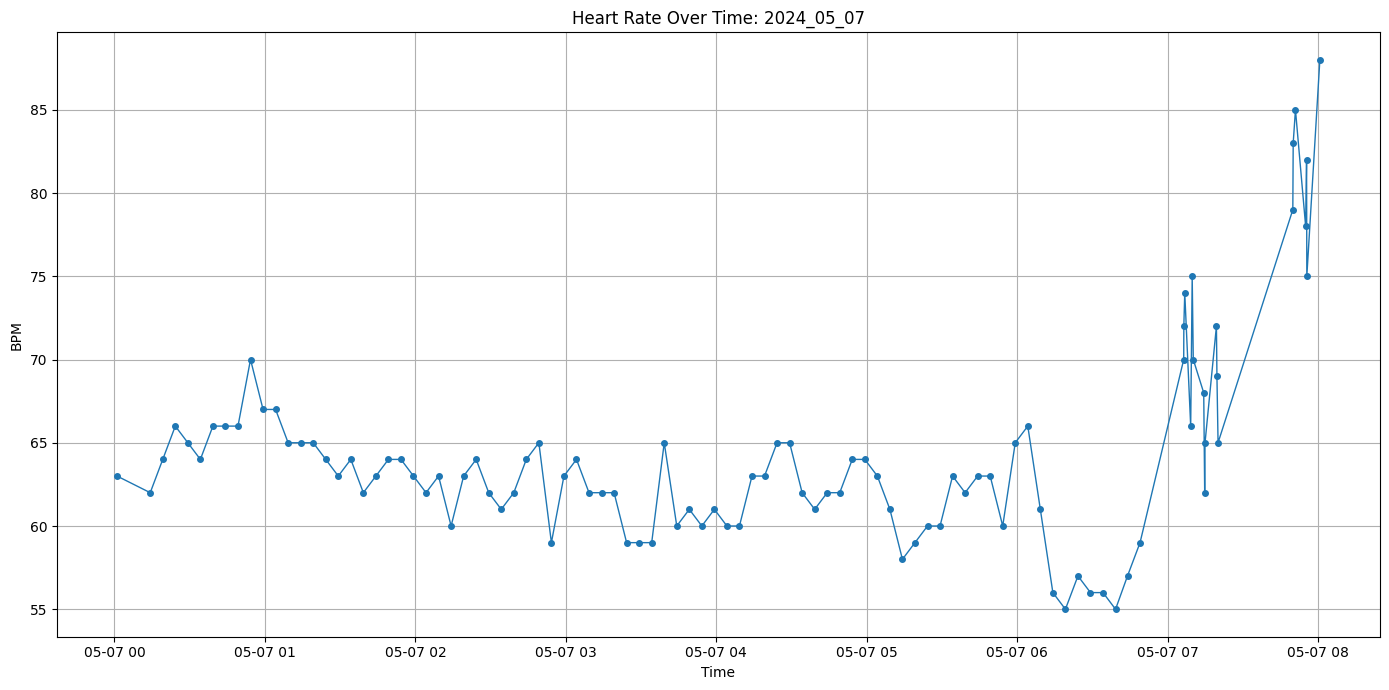

In [133]:
# For this day plot raw pbm across the day
plt.figure(figsize=(14, 7))
plt.plot(sample_df['datetime'], sample_df['bpm'], marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title(f'Heart Rate Over Time: {sample}')
plt.xlabel('Time')
plt.ylabel('BPM')
plt.grid(True)
plt.tight_layout()
plt.show()

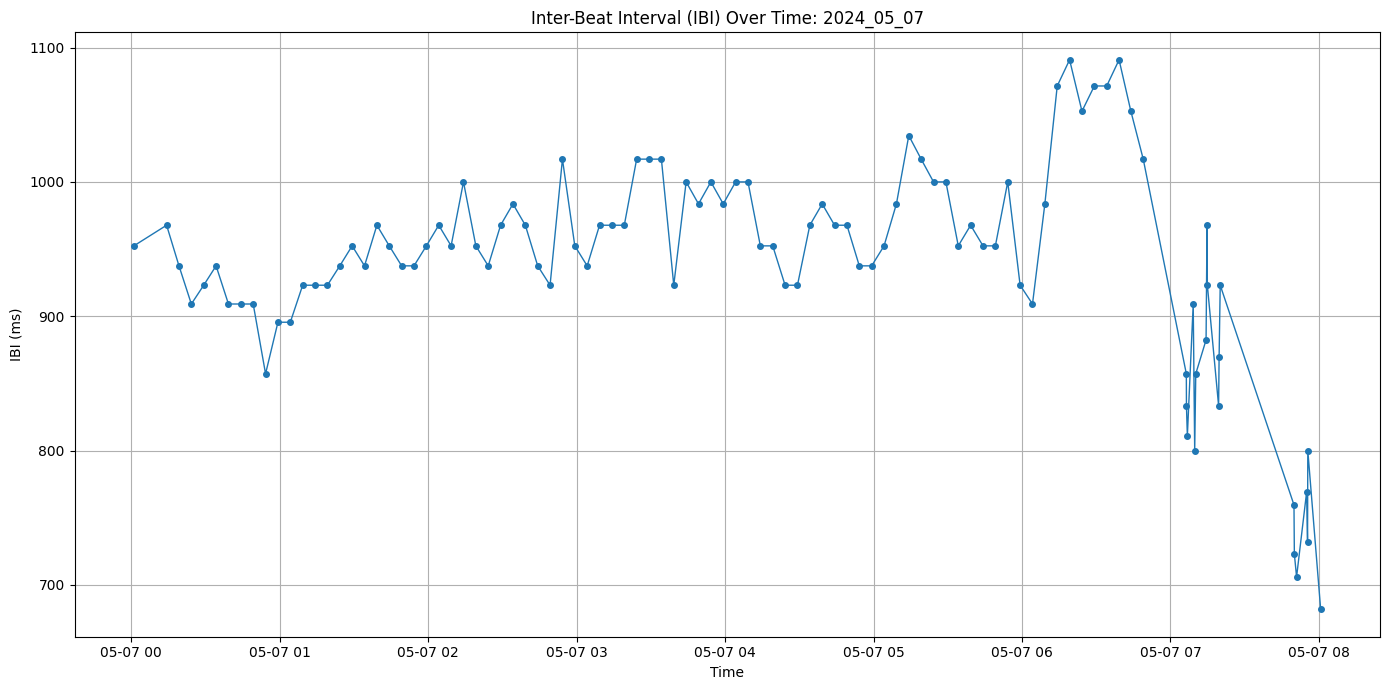

In [134]:
# First level down from BPM collected with PPG is to check IBI (Heart Period)
sample_df = sample_df.with_columns((60000/sample_df["bpm"]).alias("IBI"))  # typically measured in ms
plt.figure(figsize=(14, 7))
plt.plot(sample_df['datetime'], sample_df['IBI'], marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title(f'Inter-Beat Interval (IBI) Over Time: {sample}')
plt.xlabel('Time')
plt.ylabel('IBI (ms)')
plt.grid(True)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

shape: (5, 6)
┌──────────────────────────┬─────┬─────────────────────┬────────────┬────────────┬─────────────────┐
│ timestamp                ┆ bpm ┆ datetime            ┆ IBI        ┆ IBI_DIFF   ┆ breathing_phase │
│ ---                      ┆ --- ┆ ---                 ┆ ---        ┆ ---        ┆ ---             │
│ str                      ┆ i64 ┆ datetime[μs]        ┆ f64        ┆ f64        ┆ i32             │
╞══════════════════════════╪═════╪═════════════════════╪════════════╪════════════╪═════════════════╡
│ 2024-05-07T00:01:01.000Z ┆ 63  ┆ 2024-05-07 00:01:01 ┆ 952.380952 ┆ null       ┆ -1              │
│ 2024-05-07T00:14:15.000Z ┆ 62  ┆ 2024-05-07 00:14:15 ┆ 967.741935 ┆ 15.360983  ┆ 1               │
│ 2024-05-07T00:19:15.000Z ┆ 64  ┆ 2024-05-07 00:19:15 ┆ 937.5      ┆ -30.241935 ┆ -1              │
│ 2024-05-07T00:24:15.000Z ┆ 66  ┆ 2024-05-07 00:24:15 ┆ 909.090909 ┆ -28.409091 ┆ -1              │
│ 2024-05-07T00:29:15.000Z ┆ 65  ┆ 2024-05-07 00:29:15 ┆ 923.076923 ┆ 13.9860

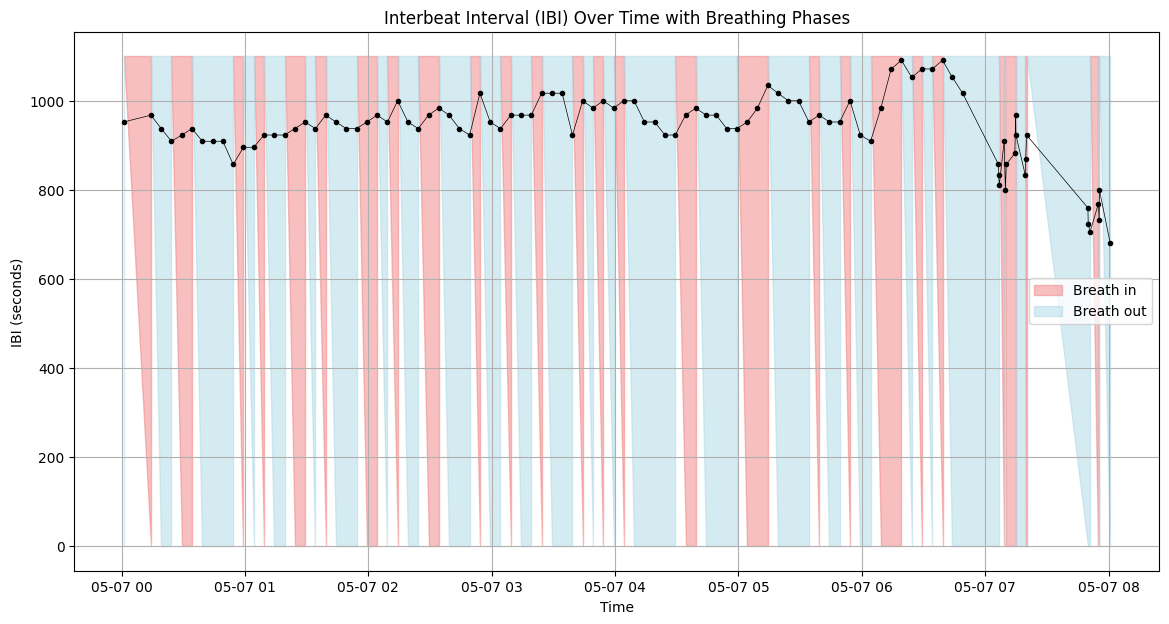

In [135]:
sample_df = sample_df.with_columns((pl.col("IBI").diff()).alias("IBI_DIFF"))
sample_df = sample_df.with_columns(pl.when(pl.col("IBI_DIFF") > 0).then(1).otherwise(-1).alias("breathing_phase"))

plt.figure(figsize=(14, 7))
plt.plot(sample_df['datetime'], sample_df['IBI'], color='black', marker='o', linestyle='-', linewidth=0.5, markersize=3)
plt.fill_between(sample_df['timestamp'], 1100, where=(sample_df['breathing_phase'] == 1), interpolate=True, color='lightcoral', alpha=0.5, label='Breath in')
plt.fill_between(sample_df['timestamp'], 1100, where=(sample_df['breathing_phase'] == -1), interpolate=True, color='lightblue', alpha=0.5, label='Breath out')
plt.title('Interbeat Interval (IBI) Over Time with Breathing Phases')
plt.xlabel('Time')
plt.ylabel('IBI (seconds)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Mean RR Interval: 290.74 sec
Standard Deviation of RR Intervals: 201.47 sec
Minimum RR Interval: 3.00 sec
Maximum RR Interval: 1789.00 sec
RMSSD: 296.34095090566456
SDNN: 201474.28994121825
LF Power: 0.0
HF Power: 0.0


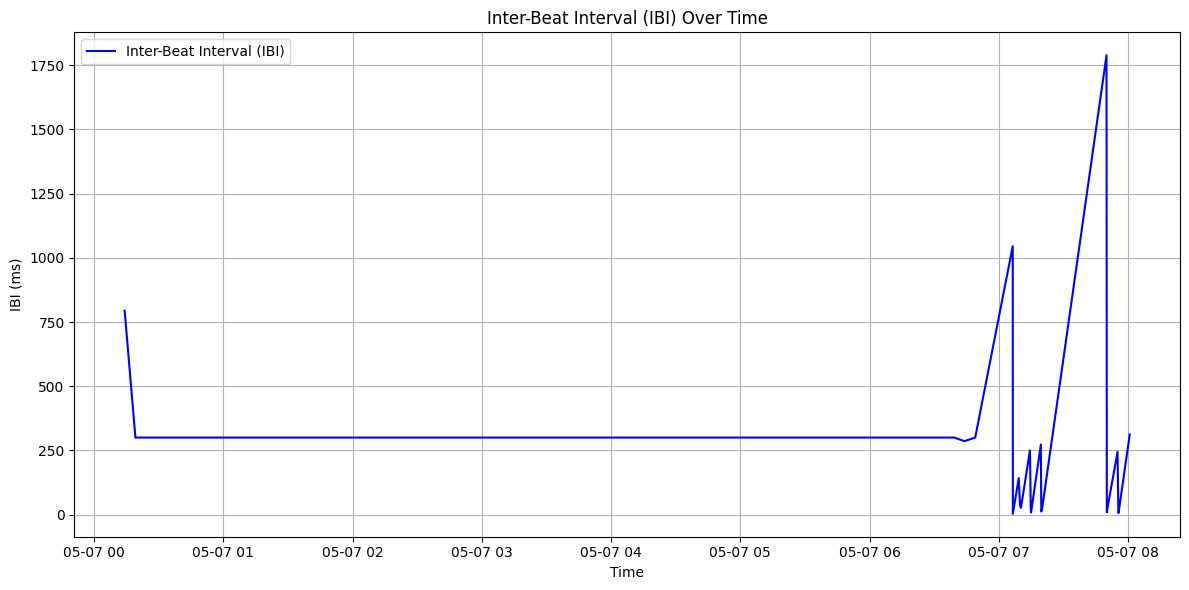

In [171]:
# Getting into HRV estimation with RMSSD and SDDN, HRV frequencies etc. 
# Frequency and quality of the data is not adequate for this type of analysis -> use as a example of computation, but not content
sample_df = sample_df.with_columns((pl.col("datetime").diff().dt.total_seconds()).alias("RR"))
sample_df.select(pl.col("RR").drop_nulls())
# we should remove unrealistic measures, but this series is not really useful and is only used as example
# -> comment out this line with higher frequency data
# sample_df = sample_df.filter(sample_df['RR'] >= 300 & sample_df['RR'] <= 2000)
rr_mean = sample_df['RR'].mean()
rr_std = sample_df['RR'].std()
rr_min = sample_df['RR'].min()
rr_max = sample_df['RR'].max()
# Print the statistical analysis results
print(f"Mean RR Interval: {rr_mean:.2f} sec")
print(f"Standard Deviation of RR Intervals: {rr_std:.2f} sec")
print(f"Minimum RR Interval: {rr_min:.2f} sec")
print(f"Maximum RR Interval: {rr_max:.2f} sec")
sample_df = sample_df.with_columns((pl.col("RR").diff()**2).alias("diff_rr"))
rmssd = np.sqrt(sample_df["diff_rr"].mean())

# Calculate the sampling frequency (in Hz)
nn_intervals = sample_df['RR'] / 1000  # Convert to seconds
fs = 1 / sample_df.select(pl.mean("RR")).item(0,0)  # Sampling frequency in Hz
# Perform spectral analysis using Welch's method
frequencies, power_spectrum = welch(sample_df['RR'], fs, nperseg=len(sample_df['RR'])//8)

# Define LF and HF bands
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.4)

# Calculate LF and HF power
lf_power = np.trapz(power_spectrum[(frequencies >= lf_band[0]) & (frequencies < lf_band[1])],
                    frequencies[(frequencies >= lf_band[0]) & (frequencies < lf_band[1])])
hf_power = np.trapz(power_spectrum[(frequencies >= hf_band[0]) & (frequencies < hf_band[1])],
                    frequencies[(frequencies >= hf_band[0]) & (frequencies < hf_band[1])])

print(f'RMSSD: {rmssd}')
print(f'SDNN: {sdnn}')
print(f'LF Power: {lf_power}')
print(f'HF Power: {hf_power}')
plt.figure(figsize=(12, 6))
plt.plot(sample_df['datetime'], sample_df['RR'], label='Inter-Beat Interval (IBI)', color='blue')
plt.xlabel('Time')
plt.ylabel('IBI (ms)')
plt.title('Inter-Beat Interval (IBI) Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

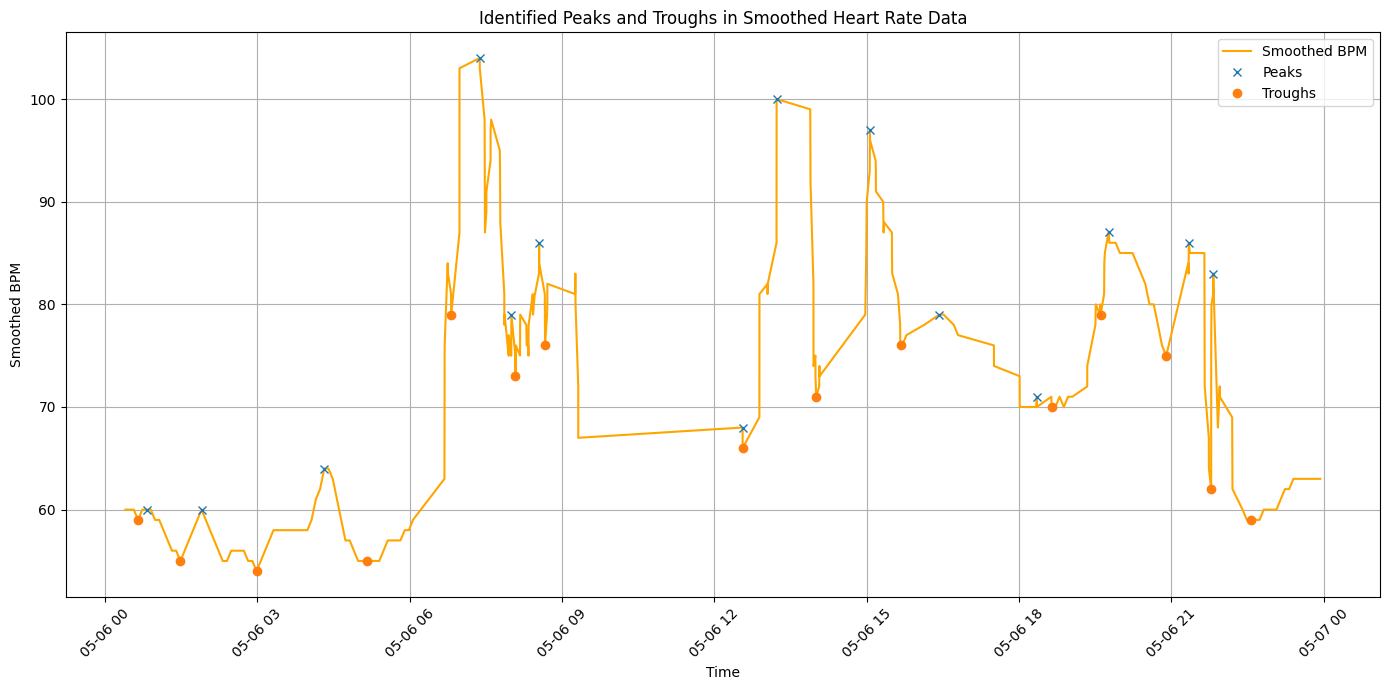

In [9]:
# The quality of the data measurements is not good enough (ideally you would need very small time distance between measures),
# but this is a sample analysis for RD (raspiratory depth) computed from PPG
sample_df = sample_df.with_columns((pl.col("bpm").rolling_map(np.nanmean, window_size=5)).alias("smoothed_bpm"))
# Drop NaN values resulting from the rolling operation
sample_df.select(pl.col("smoothed_bpm").drop_nulls())

peaks, _ = find_peaks(sample_df['smoothed_bpm'], distance=10)
troughs, _ = find_peaks(-sample_df['smoothed_bpm'], distance=10)
plt.figure(figsize=(14, 7))
plt.plot(sample_df['datetime'], sample_df['smoothed_bpm'], label='Smoothed BPM', color='orange')
plt.plot(sample_df['datetime'][peaks], sample_df['smoothed_bpm'][peaks], 'x', label='Peaks')
plt.plot(sample_df['datetime'][troughs], sample_df['smoothed_bpm'][troughs], 'o', label='Troughs')
plt.title('Identified Peaks and Troughs in Smoothed Heart Rate Data')
plt.xlabel('Time')
plt.ylabel('Smoothed BPM')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABW0AAAKyCAYAAACuWPzHAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy80BEi2AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd5wTdf7H8VeS7Y0OuyC9SBEEUbECShdFPJVT+UmzN1Ts56nooZ6oiIj9TrD3claKiAVELAiiICxVpAssC9s3md8fs8lutmZ3k0zK+/l47COTyWTmk+zs7OSTz3y+NsMwDEREREREREREREQkJNitDkBERERERERERERESilpKyIiIiIiIiIiIhJClLQVERERERERERERCSFK2oqIiIiIiIiIiIiEECVtRUREREREREREREKIkrYiIiIiIiIiIiIiIURJWxEREREREREREZEQoqStiIiIiIiIiIiISAhR0lZEREREREREREQkhChpKyIiEuImTJhAu3btLNv+wIEDGThwoNe83bt3c95559GkSRNsNhszZ87kyy+/xGaz8eWXX/pt21OnTsVms/ltff7Wrl07zjzzTKvDqLdQf5/rY+7cudhsNn788ceAbaOyvxGpyGazce211wZ8O4E4FomIiIgEm5K2IiIiFghGIqk21qxZw9SpU9myZYtPy994443Mnz+fO+64g5dffpnhw4cHNsAaTJgwAZvN5vlJS0vj6KOP5tFHH6WgoMDS2CKBOwnmy4/4x+rVqznvvPNo27YtCQkJtGrViiFDhvDEE09YHVq1vv32W6ZOnUpWVpbVodSopuPwwIEDOeqoo4IcVanXXnuNmTNn+rx8u3btvP4Wk5OTOf7443nppZfqHMOnn37K1KlT6/z8qri/KHL/JCUl0aZNG8466yzmzJlTr+N2oGIWEREJthirAxARERHrrVmzhnvvvZeBAwdWqOpdsGBBheW/+OILzj77bG6++WbPvC5dupCXl0dcXFygw61UfHw8//nPfwDIysri3Xff5eabb+aHH37gjTfesCSmSNGtWzdefvllr3l33HEHKSkp3HnnnRZFFToq+xupj2+//ZbTTjuNNm3acNlll5Gens62bdv47rvvePzxx7nuuuv8uj1/+vbbb7n33nuZMGECDRs2tDqcsPbaa6/x66+/csMNN/j8nN69e3PTTTcBsHPnTv7zn/8wfvx4CgoKuOyyy2odw6effsqTTz4ZsCTo008/TUpKCgUFBWzfvp358+czadIkZs6cyccff0zr1q1rvc5AxywiIhIsStqKiIhItSpLwu7Zs6dCQsZut5OQkBCkqCqKiYnh//7v/zz3r776avr168ebb77JjBkzaNmypWWxhbsWLVp4vbcA//73v2natGmF+WW5XC4KCwst3S+Cwd9fVNx///00aNCAH374ocLf2Z49e/y6LQk9OTk5JCcn1+m5rVq18vqbnDBhAh06dOCxxx6rU9I20M477zyaNm3quX/33Xfz6quvMm7cOM4//3y+++47C6MTERGxltojiIiIhJAPPviAo446ioSEBI466ijef//9SpdzuVzMnDmTHj16kJCQQIsWLbjiiis4cOCA13LunqtLlizh+OOPJyEhgQ4dOnhdLjt37lzOP/98AE477TTP5arufpBl+3W6Lyc2DIMnn3zS65L4qvpILl++nOHDh9OgQQOSkpIYMGAAS5curfCalixZwnHHHUdCQgIdO3bk2Wefrctb6GG32z1xu9s+FBQUcM8999CpUyfi4+Np3bo1t956a4VLcefMmcPpp59O8+bNiY+Pp3v37jz99NM+bffFF18kJiaGW265xTPvjTfeoG/fvqSmppKWlkbPnj15/PHHa1zXI488wkknnUSTJk1ITEykb9++vPPOOxWWc/cKde8/8fHx9OjRg3nz5lVY1t/vc2VxvPrqq/To0YP4+HhPDD///DMjRowgLS2NlJQUBg0aVCEhU1VvXfd+V7Z9h8vlYurUqbRs2ZKkpCROO+001qxZQ7t27ZgwYUKFdRQUFDBlyhSaNWtGcnIy55xzDnv37vVa5scff2TYsGE0bdqUxMRE2rdvz6RJk2p83eV72rr/Ft566y3uv/9+jjjiCBISEhg0aBAbNmyocX0bN26kR48elVaqNm/e3Ou++z1/++236d69O4mJiZx44omsXr0agGeffZZOnTqRkJDAwIEDK22B8vbbb9O3b18SExM9ifjt27dXWO6LL77g1FNPJTk5mYYNG3L22Wezdu1az+NTp0717Pft27f3HB/Kb9OX/XT79u1MmjSJFi1aeJZ74YUXKiz3559/Mnr0aJKTk2nevDk33nhjwFuivPLKK573q3HjxlxwwQVs27bNa5lvvvmG888/nzZt2niONTfeeCN5eXley02YMIGUlBQ2btzIGWecQWpqKmPHjmXgwIF88sknbN261fM+1qW3ebNmzejatSsbN26sdXwTJkzgySefBKi0BYqv/4dqa+zYsVx66aUsX76chQsX+jVmX4+pIiIioUCVtiIiIiFiwYIFnHvuuXTv3p0HH3yQffv2MXHiRI444ogKy15xxRXMnTuXiRMnMnnyZDZv3szs2bP5+eefWbp0KbGxsZ5lN2zYwHnnnccll1zC+PHjeeGFF5gwYQJ9+/alR48e9O/fn8mTJzNr1iz+8Y9/0K1bNwDPbVn9+/fn5Zdf5uKLL2bIkCGMGzeu2tf0xRdfMGLECPr27cs999yD3W73JES/+eYbjj/+eMDs3zl06FCaNWvG1KlTKS4u5p577qFFixb1eUs9iYomTZrgcrkYNWoUS5Ys4fLLL6dbt26sXr2axx57jPXr1/PBBx94nvf000/To0cPRo0aRUxMDB999BFXX301LpeLa665psrtPffcc1x55ZX84x//YNq0aQAsXLiQCy+8kEGDBvHQQw8BsHbtWpYuXcr1119fbfyPP/44o0aNYuzYsRQWFvLGG29w/vnn8/HHHzNy5EivZZcsWcJ7773H1VdfTWpqKrNmzeLcc8/ljz/+oEmTJkDg3ueyvvjiC9566y2uvfZamjZtSrt27fjtt9849dRTSUtL49ZbbyU2NpZnn32WgQMH8tVXX9GvX79ab+eOO+5g+vTpnHXWWQwbNoxVq1YxbNgw8vPzK13+uuuuo1GjRtxzzz1s2bKFmTNncu211/Lmm28CZgWr+725/fbbadiwIVu2bOG9996r83vx73//G7vdzs0338zBgweZPn06Y8eOZfny5dU+r23btixbtoxff/3Vp56q33zzDR9++KFn33zwwQc588wzufXWW3nqqae4+uqrOXDgANOnT2fSpEl88cUXnue6jyPHHXccDz74ILt37+bxxx9n6dKl/Pzzz57E8eeff86IESPo0KEDU6dOJS8vjyeeeIKTTz6ZFStW0K5dO/72t7+xfv16Xn/9dR577DFPBWWzZs082/NlP929ezcnnHCCJyHdrFkzPvvsMy655BKys7M97QLy8vIYNGgQf/zxB5MnT6Zly5a8/PLLXq/PFwcPHuSvv/6qML+oqKjCvPvvv5+77rqLMWPGcOmll7J3716eeOIJ+vfv7/V+vf322+Tm5nLVVVfRpEkTvv/+e5544gn+/PNP3n77ba91FhcXM2zYME455RQeeeQRkpKSSE9P5+DBg/z555889thjAKSkpNTqdbnX/eeff9KoUSOv+b7Ed8UVV7Bjxw4WLlxYoT2K+3Ff/w/V1sUXX8xzzz3HggULGDJkiN9irs0xVURExHKGiIiIBN2cOXMMwPjhhx8883r37m1kZGQYWVlZnnkLFiwwAKNt27aeed98840BGK+++qrXOufNm1dhftu2bQ3A+Prrrz3z9uzZY8THxxs33XSTZ97bb79tAMbixYsrxDpgwABjwIABXvMA45prrvGat3jxYq91uFwuo3PnzsawYcMMl8vlWS43N9do3769MWTIEM+80aNHGwkJCcbWrVs989asWWM4HA7Dl9OV8ePHG8nJycbevXuNvXv3Ghs2bDAeeOABw2azGb169TIMwzBefvllw263G998843Xc5955hkDMJYuXeoVY3nDhg0zOnTo4DWvbdu2xsiRIw3DMIzHH3/csNlsxr/+9S+vZa6//nojLS3NKC4urvF1lFc+jsLCQuOoo44yTj/9dK/5gBEXF2ds2LDBM2/VqlUGYDzxxBOeefV9n8vq0aNHpfuF3W43fvvtN6/5o0ePNuLi4oyNGzd65u3YscNITU01+vfv75l3zz33VBqH++9l8+bNhmEYxq5du4yYmBhj9OjRXstNnTrVAIzx48dXeO7gwYO99sMbb7zRcDgcnr+3999/v8LfpK/K/424/xa6detmFBQUeOY//vjjBmCsXr262vUtWLDAcDgchsPhME488UTj1ltvNebPn28UFhZWWBYw4uPjPe+NYRjGs88+awBGenq6kZ2d7Zl/xx13eL2PhYWFRvPmzY2jjjrKyMvL8yz38ccfG4Bx9913e+b17t3baN68ubFv3z7PvFWrVhl2u90YN26cZ97DDz/stY3ysfqyn15yySVGRkaG8ddff3k9/4ILLjAaNGjg+buYOXOmARhvvfWWZ5mcnByjU6dOVR7PynLvG9X99OjRw7P8li1bDIfDYdx///1e61m9erURExPjNb+yY8iDDz5o2Gw2r7+/8ePHG4Bx++23V1h+5MiRXsf+mrRt29YYOnSo5zi4evVq4+KLL670eO1rfNdcc02lf5O1+T9UGfff+t69eyt9/MCBAwZgnHPOOX6LubJ1VHVMFRERCQVqjyAiIhICdu7cycqVKxk/fjwNGjTwzB8yZAjdu3f3Wvbtt9+mQYMGDBkyhL/++svz07dvX1JSUli8eLHX8t27d+fUU0/13G/WrBlHHnkkmzZtCuhrWrlyJZmZmVx00UXs27fPE2dOTg6DBg3i66+/xuVy4XQ6mT9/PqNHj6ZNmzae53fr1o1hw4b5vL2cnByaNWtGs2bN6NSpE//4xz848cQTPS0m3n77bbp160bXrl293rfTTz8dwOt9S0xM9Ey7q/AGDBjApk2bOHjwYIVtT58+neuvv56HHnqIf/7zn16PNWzYkJycHK/LfH1VNo4DBw5w8OBBTj31VFasWFFh2cGDB9OxY0fP/V69epGWlub5Pfvrfa7JgAEDvPZZp9PJggULGD16NB06dPDMz8jI4KKLLmLJkiVkZ2fXahuLFi2iuLiYq6++2mt+dQN0XX755V6XSZ966qk4nU62bt0K4KmQ/PjjjyutsKyLiRMnevW7df8d1vS3N2TIEJYtW8aoUaNYtWoV06dPZ9iwYbRq1YoPP/ywwvKDBg3yunTeXbl87rnnkpqaWmG+e/s//vgje/bs4eqrr/bqOzxy5Ei6du3KJ598ApQenyZMmEDjxo09y/Xq1YshQ4bw6aef+vR+QM37qWEYvPvuu5x11lkYhuH1tzps2DAOHjzo2f8//fRTMjIyOO+88zzrS0pK4vLLL/c5HoAnn3yShQsXVvjp1auX13LvvfceLpeLMWPGeMWVnp5O586dqzyG5OTk8Ndff3HSSSdhGAY///xzhRiuuuqqWsVclQULFniOgz179uTll19m4sSJPPzww17L1Ta+8mr7f6i23FXFhw4d8lvM5ddR0zFVRETEamqPICIiEgLciaPOnTtXeOzII4/0+kCZmZnJwYMHK/S2dCs/UFHZBJ1bo0aN6t13sCaZmZkAjB8/vsplDh48SEFBAXl5eVW+dl8TQgkJCXz00UcAxMfH0759e6/WEpmZmaxdu9brUu2yyr5vS5cu5Z577mHZsmXk5uZWiLlsYv2rr77ik08+4bbbbvPqY+t29dVX89ZbbzFixAhatWrF0KFDGTNmDMOHD6/xNX388cdMmzaNlStXevXprKzva02/57179/rlfa5J+/btve7v3buX3NxcjjzyyArLduvWDZfLxbZt2+jRo4fP23D/vXTq1MlrfuPGjStcBu5W/v1xL+d+fwYMGMC5557Lvffey2OPPcbAgQMZPXo0F110EfHx8T7HVpttVue4447jvffeo7CwkFWrVvH+++/z2GOPcd5557Fy5UqvxHj57bj3z9atW1c637199/tY2e+ma9euLFmypMblunXrxvz5830ePMuX/TQrK4vnnnuO5557rtJ1uP9Wt27dSqdOnSr8PVQWZ3WOP/54jj322ErjKts2ITMzE8MwKv0bArzaAfzxxx/cfffdfPjhhxV+3+W/+ImJiam0DU5d9OvXj2nTpuF0Ovn111+ZNm0aBw4cqDBYXm3iq0xt/w/V1uHDhwG8vnSob8xQu2OqiIiI1ZS0FRERCTMul4vmzZvz6quvVvp4+aSkw+GodDnDMPweW1kulwuAhx9+mN69e1e6TEpKit8GDXI4HAwePLjaeHr27MmMGTMqfdyd4Nq4cSODBg2ia9euzJgxg9atWxMXF8enn37KY4895nldbj169CArK4uXX36ZK664okLSsnnz5qxcuZL58+fz2Wef8dlnnzFnzhzGjRvHiy++WGW833zzDaNGjaJ///489dRTZGRkEBsby5w5c3jttdcqff2VCfTvubyylWy1VVXixOl01nmdbjW9PzabjXfeeYfvvvuOjz76iPnz5zNp0iQeffRRvvvuuzr1E/XH7yQuLo7jjjuO4447ji5dujBx4kTefvtt7rnnnhq3Eyr7RFk1xeT++/q///u/Kr/wKV8BGywulwubzcZnn31W6etw7yNOp5MhQ4awf/9+brvtNrp27UpycjLbt29nwoQJFY4h8fHx2O3+uQCyadOmnuPgsGHD6Nq1K2eeeSaPP/44U6ZMqVN8lant/6Ha+vXXX4HSL2b8EXNtj6kiIiJWU9JWREQkBLRt2xYorU4ta926dV73O3bsyOeff87JJ59crwRZWYGoMnJfAp2WllZtMrVZs2YkJib69NrrG8+qVasYNGhQta/3o48+oqCggA8//NCrKrCqy32bNm3KO++8wymnnMKgQYNYsmQJLVu29FomLi6Os846i7POOguXy8XVV1/Ns88+y1133VWhWtTt3XffJSEhgfnz53tVes6ZM6c2L9sjWO9zZdtNSkqqdBu///47drvdkzB3V6JmZWV52hVAaaWnm/vvZcOGDV5J8n379tW7gvyEE07ghBNO4P777+e1115j7NixvPHGG1x66aX1Wq8/uKtBd+7c6Zf1ud/HdevWedqEuK1bt87zeNnlyvv9999p2rSpp8q2vseSZs2akZqaitPprPa44Y7r119/xTAMr+0Gan/u2LEjhmHQvn17unTpUuVyq1evZv369bz44otegzXWtkWKP47LI0eOZMCAATzwwANcccUVJCcn1yq+qmIIxP+hstyDiLlbt/gjZn8fU0VERAJNPW1FRERCQEZGBr179+bFF1/0usxz4cKFrFmzxmvZMWPG4HQ6+de//lVhPcXFxWRlZdV6++6ES12eW5W+ffvSsWNHHnnkEc+lrmXt3bsXMCvvhg0bxgcffMAff/zheXzt2rXMnz/fb/GMGTOG7du38/zzz1d4LC8vj5ycHE884F2NePDgwWo/2B9xxBF8/vnn5OXlMWTIEPbt2+d5rOw0gN1u91QKVldl7HA4sNlsXlWmW7Zs4YMPPqjmVVYtWO9zZdsdOnQo//vf/9iyZYtn/u7du3nttdc45ZRTSEtLA0oT/V9//bVnuZycnAoVyYMGDSImJoann37aa/7s2bPrHOeBAwcqVKC6K8T9VQ3uq8WLF1daDetuYVHby/+rcuyxx9K8eXOeeeYZr9f42WefsXbtWkaOHAl4H5/KHiN+/fVXFixYwBlnnOGZV99jicPh4Nxzz+Xdd9/1VFuW5T5uAJxxxhns2LGDd955xzMvNze3yrYK9fW3v/0Nh8PBvffeW+H3YxiG52+9smOIYRg8/vjjtdpecnKyz5f9V+e2225j3759nmNfbeKr6vcZiP9Dbq+99hr/+c9/OPHEExk0aJDfYvb3MVVERCTQVGkrIiISIh588EFGjhzJKaecwqRJk9i/fz9PPPEEPXr08Ep6DhgwgCuuuIIHH3yQlStXMnToUGJjY8nMzOTtt9/m8ccf9xqYxxe9e/fG4XDw0EMPcfDgQeLj4zn99NOr7FfoC7vdzn/+8x9GjBhBjx49mDhxIq1atWL79u0sXryYtLQ0Tw/ae++9l3nz5nHqqady9dVXU1xc7Hntv/zyS51jKOviiy/mrbfe4sorr2Tx4sWcfPLJOJ1Ofv/9d9566y3mz5/Psccey9ChQz2VsVdccQWHDx/m+eefp3nz5tVWOHbq1IkFCxYwcOBAhg0bxhdffEFaWhqXXnop+/fv5/TTT+eII45g69atPPHEE/Tu3Ztu3bpVub6RI0cyY8YMhg8fzkUXXcSePXt48skn6dSpU53fk2C8z5WZNm0aCxcu5JRTTuHqq68mJiaGZ599loKCAqZPn+5ZbujQobRp04ZLLrmEW265BYfDwQsvvECzZs28Es0tWrTg+uuv59FHH2XUqFEMHz6cVatW8dlnn9G0adM6VSi++OKLPPXUU5xzzjl07NiRQ4cO8fzzz5OWluaVlAyG6667jtzcXM455xy6du1KYWEh3377LW+++Sbt2rVj4sSJftlObGwsDz30EBMnTmTAgAFceOGF7N69m8cff5x27dpx4403epZ9+OGHGTFiBCeeeCKXXHIJeXl5PPHEEzRo0ICpU6d6luvbty8Ad955JxdccAGxsbGcddZZPvW7dfv3v//N4sWL6devH5dddhndu3dn//79rFixgs8//5z9+/cDcNlllzF79mzGjRvHTz/9REZGBi+//DJJSUl+eX/K69ixI9OmTeOOO+5gy5YtjB49mtTUVDZv3sz777/P5Zdfzs0330zXrl3p2LEjN998M9u3byctLY1333231lXgffv25c0332TKlCkcd9xxpKSkcNZZZ9U67hEjRnDUUUcxY8YMrrnmmlrF5/59Tp48mWHDhuFwOLjgggv89n/onXfeISUlhcLCQrZv3878+fNZunQpRx99NG+//bZnOX/EHIhjqoiISEAZIiIiEnRz5swxAOOHH37wmv/uu+8a3bp1M+Lj443u3bsb7733njF+/Hijbdu2Fdbx3HPPGX379jUSExON1NRUo2fPnsatt95q7Nixw7NM27ZtjZEjR1Z47oABA4wBAwZ4zXv++eeNDh06GA6HwwCMxYsXV7ksYFxzzTVe8xYvXuz1PLeff/7Z+Nvf/mY0adLEiI+PN9q2bWuMGTPGWLRokddyX331ldG3b18jLi7O6NChg/HMM88Y99xzj+HL6cr48eON5OTkGpcrLCw0HnroIaNHjx5GfHy80ahRI6Nv377Gvffeaxw8eNCz3Icffmj06tXLSEhIMNq1a2c89NBDxgsvvGAAxubNmz3LVfb+Ll++3EhNTTX69+9v5ObmGu+8844xdOhQo3nz5kZcXJzRpk0b44orrjB27txZY7z//e9/jc6dOxvx8fFG165djTlz5lT6nlT2+3DHN378eK959Xmfy+rRo4dP+4XbihUrjGHDhhkpKSlGUlKScdpppxnffvttheV++ukno1+/fp73asaMGZ6/l7LvfXFxsXHXXXcZ6enpRmJionH66acba9euNZo0aWJceeWVnuWq+lsrv7+uWLHCuPDCC402bdoY8fHxRvPmzY0zzzzT+PHHH2t8L8r/jbjX/fbbb3stt3nzZgMw5syZU+36PvvsM2PSpElG165djZSUFCMuLs7o1KmTcd111xm7d+/2Wray99y9nYcffrjS11w+rjfffNPo06ePER8fbzRu3NgYO3as8eeff1aI6/PPPzdOPvlkIzEx0UhLSzPOOussY82aNRWW+9e//mW0atXKsNvtXr+32uynu3fvNq655hqjdevWRmxsrJGenm4MGjTIeO6557yW27p1qzFq1CgjKSnJaNq0qXH99dcb8+bNq/RYVF5V+4bbgAEDjB49elSY/+677xqnnHKKkZycbCQnJxtdu3Y1rrnmGmPdunWeZdasWWMMHjzYSElJMZo2bWpcdtllxqpVqyr8/qs7dh0+fNi46KKLjIYNGxpApf8HyqrqeG8YhjF37lyvbfsaX3FxsXHdddcZzZo1M2w2W4XjhC//hyrjPua4fxISEowjjjjCOPPMM40XXnjByM/Pr/Acf8Ts6zFVREQkFNgMw8KRCERERERE/CQrK4tGjRoxbdo07rzzTqvDERERERGpM/W0FREREZGwk5eXV2HezJkzARg4cGBwgxERERER8TP1tBURERGRsPPmm28yd+5czjjjDFJSUliyZAmvv/46Q4cO5eSTT7Y6PBERERGRelHSVkRERETCTq9evYiJiWH69OlkZ2d7BiebNm2a1aGJiIiIiNSbetqKiIiIiIiIiIiIhBD1tBUREREREREREREJIUraioiIiIiIiIiIiIQQ9bQFXC4XO3bsIDU1FZvNZnU4IiIiIiIiIiIiEoEMw+DQoUO0bNkSu73qelolbYEdO3bQunVrq8MQERERERERERGRKLBt2zaOOOKIKh9X0hZITU0FzDcrLS3N4mi8FRUVsWDBAoYOHUpsbKzV4UiE0f4lgaZ9TAJJ+5cEkvYvCTTtYxJI2r8kkLR/SaBF+j6WnZ1N69atPfnIqihpC56WCGlpaSGZtE1KSiItLS0id1SxlvYvCTTtYxJI2r8kkLR/SaBpH5NA0v4lgaT9SwItWvaxmlq0aiAyERERERERERERkRCipK2IiIiIiIiIiIhICFHSVkRERERERERERCSEqKetiIiIiIiIiIhEFafTSVFRkdVhSCWKioqIiYkhPz8fp9NpdTi1Fhsbi8PhqPd6lLQVEREREREREZGoYBgGu3btIisry+pQpAqGYZCens62bdtqHKwrVDVs2JD09PR6xa+krYiIiIiIiIiIRAV3wrZ58+YkJSWFbVIwkrlcLg4fPkxKSgp2e3h1djUMg9zcXPbs2QNARkZGndelpK2IiIiIiIiIiEQ8p9PpSdg2adLE6nCkCi6Xi8LCQhISEsIuaQuQmJgIwJ49e2jevHmdWyWE3ysXERERERERERGpJXcP26SkJIsjkUjn3sfq0zdZSVsREREREREREYkaaokggeaPfUxJWxEREREREREREZEQoqStiIiIiIiIiIiI+I3NZuODDz7w+3oHDhzIDTfc4Pf1hiIlbUVERERERERERELU3r17ueqqq2jTpg3x8fGkp6czbNgwli5danVoTJ06ld69e1sdhsfcuXOx2Wyen5SUFPr27ct7773ntdzAgQM9yyQkJNC9e3eeeuqpCuvp1q1bhW28/fbb2Gw22rVrF9DXoqStiIiIiIiIiIhIiDr33HP5+eefefHFF1m/fj0ffvghAwcOZN++fVaHFpLS0tLYuXMnO3fu5Oeff2bYsGGMGTOGdevWeS132WWXsXPnTtasWcOYMWO45ppreP311z2PJycns2fPHpYtW+b1vP/+97+0adMm4K9DSVsREREREREREZEQlJWVxTfffMNDDz3EaaedRtu2bTn++OO54447GDVqlGc5m83Gs88+y5lnnklSUhLdunVj2bJlbNiwgYEDB5KcnMxJJ53Exo0bvdb/9NNP07FjR+Li4jjyyCN5+eWXvR7/448/OPvss0lJSSEtLY0xY8awe/duwKxGvffee1m1apWnanXu3Lme5/7111+cc845JCUl0blzZz788EOvdf/666+MGDGClJQUWrRowcUXX8xff/3leTwnJ4dx48aRkpJCRkYGjz76qE/vmc1mIz09nfT0dDp37sy0adOw2+388ssvXsslJSWRnp5Ohw4dmDp1aoUYY2JiuOiii3jhhRc88/7880++/PJLLrroIp9iqQ8lbUVEREREREREJPoYBhTnWPNjGD6FmJKSQkpKCh988AEFBQXVLvuvf/2LcePGsXLlSrp27cpFF13EFVdcwR133MGPP/6IYRhce+21nuXff/99rr/+em666SZ+/fVXrrjiCiZOnMjixYsBcLlcnH322ezfv5+vvvqKhQsXsmnTJv7+978D8Pe//52bbrqJHj16eCpb3Y8B3HvvvYwZM4ZffvmFM844g7Fjx7J//37ATEaffvrp9OnThx9//JF58+axe/duxowZ43n+rbfeyldffcX//vc/FixYwJdffsmKFSt8+92WcDqdvPjiiwAcc8wx1S6bmJhIYWGh17xJkybx1ltvkZubC5iJ6uHDh9OiRYtaxVEXMQHfgoiIiIiIiIiISKhx5sJbKdZse8xhiEmucbGYmBjmzp3LZZddxjPPPMMxxxzDgAEDuOCCC+jVq5fXshMnTvQkPW+77TZOPPFE7rrrLoYNGwbA9ddfz8SJEz3LP/LII0yYMIGrr74agClTpvDdd9/xyCOPcNppp7Fo0SJWr17N5s2bad26NQAvvfQSPXr04IcffuC4444jJSWFmJgY0tPTK8Q+YcIELrzwQgAeeOABZs2axffff8/w4cOZPXs2ffr04YEHHvAs/8ILL9C6dWvWr19PSkoKL7zwAq+88gqDBg0C4MUXX+SII46o8T07ePAgKSnm7zUvL4/Y2Fiee+45OnbsWOnyTqeT119/nV9++YXLL7/c67E+ffrQoUMH3nnnHS6++GLmzp3LjBkz2LRpU41x1JcqbUVERERERERERELUueeey44dO/jwww8ZPnw4X375Jcccc4xXKwLAK4nrrgTt2bOn17z8/Hyys7MBWLt2LSeffLLXOk4++WTWrl3rebx169aehC1A9+7dadiwoWeZ6pSNJzk5mbS0NPbs2QPAqlWrWLx4saeSOCUlha5duwKwceNGNm/eTGFhIf369fOso3Hjxhx55JE1bjc1NZWVK1eycuVKfv75Zx544AGuvPJKPvroI6/lnnrqKVJSUkhMTOSyyy7jxhtv5KqrrqqwvkmTJjFnzhy++uorcnJyOOOMM2qMwR9UaSsiIiIiIiIiItHHkWRWvFq17VpISEhgyJAhDBkyhLvuuotLL72Ue+65hwkTJniWiY2N9UzbbLYq57lcrnoE7ruy23Zv373tw4cPc9ZZZ/HQQw9VeF6LFi1YuXJlnbdrt9vp1KmT536vXr1YsGABDz30EGeddZZn/tixY7nzzjtJTEwkIyMDu73y2taxY8dy6623MnXqVC6++GJiYoKTTlWlrYiIiIiIiIiIRB+bzWxRYMVPSQK1rrp3705OTk691tGtWzeWLl3qNW/p0qV0797d8/i2bdvYtm2b5/E1a9aQlZXlWSYuLg6n01nrbR9zzDH89ttvtGvXjk6dOnn9JCcn0759e2JjY1m+fLnnOQcOHGD9+vV1eak4HA7y8vK85jVo0IBOnTrRqlWrKhO2YFb4jho1iq+++opJkybVaft1oaStiIhIEDy2cD2zFmVW+tisRZk8trBuJx8iIiIiIhK59u3bx+mnn84rr7zCL7/8wubNm3n77beZPn06Z599dr3WfcsttzB37lyefvppMjMzmTFjBu+99x4333wzAIMHD6Znz56MHTuWFStW8P333zNu3DgGDBjAscceC0C7du3YvHkzK1eu5K+//qpxsDS3a665hv3793PhhRfyww8/sHHjRubPn8/EiRNxOp2kpKQwadIkbrnlFr744gt+/fVXJkyYUG1y1c0wDHbt2sWuXbvYvHkzzz33HPPnz6/X+zV37lz++usvTwuHYFB7BBERkSBw2G3MKEnMTh7U2TN/1qJMZixcz5QhXawKTUREREREQlRKSgr9+vXjscceY+PGjRQVFdG6dWsuu+wy/vGPf9Rr3aNHj+bxxx/nkUce4frrr6d9+/bMmTOHgQMHAmY7g//9739cd9119O/fH7vdzvDhw3niiSc86zj33HN57733OO2008jKymLOnDleLRuq0rJlS5YuXcptt93G0KFDKSgooG3btgwfPtyTmJ0+fTo5OTmcddZZpKamctNNN3Hw4MEa152dnU1GRgYA8fHxtG3blvvuu4/bbrut9m9SicTERBITE+v8/LqwGYZhBHWLISg7O5sGDRpw8OBB0tLSrA7HS1FREZ9++ilnnHFGhV4gIvWl/UsCTfuYN0+CdnBnJg/u4pWwLZvIFd9o/5JA0v4lgaZ9TAJJ+5cEUjjvX/n5+WzevJn27duTkJBgdThSBZfLRXZ2NmlpaT5V1oai6vY1X/OQqrQVEREJksknN4Adm5jxOcz+Yh2FLrsStiIiIiIiIlJBeKarRUREwkn+X7DydvhfeyY7JhNnK6LQZSfOYVfCVkRERERERCpQ0lZERCRQCvbDqn/Ch+1hzUPgzGXWvksoNGKJsxVT6HRVOTiZiIiIiIiIRC+1RxAREfG3wiz4fSasewyKss15jY5hVv69zNhuY0qLV5jcbQOzYl+rdHAyERERERERiW5K2oqIiPhLUTasmwVrH4WiLHNew17Q6z5m/d6NGV9lMqUfTM57A+jrSdQqcSsiIiIiIiJlKWkrIiJSX0WHYf0TsPYRKNxvzmvQA3reC63PAZsd59r15qBjXTPhK8AwgNJErdNlWBS8iIiIiIiIhBolbUVEROqqOAfWPwVrp0PBX+a8tK7Qcyq0OR9spa3jbxzSxZzYsbFkTmmSVhW2IiIiIiIiUpaStiIiIrVVnAcbnoE1/4b8Pea81M5w1D3Q9gKwO6p5sq3kVpW1IiIiIiIiUjklbUVERHzlzIcNz8NvD0D+LnNeSgc46m5oNxbsPvxbtZUkbQ0lbUVERERERKRyStqKiIjUxFkAG/9rJmvztpvzktvCUXdB+3Fgj63FylRpKyIiIiIioWXgwIH07t2bmTNnWh2KlLDXvIiIiEgUO7ASPuoCP15jJmyTjoDjnoEz10PHS2qZsKW00lZJWxERERER8dGECROw2WzYbDbi4uLo1KkT9913H8XFxVaHJgGiSlsREZHqbH0Tcv+AhBZmZW3HS8ERX/f12UueW5znn/hERERERCQoHlu4HofdVulAwrMWZeJ0GaUDEAfA8OHDmTNnDgUFBXz66adcc801xMbGcscddwRsm2IdVdqKiIhUx3CZt+3GQpdr6pewBTP5C5C/u37rERERERGRoHLYbcxYuJ5ZizK95s9alMmMkoRuIMXHx5Oenk7btm256qqrGDx4MB9++CEFBQXcfPPNtGrViuTkZPr168eXX37ped6+ffu48MILadWqFUlJSfTs2ZPXX3+92m198sknNGjQgFdffRWAL7/8kuOPP57k5GQaNmzIySefzNatWwP5cqOeKm1FRESCKTHdvC0+BMU5EJNsbTwiIiIiIuITd4XtjIXrPffdCdspQ7pUWoEbSImJiezbt49rr72WNWvW8MYbb9CyZUvef/99hg8fzurVq+ncuTP5+fn07duX2267jbS0ND755BMuvvhiOnbsyPHHH19hva+99hpXXnklr732GmeeeSbFxcWMHj2ayy67jNdff53CwkK+//57bLbAJqmjnZK2IiIiwRSTCo5EcOaZ1bYpHayOSEREREREfFQ2cTv7iw0UOl1BT9gahsGiRYuYP38+F154IXPmzOGPP/6gZcuWANx8883MmzePOXPm8MADD9CqVStuvvlmz/Ovu+465s+fz1tvvVUhafvkk09y55138tFHHzFgwAAAsrOzOXjwIGeeeSYdO3YEoFu3bkF6tdFLSVsREZFgstkgIR1yNkPeLiVtRURERETCzORBnT0J2ziHPWgJ248//piUlBSKiopwuVxcdNFFnHfeecydO5cuXbx76RYUFNCkSRMAnE4nDzzwAG+99Rbbt2+nsLCQgoICkpKSvJ7zzjvvsGfPHpYuXcpxxx3nmd+4cWMmTJjAsGHDGDJkCIMHD2bMmDFkZGQE/kVHMfW0FRERCTZ3i4T8XdbGISIiIiIitTZrUaYnYVvodFXocRsop512GitXriQzM5O8vDxefPFFDh8+jMPh4KeffmLlypWen7Vr1/L4448D8PDDD/P4449z2223sXjxYlauXMmwYcMoLCz0Wn+fPn1o1qwZL7zwAoZheD02Z84cli1bxkknncSbb75Jly5d+O6774LyuqOVKm1FRESCLaEkaZunpK2IiIiISDgp38PWfR8IeMVtcnIynTp18prXp08fnE4ne/bs4dRTT630eUuXLuXss8/m//7v/wBwuVysX7+e7t27ey3XsWNHHn30UQYOHIjD4WD27NkVttWnTx/uuOMOTjzxRF577TVOOOEEP75CKUtJWxERkWBTpa2IiIiISNipbNCxygYnC6YuXbowduxYxo0bx6OPPkqfPn3Yu3cvixYtolevXowcOZLOnTvzzjvv8O2339KoUSNmzJjB7t27KyRt3etbvHgxAwcOJCYmhpkzZ7J582aee+45Ro0aRcuWLVm3bh2ZmZmMGzcuqK812ihpKyIiEmyqtBURERERCTtOl1HpoGPu+06XUdnTAm7OnDlMmzaNm266ie3bt9O0aVNOOOEEzjzzTAD++c9/smnTJoYNG0ZSUhKXX345o0eP5uDBg5Wu78gjj+SLL77wVNzeeuut/P7777z44ovs27ePjIwMrrnmGq644opgvsyoo6StiIhIsCWWNOxXpa2IiIiISNi4cUiXKh8LdIXt3Llzq3wsNjaWe++9l3vvvbfSxxs3bswHH3xQ7fq//PJLr/vdunVj9+7dnvvvv/++r6GKn2ggMhERkWBTpa2IiIiIiIhUQ0lbERGRYFNPWxEREREREamGkrYiIiLBllAmaWtY0/dKREREREREQpeStiIiIsGW0Ny8dRVB4QFrYxEREREREZGQo6StiIhIsDniIa6xOa0WCSIiIiIiIlKOkrYiIiJWcPe1zdtpbRwiIiIiIiIScpS0FRERsYK7r22eKm1FRERERETEm5K2IiIiVig7GJmIiIiIiIhIGUraioiIWCFRSVsRERERERGpnJK2IiIiVlB7BBERERERCWMTJkxg9OjRVocRsZS0FRERsYIqbUVEREREwpPLCZu/gdXvmLcuZ8A2ZbPZqv2ZOnVqwLYt1oqxOgAREZGopEpbEREREZHws+ZDmHcbZO8onZfWEoY/BN1H+X1zO3fu9Ey/+eab3H333axbt84zLyUlxTNtGAZOp5OYGKX7IoEqbUVERKygSlsRERERkfCy5kN4a5x3whYge6c5f82Hft9kenq656dBgwbYbDbP/d9//53U1FQ+++wz+vbtS3x8PEuWLKGgoIDJkyfTvHlzEhISOOWUU/jhhx8865w7dy4NGzb02s4HH3yAzWbzmjdt2jSaN29Oamoql156Kbfffju9e/euEOMjjzxCRkYGTZo04ZprrqGoqMjz2FNPPUXnzp1JSEigRYsWnHfeeX59fyKZkrYiIiLVMgKzWnelbcFf4CqqflkREREREbGWy2lW2Fb6+aBk3rzbA9oqoSq33347//73v1m7di29evXi1ltv5d133+XFF19kxYoVdOrUiWHDhrF//36f1/nqq69y//3389BDD/HTTz/Rpk0bnn766QrLLV68mI0bN7J48WJefPFF5s6dy9y5cwH48ccfmTx5Mvfddx/r1q1j3rx59O/f318vO+IpaSsiImKF+CZgK7lsKX+PtbGIiIiIiEj1tn5bscLWiwHZ283lguy+++5jyJAhdOzYkfj4eJ5++mkefvhhRowYQffu3Xn++edJTEzkv//9r8/rfOKJJ7jkkkuYOHEiXbp04e6776Znz54VlmvUqBGzZ8+ma9eunHnmmYwcOZJFixYB8Mcff5CcnMyZZ55J27Zt6dOnD5MnT/bb6450StqKiIj4xFbzIrVanR0SWpjTapEgIiIiIhLaDu/273J+dOyxx3qmN27cSFFRESeffLJnXmxsLMcffzxr1671eZ3r1q3j+OOP95pX/j5Ajx49cDgcnvsZGRns2WMWpQwZMoS2bdvSoUMHLr74Yl599VVyc3N9jiHaKWkrIiJilUQNRiYiIiIiEhZSWvh3OT9KTk6u1fJ2ux3D8G7zULYPbW3ExsZ63bfZbLhcLgBSU1NZsWIFr7/+OhkZGdx9990cffTRZGVl1Wlb0cbSpO3XX3/NWWedRcuWLbHZbHzwwQdejxuGwd13301GRgaJiYkMHjyYzMxMr2X279/P2LFjSUtLo2HDhlxyySUcPnw4iK9CRESkjhI0GJmIhIbHFq5n1qLMSh+btSiTxxauD3JEIiIiIabtSZDWkqqvwLNBWitzOQt17NiRuLg4li5d6plXVFTEDz/8QPfu3QFo1qwZhw4dIicnx7PMypUrvdZz5JFHeg1eBlS474uYmBgGDx7M9OnT+eWXX9iyZQtffPFFrdcTjSxN2ubk5HD00Ufz5JNPVvr49OnTmTVrFs888wzLly8nOTmZYcOGkZ+f71lm7Nix/PbbbyxcuJCPP/6Yr7/+mssvvzxYL0FERKTuVGkrIiHCYbcxo5LE7axFmcxYuB6H3c8tYkRERMKN3QHDHyq5U/7/Ysn94f82l7NQcnIyV111Fbfccgvz5s1jzZo1XHbZZeTm5nLJJZcA0K9fP5KSkvjHP/7Bxo0bee211zyDh7ldd911/Pe//+XFF18kMzOTadOm8csvv2Cz+X5O8PHHHzNr1ixWrlzJ1q1beemll3C5XBx55JH+fMkRK8bKjY8YMYIRI0ZU+phhGMycOZN//vOfnH322QC89NJLtGjRgg8++IALLriAtWvXMm/ePH744QdP/44nnniCM844g0ceeYSWLVsG7bWIiIjUmiptRSRETB7UGYAZJRW1kwd19iRspwzp4nlcREQkqnUfBWNegnm3eQ9KltbSTNh2H2VdbGX8+9//xuVycfHFF3Po0CGOPfZY5s+fT6NGjQBo3Lgxr7zyCrfccgvPP/88gwYNYurUqV5FkGPHjmXTpk3cfPPN5OfnM2bMGCZMmMD333/vcxwNGzbkvffeY+rUqeTn59O5c2def/11evTo4ffXHIksTdpWZ/PmzezatYvBgwd75jVo0IB+/fqxbNkyLrjgApYtW0bDhg29Gi4PHjwYu93O8uXLOeeccypdd0FBAQUFBZ772dnZgFkuXtceHoHijifU4pLIoP1LAi0S9jG7y4kDcLpcuPz8OuxxzXAArpztOMP4PbJKJOxfErqicf+6qn87nLm7mLFwPbM/X0OhEcP1JzfgqlPbRtX7ECzRuI9J8Gj/kkAK5/2rqKgIwzBwuVyevqu11vVM6DIC/lgGh3dBSjq0OdGssK3rOn00btw4xo0b54m9f//+OJ1OAK/XExcXx8yZM5k5c6bX88suM2rUKEaN8k4yX3LJJV7L3Hnnndx5552e+0OHDqVjx46eZV544YUK650xY4Zn3kknnVRpK4Sa3nt3v1337yocuVwuDMOgqKjIa6A28P1vJ2STtrt2mVVHLVp4N3Bu0aKF57Fdu3bRvHlzr8djYmJo3LixZ5nKPPjgg9x7770V5i9YsICkpKT6hh4QCxcutDoEiWDavyTQwnkf6164ic7A5k2b+G37p35dd0bxDo4HDuz8nSWf+nfd0SSc9y8JfdG2fw0u+pinbSMpNGKJsxVx46FTOfxuS3Y5jmNXzPHst3fFsFl72WekibZ9TIJL+5cEUjjuXzExMaSnp3P48GEKCwvrt7LGvcwfgMM51S8bhnJzc5kzZw6nn346DoeDd999l0WLFvH+++97ih8D7dChQ0HZTiAUFhaSl5fH119/TXFxsddjubm5Pq0jZJO2gXTHHXcwZcoUz/3s7Gxat27N0KFDSUtLszCyioqKili4cCFDhgypMCKfSH1p/5JAi4R9zP7L17AO2nfoQNujz/Drum1/NYDF02mcWMgZZ/h33dEgEvYvCV3Run89+W5WScK2mEIjlsf3jOX65q/Sqfh/dCr+H0ZcE4yMEbhanonRYgjEplodctiK1n1MgkP7lwRSOO9f+fn5bNu2jZSUFBISEqwOJ6TFxsayePFiZsyYQX5+PkceeSRvv/12hercQDAMg0OHDpGamlqrHrqhJD8/n8TERPr3719hX/M16R2ySdv0dLPP3+7du8nIyPDM3717N7179/Yss2fPHq/nFRcXs3//fs/zKxMfH098fHyF+bGxsSF7wAnl2CT8af+SQAvrfaxkIAGH3Y7D368h5QgAbAW7wvf9CQFhvX9JyIum/WvWokxmrmzKlBavMPk4g1kF/2LGwguxtTmPyenvwY5PsBXuw7b1FexbXwF7HLQ4HY4YBa3OgqQjrH4JYSma9jEJPu1fEkjhuH85nU5sNht2ux273W51OCEtOTmZzz//3JJtu1siuH9X4chut2Oz2Sr9O/H17yZkX3n79u1JT09n0aJFnnnZ2dksX76cE088EYATTzyRrKwsfvrpJ88yX3zxBS6Xi379+gU9ZhERkVpxD0RWnANFh62NRUSimmfQsT77mdziDcAcjGzKkC7M+D6WWXl3wd92w+CvoOtNkNIJXIWwcx78cDV80BrmHQur74MDK6GkF52IiIiI1I2llbaHDx9mw4YNnvubN29m5cqVNG7cmDZt2nDDDTcwbdo0OnfuTPv27bnrrrto2bIlo0ePBqBbt24MHz6cyy67jGeeeYaioiKuvfZaLrjgAlq2bGnRqxIREfFRbArEJJtJ2/xdENvJ6ohEJEo5XQZThnRh8hGfQWk9BJMHdfY8jj0Gmvc3f/o8DNnrYPv/4M8P4a9lsP8n82f1PZDUGlqNMqtwmw8ER5w1L0xERKQShr5clADzxz5madL2xx9/5LTTTvPcd/eZHT9+PHPnzuXWW28lJyeHyy+/nKysLE455RTmzZvn1Qvi1Vdf5dprr2XQoEHY7XbOPfdcZs2aFfTXIiIiUicJ6XB4I+TtglQlbUXEGjcO6WJOrPuswmPuxK0Xmw0adDV/ut8G+Xtg+yew/UPYuQByt0Hmk+ZPTCq0HGEmcVuOgPjGAX41IiIilXNflp6bm0tiYqLF0Ugkcw82Vp8WIpYmbQcOHFht5tlms3Hfffdx3333VblM48aNee211wIRnoiISOAlliRt83dZHYmISN3bGiQ0h44TzZ/iPNj9Bfz5P9j+kXl8++Mt88fmgGanlvTBHQWpHf0bv4iISDUcDgcNGzb0jI+UlJQUtgNdRTKXy0VhYSH5+flh19PWMAxyc3PZs2cPDRs2xOFw1HldITsQmYiISFRw97XNU9JWRCJETCK0Gmn+GC7Y96NZgbv9Q8haDXu+NH9WTIEGPUrbKDQ5Hmzh9cFMRETCj3vg+vID20voMAyDvLw8EhMTwzap3rBhQ8++VldK2oqIiFjJnbRVpa2IhBJ/fUCy2aHp8ebP0dPg8Gaz+vbPD2HPV3DwN/NnzYOQ0AJanWkmcdMHQ0ySf2IQEREpw2azkZGRQfPmzSkqKrI6HKlEUVERX3/9Nf37969XewGrxMbG1qvC1k1JWxERESslZpi3StqKSDRIaQ9HTjZ/Cg/AjnlmBe6OTyF/N2z8r/njSIBWZ8MJ/zUHbBQREfEzh8Phl8Sa+J/D4aC4uJiEhISwTNr6i64/EhERsVKi2iOISJSKawTtLoSTX4e/7YXTP4cukyG5LTjz4Y83Ye9Sq6MUERERsYSStiIiIlZSewQREXDEQfogOPZxGLUZGvUx57t02aqIiIhEJyVtRURErKRKWxERbzYb2Nxd3AxLQxERERGxipK2IiIiVvJU2u42R1kXEbFUiCRJbSUfU4wQiUdEREQkyJS0FRERsVJCc/PWKIaCfdbGIiISMmwlt/oyS0RERKKTkrYiIiJWssdCfFNzWn1tRSRk2GpeJKCbV6WtiIiIRDclbUVERKoVhIRBgvraioh4sanSVkRERKKbkrYiIiK+sAWw6sw9GJkqbUVESqjSVkRERKKbkrYiIiJWU6WtiIg3VdqKiIhIlFPSVkRExGrVVdpm/Qp//i+48YiIWE6VtiIiIhLdlLQVERGxWnxz8zZ/T8XHll4IX4+GfT8ENSQRiVYhkiR1V9oaqrQVERGR6KSkrYiIiNXsceatUVzxsbzt5u32j4MXj4gIAezjXavth0gSWURERCTIlLQVERGxWlWDnBkGFGWb0zvnBS8eERHLWZ00FhEREbGWkrYiIiKhonzvRmceGE5zet8PkP9X8GMSEbGUKm1FREQkOilpKyIiYrkqLgMuOljmjgG7Pg9WQCIi1vL0tFXSVkRERKKTkrYiIiKWqyppm+19Xy0SRCRqqKetiIiIRDclbUVERKxWVUVZZUlbjaQuIlFBPW1FREQkuilpKyIiYrkqkhPupG1qZ4hJhvzdkPVL8MISkegTcu0IQi0e/5n1xQbm/1n58X/WokweW7g+yBGJiIhIKFHSVkREJGRUUWkb3wxanG5O71CLBBEJApvFla5R0NPWbrPx6TYHsxdv9Jo/a1EmMxaux2FXtbGIiEg0U9JWRETEarYaetrGpkHGMHNafW1FJCpEfk/ba0/ryBmtnTz+xUZmLfgVinM9CdspQ7oweVBnq0MUERERC8VYHYCIiIjU0NM2NhUyhpvTe5ea82PTgheeiEjQRUeV6bAjDDp3bMOML7Yye/EGCo1YJWxFREQEUKWtiIhICKiiosxVZN7a4yG1I6R0AqMYdn0R1OhERKwTuZW2btf2LSDOVkShEUucw66ErYiIiABK2oqIiFjP196RLUuqbdUiQUQiXRT0tHWbvSzHTNjaiih0upi1KNPqkERERCQEKGkrIiISMmpITrhbJOycHxWJDBGJZpHf0xZg/p82Hv/2MFNavML6nucwZXAnZixcr8StiIiIqKetiIiI9XysKGsxEOxxkLMFDq2HtCMDHZiIRB33ccjqnrKRn7SdvXgjn25zcP1JKUw+/AYAk0/vADY7MxauN++rVYKIiEjUUtJWRETEclUlJ8rdj0mG5v1h1+ewY56StiIiYcxlGJzR2sm1J6XCgpKZhsuTqHW6IjdhLSIiIjVTewQRERGr1di7sUzFW4b62opIFIiCnraTT+/EsCPKvT7DZT42qDM3DuliQVQiIiISKpS0FRERsVwtLkN2J233fAnFeQGJRkTEepHfHqFU2f8B0fB6RURExBdK2oqIiIQMHz6sN+gOSUeAMx/2fB34kERErGCL0qRtSaWtiIiIiJK2IiIi1QnKpbk+9rQFM5GhFgkiIhFKSVsRERExKWkrIiJitZp6N9rKtU/IGGbeKmkrIhEr8nvaVspwWh2BiIiIhAglbUVERHxSi76zdV63j8mJ9MFgc0D275CzNWBRiUg0ch+HAnnM80UUtUewOUqnszOti0NERERCipK2IiIilqtlciSuITQ9wZzeOd/v0YiIhI4oSNqWtWuh1RGIiIhIiFDSVkREJGSUS05Ud1mwu6/tDrVIEJEIVL4tTEQrc6zftcC6MERERCSkKGkrIiJitZp62lbGnbTd9Tm4ivwfk4iIpaKop61RZvCxvd9C0SHrYhEREZGQoaStiIiI5Wrq3VhJxVnjYyC+KRQfgr+WBSowERGLRFFP27Kv0SiG3V9aFomIiIiEDiVtRURELFeH5ITNDhnDzGm1SBCRSBVtlbagFgkiIiICKGkrIiJivbr2bnS3SNippK2I+Ik7SWp1T1mrtx9U5RLTO5W0FRERESVtRUREQkeFirIaKswyhpq3B36GvF0BCUlExBpR2B7BkQQ2BxxaDzlbrQ1JRERELKekrYiIiOVqSE5UVXGW0Bwa9zWnVZklIhElipK27i/s4hpBk37m9M6F1sUjIiIiIUFJWxEREcvVIzmhFgkiEsmioactZVpSuK+gUF9bERGRqKekrYiIiNXclbR1SU60GGje7v/Jb+GIiFguinra2jwDkdkg3Z20/RxcTstiEhEREespaSsiImK5qpITPiRxY1LMW1eR36IREbFeFLVH8FTa2qHJcRDbAAoP6Ms4ERGRKKekrYiISMioKjlRTcWZzVHyVFVkiUgkiaKkrecqCxvYY6DF6ebdXeprKyIiEs2UtBUREbGarR7JCSVtRcSvyiQQQ0FU9LQtaY9gK/lopr62IiIigpK2IiIiIaAePW1tMSXPVdJWRCJIfb7MCjdGuUS5O2m791soOmRJSCIiImI9JW1FREQsp0pbERFvIVLpGxTlkrYpHSClIxjFsPtLq4ISERERiylpKyIiEqp8qbxV0lZEIlI0VdqWa48AapEgIiIiStqKiIhYrsbLgH0ZiKzYnxGJiISGqOhpW/IabWWO9elDzFsNRiYiIhK1lLQVERGxXD162tpVaSsiESiqetqWVNqW/WjW4jTzS7nsdZCz1ZKwRERExFpK2oqIiFhOPW1FJMTYrO4pa/X2g6mSStu4htCknzm9U9W2IiIi0UhJWxEREavZqqi0dbc8qC55oqStiPhViFS2RlOlbfmByNzSB5u3e74OajQiIiISGpS0FRERCVW528zbxJZVL2OLMW+VtBWRSBQNPW0rG4gMIKmVeVt8KLjxiIiISEhQ0lZERKRawUgYVFFRdniTeZvSsZqnuittXdGR3BCRKKFKW+xx5q2zIKjRiIiISGhQ0lZERMQngeyvWEVy4tBG8zalQzVPdZROewazEREJd1HU07aqSlt30tZVGNx4REREJCQoaSsiImK1ynrauoog9w9z2uekbbH/YxMRsYJ62oI93rxV0lZERCQqKWkrIiJiuUoqynL+MPvUOhIgMaOap5ZN2qqvrYhEmGho++J+jVVW2qo9goiISDRS0lZERCRklElOuPvZJrev+EG+LCVtRSQgrG5PEE2Vtu7WNlX0tFWlrYiISFRS0lZERMRylSQnDrv72VYzCBkoaSsi/hUyla1WJ42DyKiiPYJD7RFERESimZK2IiIiVqusp6270ra6fragpK2IRKbKjosRq4aByJxqjyAiIhKNlLQVERGxXGWVtiVJ29SaKm3L/CtX0lZEIk4UJG2rqrRVewQREZGopqStiIiI5Sq5DNjTHqGmSltbabWtq9i/YYmIWCaaetq6ByKrqj2CKm1FRESikZK2IiIiIaPkg7thlGmPUEOlLZSptnVVu5iISPiIovYIhVnmbWya93z3F3KGju0iIiLRSElbERERq5Xv3ViwD4qyzenkdr6swPv5IiL1ZvFAYOWrTiOYLX+nOZHYsooldGwXERGJRkraioiIWK7cZcDuKtvEVhCTWPvni4hEjCg4ruW5k7YZ5R6InsS1iIiIVKSkrYiIiNVs5ZO2Pvazrer5IiJ1FirHkeg5rnkqbRPKJ21L6CoKERGRqKSkrYiIiOXKVVO5K21TfehnW/b5+mAvIhEjio5r+bvMW1XaioiISBlK2oqIiIQKo1ylbbKPlbZRVJEmIlEimnra5rmTtuppKyIiIqWUtBUREbFcFT1t1R5BRKJehB/XDAPyq+hpG0WJaxEREalISVsRERGrVdXTVu0RRCRqRceXUbEcxuYqMO8kple+kI7tIiIiUUlJWxEREcuVSbo68yF3u3nf10rbKEluiEgQWV7lGR1fRiUYB8yJuEbgSCj3qNW/AxEREbGSkrYiIiKWK/PB/PAWwICYFIhv5uPToyO5ISJRxPKkcXB4krYVBiErS8d2ERGRaKSkrYiISMgwvPvZ+py0UKWtiPhLiBxHbA7z1ii2No4Ai3ftNycqHYRMx3YREZFopqStiIiI1cr2tHX3s03xtZ8t6IO9iEQce7x56yywNo4A81TaJlRXaSsiIiLRSElbERERy5Vpb1C20tbnp6s9gohEGEdJ0tYV6Ulbd6VtJUlbHdtFRESimpK2IiIilitbaVuStE2tS6Wty48xiYhYyD0oV8QnbavraRsdfX1FRESkckraioiIVCcYFU5le9e62yMkq9JWRKxkccLQ0x4h39o4AixeA5GJiIhIFZS0FRER8UUwRjI3XPWstNUHexGJEI4o62lb2UBkwfi/IyIiIiFLSVsRERHLlXwwz98Fzjyw2SGpTe2fr6StiNRXqFTs20vaI0Rypa1hVN/TtnTBoIQjIiIioUVJWxEREcuVJF2Lc8zbpDbgiKvF00v+nYdKskVEpL6iYSCy4kPEUPL61NNWREREylHSVkRExGrlL4FNqUU/W3MFJbdK2opIhIiGgcjydwJgxKRCTHLVy+kLORERkaikpK2IiIjlyidta9PPljJJX32wF5EIEQUDkdnydpkTCelVLRG0WERERCT0KGkrIiISapJa1/IJJR/sVY0lIpEiGgYic1faVjYIGUBMinnrzIXdXwYnJhEREQkZStqKiIhYrlw1VW362Xo9X0lbEfEXi6s8o2AgMluembStstI2oSl0vNScXjYOCg8EJzAREREJCUraioiIWK18T9vaJkvUHkFEIk00DESWb7ZHMCodhKzEMY9BSifI3QY/XK0rKkRERKKIkrYiIiKWq29Fm9ojiIi/hMhxJAoGIrPl11BpCxCbAie9AjYHbH0DtrwanOBERETEckraioiIWK2+lbZqjyAikSYKBiKjZCAyo7qkLUDTfnDUPeb0j9fA4S2BjUtERERCgpK2IiIioaZCEtfH5VVpKyKRIgoGIvNU2lY1EFlZPe6ApidBUbbZ39blDGxwIiIiYrmQT9oeOnSIG264gbZt25KYmMhJJ53EDz/84HncMAzuvvtuMjIySExMZPDgwWRmZloYsYiISG2p0lZExIu9THuESP1CqmQgshorbQHsMXDSyxCTCnu/gbUPBTg4ERERsVrIJ20vvfRSFi5cyMsvv8zq1asZOnQogwcPZvv27QBMnz6dWbNm8cwzz7B8+XKSk5MZNmwY+fkRfCmViIhEGH/1tHXVOxIREaD2Ff/+5q60BXAVWhdHoBTnYivONqerG4isrJQOcOwT5vQv98C+HwMTm4iIiISEkE7a5uXl8e677zJ9+nT69+9Pp06dmDp1Kp06deLpp5/GMAxmzpzJP//5T84++2x69erFSy+9xI4dO/jggw+sDl9ERMQ39e1pa1OlrYhEGPdAZBCZg5GVVNkWEwcxab4/r/04aHM+GMXw7VgozglQgCIiImK1kE7aFhcX43Q6SUhI8JqfmJjIkiVL2Lx5M7t27WLw4MGexxo0aEC/fv1YtmxZsMMVERGpo3JJ2lpXuClpKyIRxh5XOh2Jg5GVJG0LbI1qd8y32eC4ZyCxFRxaDytuClCAIiIiYrUYqwOoTmpqKieeeCL/+te/6NatGy1atOD1119n2bJldOrUiV27zBFXW7Ro4fW8Fi1aeB6rTEFBAQUFpd/YZ2eblyYVFRVRVFQUgFdSd+54Qi0uiQzavyTQImEfs7tcOACn04krUK+juIjYMndru60YbNiA4uIijDB+r2srEvYvCV3Run/ZncXmMc/lCtwxz0cxtlhsRhFFBYfB0cjSWPzNlvMnMUC+rRG22r7P9lRsx79AzFfDYMOzFHW+AVI6BiJMCWPRegyT4ND+JYEW6fuYr68rpJO2AC+//DKTJk2iVatWOBwOjjnmGC688EJ++umnOq/zwQcf5N57760wf8GCBSQlJdUn3IBZuHCh1SFIBNP+JYEWzvtYj4LNdAI2bdrEmj8/Dcg20lxbOK3M/TVr17Jpg+/bGpSbSwqwbNm37Hcc9Ht8oS6c9y8JfdG2f3UpXE83YNsff7Bqd2COeb46w4ghliK++mIBOXYf+76GiSOKv6cv4CS+zvvYYFsLko3dLFv8Pw44uvo3QIkY0XYMk+DS/iWBFqn7WG5urk/LhXzStmPHjnz11Vfk5OSQnZ1NRkYGf//73+nQoQPp6eZIq7t37yYjo/REbvfu3fTu3bvKdd5xxx1MmTLFcz87O5vWrVszdOhQ0tJq0VMqCIqKili4cCFDhgwhNja25ieI1IL2Lwm0SNjH7CsXQyZ06NCBdr3OCMxGDq6GBaV3u3fvQdfOvm8r5rNkOAwnnnACRrNTAxBgaIqE/UtCV7TuX/Y1P8Nv0LpNG1r1DdAxz0cx/0uGwjwGnNoPGhxlaSz+ZtuyD34AbLY672Mxn6XC4d2cdGI/jKYn+z9ICWvRegyT4ND+JYEW6fuY+4r/moR80tYtOTmZ5ORkDhw4wPz585k+fTrt27cnPT2dRYsWeZK02dnZLF++nKuuuqrKdcXHxxMfH19hfmxsbMjuDKEcm4Q/7V8SaGG9j9nN9u8OhwNHoF5DTJzXXYcjpnbbKokxxuGAcH2f6yGs9y8JeVG3f9kdADjsATzm+SomAQoh1u6KvGObwzxuG9jrvo/ZzefE2G2R9/6I30TdMUyCSvuXBFqk7mO+vqaQT9rOnz8fwzA48sgj2bBhA7fccgtdu3Zl4sSJ2Gw2brjhBqZNm0bnzp1p3749d911Fy1btmT06NFWhy4iIuKj2g48VtXzNRCZiEQQe0mRRSQORGa4zJv6jAttc5Ssq9gPAYmIiEioCfmk7cGDB7njjjv4888/ady4Meeeey7333+/Jyt96623kpOTw+WXX05WVhannHIK8+bNIyEhweLIRURE6qq2SVwlbUUkAjncSduC6pcLR56kbT2+tPMkbZ1+CEhERERCTcgnbceMGcOYMWOqfNxms3Hfffdx3333BTEqERERP7KV/9Beyw/xtpJKLUNJWxGJIPaSIgxXJCZt3YnWeiRt7SUf5VyqtBUREYlE9bgeR0REJBoEIxFa7kN7hSSur89X0lZE6iuEjiOOCG6PgD/bI6jSVkREJBIpaSsiImK5eva0tSlpKyIRyFFSaRvR7RHqk7QtqbRV0lZERCQiKWkrIiLik/oOFlbdquvZHsG9vNojiEgkcQ9EFpHtEVwlE/7oaav2CCIiIpFISVsREZFQo/YIImK5AH5R5atIbo9QUh1br0pbuyptRUREIpmStiIiIpYrlxxxD77j89Pdlbau6pcTEQknET0QmR972mogMhERkYikpK2IiIjlyiVt45vU8fmqtBWRCBLJlbYlA5HV/sqKMjQQmYiISERT0lZERMRq5T+0xzWq7QrMG/W0FZFIEhUDkdUnaav2CCIiIpFMSVsRERHLlU/aNq7l01VpKyL+EkLHkYgeiMwPPW01EJmIiEhEU9JWREQk1NS10jaUki0iIvUVye0R/NHTVgORiYiIRDQlbUVERKym9ggiEmrq02vVX6JgILIKV1rUhgYiExERiWhK2oqIiFiuzId2RyLEJNby6aq0FZEIFMmVtvih0lYDkYmIiEQ0JW1FREQsVyZpW+sq27LPV9JWRCKIu6dtRA5E5o+etu72CKq0FRERiURK2oqIiFit7GXItR2EzFyBeaP2CCISSRxqj1AtVdqKiIhENCVtRUREQkldKm3VHkFEIlEkt0fwDERWj6SteyCylbdFZjWyiIhIlFPSVkRExHJlPrTH16HS1h5r3roK/ROOiESvUKrYj+SByPzR07bsc3++uX7hiIiISMhR0lZERMRy9WyPEJNm3hYd8k84IiKhwBHJPW1Lkra2enwcK5vMXj8btrxRz6BEREQklChpKyIiYjVbPQcii3UnbQ/6Jx4Rkfpctu8v9khuj+DuQ1uP97n8+/L9pXBwbd3XJyIiIiFFSVsRERHL1bPSNq6BeVuU7Z9wRERCQRQMRFav9gjOvNLpFqdBcQ4sOc+8FRERkbCnpK2IiEgoqUtPW0+lrZK2IhJBomAgMr9V2p70GiRmwME18P0VodWbWEREROpESVsRERHLlfnQHluX9gjuSlu1RxCRCKKByKpXttI2MR1OfgNsDtjyKmx4rp7xiYiIiNWUtBUREbFa2Z62qrQVEUuFUIVmRA9EZva0NfzZ07Z5fzj6QXP6p8mw/6e6r1tEqvTYwvXMWpRZ6WOzFmXy2ML1QY5IRCKVkrYiIiKW00BkIiIVuAcic0VuewS/Vdq6dbsZjjgbXIXwzXlQeKDu6xeRSjnsNmZUkridtSiTGQvX47CHwECOIhIRlLQVERGxXD0HIovVQGQi4m8hkHRwD0QWkZW2/uhpW0nS1maDE+ZCcnvI2QLLxpfZloj4w+RBnZkypItX4tadsJ0ypAuTB3W2OEIRiRQxVgcgIiIS9Yyi0mm1RxARMUXyQGR+6WlbxfsS1xBOfQcWnATbP4K1j0D3W+u+HRGpYPKgzlCcw4yF65n9xXoKnShhKyJ+p0pbERGR6rhKEqo2R+C24b4EGEqrZmtDA5GJSCRyD0RmFEdetainp209Po5lDDNvk9tWfKzxMdD3cXN67cN134aIVGly4+eJsxVR6IQ4h10JWxHxO1XaioiIVCd/t3mb0CJw20hoBqe+CzEpYKvDB3hV2opIJHKU+ULLWQAxidbF4m/+aI/QdyY0PBranFv54+6kbnFu3bchIlWa9WMshUZsSeI2llmLMpW4FRG/UtJWRESkOnk7zNvEloHdTuu/1f257qRtcQ64nGAPYFWwiEiwlL0KwZUPRF7S1rDVI2kbmwZdr/dlY3XfhohUataiTGZsHcKUFq8wucUbzGr2GzMWrgdQ4lZE/EZJWxERkep4krYZ1sZRHXfSFqA4G+IaWReLiIS5EErw2WMxK1GNyBuMzPBDT9ua1CchLCJV8gw6VpKwBZg8IAPssUrciohfKWkrIiJSFcMIXqVtfTjizYo0V4HZIkFJWxGJBDabeXxz5pvHt0hS0tM2OEOMhFAiXiQCOF0GU05wMDn3jdKZxXmeRK3Tpb85EfEPJW1FRESqUngAXIXmdChX2oJZbVuwV31tRcQ/QqVK055gJm2d+VZH4mfuSttAvs8h8jsUiTA3DukCaz+Cn8vMdJnHKFXYiog/BeOrXRERkfDkrrKNb+I9IE4oim1g3hYetDYOERF/ch97I7Y9QhASq4aq/kT8LusX7/vFedbEISIRTUlbERGRqoRDawQ3d1/bEKi0fWzhemYtyqz0sVmLMnmspN+biEiN3IORRVqlrSdpG8iBI90JYSVtRfwua7X3fVeEHaMCSOeJIr5T0lZERKQq4ZS0jSuptC2yvtLWYbcxo5ITcvfAHQ67LtkVER85EszbiO1pq+OhSNhxFcPB38xpW8kXL5H2xVIA6TxRxHfqaSsiIlIVT9I2xPvZQkhV2rr7uc1YuB6c+Uw+KZlZy53mSMtDuqjfm4j4zt0eIeKStkFoj2BTpa1IQBxab455EJMCye3g4K+w5xsoOuS9nD0Gmp4EMUmWhBmqvM4TC/5i8pAezPp6t84TRSqhpK2IiEhVcsOo0jYmdJK24H1CPntxEYVGrE7ERcKBq9jqCLzZSyptI66KzZ201YWPImHnQEk/24Y9S3tGr7qj8mXb/R+c9HJw4gojkwd1hvzdzPh6P7O/+ULniSJV0FmCiIhIVdQeoV4mD+pMnM1M2MbZDZ2Ii4SDg7+atykdrY3DLcIHIgvsx7GSSlsNRCbiXwdL+tk27AndpkDj46DRMeV++pjLbH0D8nZaF2sIm9xpRel5osOu80SRSihpKyIiUhX3SXY4JG1DqD2C26xFmeaJuK2IQpetykEnRCREGAbs+96cbtLP2ljcInYgMrOnrWELZO9G9YUUCQhPpW0vaHM+DP8eRvxU7meF2RrBKIaN/7U23hA167c2peeJTpfOE0UqoaStiIhIVcKp0jbEkrbuwSSmtHiF9T3PYcqxeZUOOiEiIST3D8jfDbYYaNTb6mhMETsQWRB62pZuLAjbEIkiWWWSttXpfLV5u+HZ0Gs9Y7FZizKZ8X1s6Xli/yY6TxSphHraioiIVMZwQX44VdqGTnsET8J2SBcm734DgMl986HR0eagE6BL4ERC0V/LzdtGR0NMorWxuEXqQGSenraOwG0ioFW8IlGq8KD5BRdAw6OqX7bNebDiBsj9E3Z8AkecHfDwwoHnPPEEB5Nzy5wnxnfReaJIOaq0FRERqUzBPnAVmdOJ6dbG4osQqrR1uoxKB5OYPKgzU4Z0welS1ZdISNpXkrQNldYIELkDkXl62qrSViSsZJX0s01qDXGNql/WEQ8dLzGn1z8V2LjCiOc88fgyx7/cP3WeKFIJVdqKiIhUxt0aIb4Z2GOtjcUXnkpb65O2Nw7pUslc88RclRMiISwUk7YROxBZSU/bgCZtVWkr4ne+tkZw63QFrJkOuxbAoQ2Q2ilwsYUJz3nijg2lM3P/BHSeKFKeKm1FREQqE079bKFMpa317RFEJAy5imD/CnO6yfHWxlKWPULbI3gqbYPwccxQ1ZqI39Q2aZvSHlqOMKcznwlMTOGq7LEpd5t1cYiEMCVtRUREKhO2SVvrK20rp6SBSEjL+hWceWbVflpl1fIWcUR2ewQjoB/HVGkr4nfu9ggNe/r+nM5Xmbeb5kBxnv9jCluu0smSSlsR8aakrYiISGXySgYhSwqXpG3oDEQmImHI0xrheLCF0EeESG2P4BmITD1tRcKG4SqTtPWx0hYgYwQkt4XC/bD1DXAV1+LHGZjXEgrKV9rW6n0p+TFcVa9fJAKop62IiEhlwrXS1pkPzkJwxFkbj4iEl1DsZwtl2iNEaqVtAJO2NlXaivhVzlYoPgT2uNpdkWB3mL1tV/0Dlk8yf3xli4HjnoZOl9Y+3pBXJuF64Gd4ow5jSMQ2hNMXQpNj/RaVSCgJoa/RRUREQkjYJW1TS6eLD1kXh4iEp79KkrZNQyxp62mPEGGVtkZxyUSQ2iOor61I/eVuN2+TWtd+kNqOl9btnNIohl//FZkVt/44LhVlwd4l9V+PSIhSpa2IiEhlcsMsaWuPBUcSOHPNFgnxTayOqBxVfImErMKDkP27OR1Kg5BB5A5E5jKTti6bI3DbKLtuw2lW7IlI3bm/FHdf3VQbCc3g7K21+2LdWQif9oDcP2DHp3DEWbXfbkgrqbRtcgKc9mntn778Mtj2LmoBI5FM/7lFREQq46m0zbA2jtqITStJ2obiYGQ6oRYJWft/BAxIbgcJza2OxlvEDkRmJm2NQH4cK5+01Uc/kfopcidtU6tfrir2GIhrVLvndJgEax+GzKciL2nrrrS1x9b+fYHSL/VEIpjaI4iIiJTnckL+LnM6XCptAeLcg5GFYtJWREJWqPazhcgdiMxdaUsQK21FpH7cVbIxdUza1kWnK8zbnfPh0MbgbTcoSipt69p/2/08tX+RCKakrYiISHkFe0s+4NogoYXV0fgupuRyvcKD1sYhIuElVPvZQgQPROautA3gxzGvpK1GWBept/pW2tZFakfIGA4YsOHZ4G03GDzJVqWlRKqivw4REZHy8naatwktzEvZwoW7x5oqbUXEV4YR4pW2kT0QmRHQStsyH/VUaStSf+6kbUxKcLfb+SrzdtMLkdUqxqhnpa1nvARV2krkUtJWRESkvLwwG4TMzd0eoVhJWxHxUe42yN9tDlLVqI/V0VQU4QORGcEciExE6seK9ggALUdCUhso2Ad/vB3cbQeUKm1FaqK/DhERkfLCNWkbq/YIIlJL7irbhr0gJtHaWCoT8QORKWkrEjasaI8AYHdAp8vN6cyng7vtQFKlrUiNlLQVEREpz520TQqzpG2M2iOISC2Fcj9bKB2ILEIrbV0B7Wlrw5PUUNJWpP6KLUraAnS8BOyx8Ncy2P9z8LcfEH6qtNVAZBLBlLQVEZHoUrAfvv0/2PV51cu4k7YJGcGJyV/c7RGUtBURX4VyP1sobY8QcT1ti8ybQFbaQmlfWw1EJlJ/RRa1RwBITIfW55rTkVJtu+1d89aZW7fn17lCVyR8KGkrIiLRZeVtsOVV+GJI1cvkhmmlrWcgshBsj1CYZXUEIlKeqxj2/2RONzne2liqEqntEVxBaI8ApS0SVGkrUn/u5GJMsjXbdw9ItuXVyGiF9ecH5u3eJXVcgdojSOTzeUjsDh06+LTcpk2b6hyMiIhIwB3aUPMyYdvTNsQqbcternbwV+viEJHKHfwVnHnmsSPtSKujqVykDkRmuNsjKGkrEjY8PVgtqn1rdio06AEHf4PNL8GR11kThz/kbrc6ApGw4HPSdsuWLbRt25aLLrqI5s2bBzImERGRAPLhEtH8neZt2CVtQ6zStuzluEraioQedz/bJsdZl4SoSSRW2hqGJ4lq2JS0FQkffurBWlc2m1lt++O1ZouELteGb4uAPd/Ufx02VdpK5PM5afvmm2/ywgsvMGPGDEaMGMGkSZM444wzsNtD9ARPRESkMjV9cHUVQ/5uczpsk7YhUmlb9iQ6a7V1YYhI5UK9ny1E5kBkZf4PBa+nrZK2IvXmqbS1MFHa/mKz1Vf2WtjzFbQYaF0s9bHXD0lbkSjgc8b1/PPP57PPPmPDhg307duXG2+8kdatW3P77beTmZkZyBhFRET8p6bBWPL3mMvYHBDfLDgx+UuotUcom7Qtyo6M/msikSQckrbu9giGy9MHNuwZpa8jeD1tNRCZSP2VnNdYeWVCbBq0+z9zOpwHJPNL0rYkeW6o0lYiV62PNq1ateLOO+8kMzOT1157jeXLl9O1a1cOHDgQiPhERET8q6ZqI3c/24R0sAf4w7S/hVx7hHIn0aq2FQkdRdlwcK05HaqDkEFpewSInBYJZZLPrkBfZq32CCL+4/nyw+KWBO4Byba9B3k7rY2lLgoPQJbaZon4ok5nCfn5+bzyyivce++9LF++nPPPP5+kpCR/xyYiIuJ/NVUbeQYhywh8LP4Wyu0RALJWWROGiFS070fAgOS2kNjC6miq5q60hchpkWBJpa2StiL1FwKVtgCNjoamJ5nHko3/tTaWuti7FP/0oVVPW4l8tTraLF++nMsvv5z09HRmzJjB3/72N7Zv384bb7xBfHx8zSsQERGxmq+VtuHWzxZK2yO4CsEZCsmN8knbX6wJQ0QqCofWCGBe8WArGYYjYiptizyThiptRcJHqFTaAnS+2rzd8Gz4tY7xxyBkUOVAZI8tXM+sRZW38Jy1KJPHFq73z/ZFgsDns4QePXpw5plnkpiYyFdffcWKFSu49tpradSoUSDjExER8S+fK23DMGkbk1I6HQotEsq/1weUtBUJGeGStIXIG4yspNLWwB74ij0NRCbiP0aIVNoCtDkP4ptC7p+w4xOro6mdAA9C5rDbmFFJ4nbWokxmLFyPwx4CSXcRH8X4uuDatWtJTk7mpZde4uWXX65yuf379/slMBERkYCosdK2pDdYOCZt7Q6ISYXiQ2aLhITmFgdUrtL24OqSQd4s/LCT+yfsXAjtLipNBIlEG8OAv0qStk3DIGlrjwdyQuQKAj9wV8XZff4oVncaiEzEj0Ko0tYRDx0vgTUPwfqn4IizrY7IN8V5sP9HP62s8oHIJg/qDMCMheuhMIvJR/7GrE0nMOPzjUwZ0sXzuEg48PlMYc6cOYGMQ0REJPicheCI857nrrRNCsOkLZh9bd1JW6uVv5S5OAcOb4LUTtbEA/BZbyjYB4c3wtHTrItDxEq5f0L+LjOh16iP1dHUzD0YWaS0R3D3tLUFIWnr7glclBX4bYlEulCqtAXodAWsmQ67FkB2JqSFQTJy33KzRUxiK2hxGmx5xftKMT8pm7id/XVDCg0lbCU8+XymMH78+EDGISIiEhwxZQbOPLwJGnT1fjyc2yOAmbTN2x4a7RHcPWyT20F8E9j/kznPyqRtwT7zduc8JW0lerlbIzTs5X1MDFX2CGuP4Km0jQ38tpocD4fWw+7FkDE08NsTiWghVGkLkNIeWo6AHZ+avW2PecTqiGrm7mfb/FQ4djakdoa2F9RxZdUPRDZ5UGdmf/4bhUYscbZiJWwlLNXqK6I333yTsWPHcv755/PMM88EKiYREZHAceaVTh9aV/FxT9I2Izjx+Jt7MLJQqLTdv8K8bXyMmRwCOLDKuni8hMgHLhErhFM/WyhTaRshSdtgVtpmDDdvd84L/LZEIl2oVdpC6YBkm14wWw+EOnc/22anQlwD6Hk3pHUJyKZmLcosSdgWUWjEVDk4mUgo8/lo8/TTT3PhhRfy448/kpmZyTXXXMMtt9wSyNhERET8r+wJbXa50WNdRZC/x5wO50pbgMIQqLTd/5N527gvNDzanM4KlcHIlLSVKBZO/WyhtP+02iPUXsZQwAYHVkLersBvTySihVilLZhfzCS3hcID8MdbVkdTPVcx/LXMnG5+av3XZ6u8py2UDjo2pcUrrO95DlM6LKl0cDKRUOdz0nb27Nncc889rFu3jpUrV/Liiy/y1FNPBTI2ERER/6uu0tb9gdYWY47IG47cSdtQqLQ9UFJp2+gYaFRSaRsqSVtbCH3gEgkmV3HpFypNjrc2Fl9FbHuEICRtE5qZVzsA7FwQ+O2JRDL3gH6hVGlrd0CnK83pzBDPzxxYCcWHIa4RNOjhxxV7J209CdshXZjc4g0AJnf4lilDuihxK2HH56PNpk2bvPraXnTRRRQXF7Nz586ABCYiIhIQztzS6ezySdsyrRFC6YS8NuJK2iMUW5y0LTpUWsnc+Bho0NOcPrzJfMxyStpKlDr4m3kcjE2DtK41Lx8KNBBZ/ahFgoifuJODIXYO0XES2ONg3/elX8qFIndrhKYn++k8u/Lfg9NlVBx0zDCYPKgzU4Z0wemqvAeuSCjy+S+loKCA5OTk0ifa7cTFxZGXFwZ9U0RERNzKVtpWSNqWfBEZrq0RAGJCpD3CgZWAAUlHQEJzSGha+r5mrbYyshIh9oFLJFjc/WwbHxc+X05FXKVtkXkb7KTtrgXgcgZnmyKRKBQrbcE8z2p9njmd+bS1sVSn7CBkflH5QGQ3lk/YAu7WFpMHdebGIYHpoSsSCLU6U7jrrrtISiodYbawsJD777+fBg0aeObNmDHDf9GJiIj4k+HyrtQq2Gv2AItrZN73VNqGcdI2LkQGIivbz9at4dHme5z1CzQ7yZq43NQeQaJVuPWzhcgdiMzuKG2RGUhNTzAHqSzYZx6bm4ZJWwyRkBOCA5G5dbkatr4GW16DPo9AXEOrI/JmGN6DkAV9+8E42Ir4n89J2/79+7NunXdF0kknncSmTZs89236ACQiIqGsbMI2Ns1MbGavL01eRELSNlR62u4v08/WrVEv2PlZiPS11TmLRCl3pW2TcEraRthAZK4gt0ewx0D6INj2ntkiQUlbkboxQnAgMremJ0HDnubVTJtehK7XWx2Rt+zfoeAvcCR6f6FfH9UMRFaBkrYSpnw+U/jyyy8DGIaIiEgQFJfpZ9vwaPMb/+x1lSRtM4Ifm794krZWt0eorNK2ZDCyA6tK57mK4fBGSO0c3MoVfdEs0ago2+xpC+EzCBlEXnuEYPe0BbNFwrb3YOd86Hl38LYrElFCuNLWZoPOV8MPV8GGp+HIyaF1ruOusm3SDxxxwd++krYSpkLwaCMiIhIg7n629jho0N2cPrS+9PGIqLQNgfYIxTlmRQWUjloOZqIczCoQ98nzytvg467wYSf45R44tDFIQYbQBxmRYPnyzNLpxHTr4qitSBuIrKTS1rDHBm+bGcPM233fmW2BRKT2QrnSFqDdWIhJMQsS9i61Ohpvfu9nC1X1tK2ckrYSnmqVtM3MzOTdd99l8+bNAHzyySf079+f4447jvvvvx/Dl7J0ERERqzhLKm0diZB2pDlddjCyiEjahkB7hAOrzA82iRneVctpXcyEefEhyNlqzjtc0mYpZzP8eh981AkWngobnofCrMDFGIpVMiKB9Me7pZVO4cbmMG8jpVLKikrb5Dbml5WGC3Z9HrztikQSI4QrbQFiU6HlGeb03iXWxlKelf1soXQASJEw4/PR5v3336d79+5cdNFFdOvWjZdeeonzzjuP5ORkWrRowdSpU5k+fXogYxUREakfd6VtTBKkliRtD1WStE2KhKSthe0RKutnC2CPLa1wLtsiAaDN381KMJvd/KDx/eXwXjosuQC2f1raA9JvQrRKRiQQDq6F7yZYHYW4eQYiC2LSFiC9pNp2x7zgblckYoR4pS1Ak+PM2/0/WBtHWTnbzC/rbQ5oeqIfV1yLSttIaa8jUcfnpO3999/PrbfeSn5+Pk8//TRXXnklDz74IJ999hkff/wxTz75JHPnzg1gqCIiIvVUXJK0dSSaVZ8AhzLNyiNngTmyNoR5pW0ItEeorJ+tm6dFgnswspIT7fTT4bR5cPY26D0dGvQwT7D/eBO+GgkfHAErboID/hrELIQ/cIn4U1E2fHMOFB+2OhJxC/ZAZG4th5u3O+f7NnCPiHgL9UpbgMbHmrf7frQ2jrLcVbaN+kBsiv/WW5uByJyF/tuuSBD5fLRZt24dkyZNwmazMX78eAoLCxk8eLDn8aFDh7J169aABCkiIuIXnvYISZDczqz8dOZD7jbI32U+Zo+DuMaWhVhvZSttrfpQ7q60bXxMxcfcg5FlVZF8TWoJ3W+BM1bD8J+gy2SIbwr5u+H3GfDZ0fBpb/j9MXNeXYXS4BwigWK4YNl4sw1MYiuIa2R1RPUUIYlGK9ojADTvb35pmbe9dEA6EamFMKi0bdwXsEHuH5C/x+poTHssbo0AqrSVsOVz0jYnJ4fU1FTzSXY7iYmJJCUleR5PTEykoEB/CCIiEsKcZSpt7TGQ0sm8n70Ocsv0sw3nhJ670tZwlr7eYCrOK00GVFZp26gkaVu+PUJ5NpuZ9D32cThnB/T/H7Q+10yqZ62CFVOI+bgd/fKnYdv2dh0GKArj37GIr9Y8BH9+YP7dnPpuGH8hFWF/r+7eisFuj+BIgOYDzemdapEgUmvhUGkbmwppXc3pfSHSImFvIAYhg9q1R1ClrYQnn482NpsNW5kPseXvi4iIhLzikkrbmJIvHT2Dka0vMwhZRsXnhZOYZDwnsVa0SMhabSaME5qblX3ludsjHN4IRYfLVANXc05hj4UjRsGp78A5O+G4p6BJP2yGk3Tnj8R8N9bsf/v9FbD3Wx8rjHUOIxFu5wJYdac5fexsaNrP/NsU63kqbR3B33aG+tqK1F0YVNpCaV/bUEjaFuwr/TK/2SnWxaGkrYQpn5O2hmHQpUsXGjduTOPGjTl8+DB9+vTx3O/atWsg4xQREam/spW2AKnuvrbryiRtw7ifLZgVqlYORubuZ9vomMorlhOaQUI6YNTt8tz4xtD5Khj2HUXDV7M+9jyMxNbma93wHCw8GT7qAqv/BYe3VL0effEskezwZlh6IWBAx0uh02XmfMPfA/pJnVjV0xZK+9ru/QaKc4K/fZFwFg6VtlDa13Z/CPS13bvUvE3rap4D+lUtKm2duipcwpPPZwpz5swJZBwiIiKB56yq0nYdxJQMjBDuSVswWyQUHbSm0tbTz7aS1ghuDXvBrl1mmwOPOiRRU49kbdz/0X7EK8TuXwqbX4Jt78DhDbD6bvOn+QBoPw7anFeazK7r9kTCQXEufPM3KNwPjY+DY58ofcwV7knbCOtpG+z2CGB+WZncDnK2wO4vodXI4McgErbCrNJ2/w9motnKL6r3hkA/W1ClrYQtn88Uxo8fH8g4REREAq+4XKVt2aStuy1CRCRt3ZW2ViRtSyptKxuEzK3R0bBrARz4Bb8kYWx2SD/d/Dl2Nmx7z0zg7v4C9nxl/vx4LRxxTtkn1X+7IqHGMOD7K+HASohvZvaxdSSUeTxM2yNEWmW8p9I2NvjbttkgYzhseMbsa6ukrYjvwqXStlFvs5I/f4852G5yG+ti2ROofraU/m/wqS1WhHzpJ1EnxI82IiIifuSutC3fHiH3D7PHKkRY0jZI7REKs+DTo+G7SXDgZ3NeTZW2UK7S1k9iU6DDOBj0OZy9BY5+wEzOO/Ng62uly0VaEkgEYOsbsOVls1fqKW9Ccmvvx8M1aRtprKy0BfW1FamzMKm0dSRAw57mtJV9bYtzSr/Mb94/ABuoRXsEkTClpK2IiEQPT0/bkvYI8U1LewpmlfRXTYqApK07Ke3MD8721kyHrF9gU5lWSknVVHUktzVv83aVzgtEEjW5DfS4A0auhaHLofPVZR5r5//tiVhtz1fmbeerocVpFR8/4QXztve/gxeTVGRY2NMWoNlJ5u3hDRHQMkMkSJyFULDfnI5raGkoPgmFvrZ/LTePd0mtS8/9RKRWLDpTEBERsYC7PUJMSVLTZjMvcTOAoixzXiRU2ga7ijT7d+/7rf9WfQyeywoNHy9pqyebDZoeb/4AZD4F8U0Cv10Rq8RXMdjLEWfDmJzSvt7hJhjHi2CwciAygLjGpdOF+yGhuTVxiISTQ+vNBGRsmpmEDHVNjoONz1tbaRvwfrY1VNrm7ymdTmwVoBhEAkuVtiIiEj087RHKJCzK9yVz97YV3x3e5H2/xsS3hZez2eNKNu2qfjmRSBWWCdsQvxS5tkoqbQ2r2iPYYyC2oTntrhwUkeplrTZvGxwVHi2WPIOR/WjdOU8g+9n64uCa0ulQ70MsUgXtuSIiEj2c5QYiA7z+FToSSj/Iiu/c/YDd4muq2qps4IggfQAqW+UrImIFV5F5a1WlLZRebVC4z7oYRMLJwV/N24ZHWRuHrxr0MM9riw7CoQ3B376rCP5aZk4HqtK2poHIDv5WOh2slmEifubTmcKUKVN8XuGMGTPqHIyIiEhAFZdU2patNCtbLZHYMjyqJ0JN8WHv+zVdauuVOA128tR9gq9KW5HwEyFftljd0xZKWiRshAIlbUV8klWStG0QJklbeyw07A37vjOrbdO6BHf7+1eYV7jFNYYG3YK7bbeylbZK2kqY8ulM4eeff/a6v2LFCoqLiznyyCMBWL9+PQ6Hg759qxkpWkRExGo1VdpGQj/bYHNVMhp9QhX9ND0qS5wGq9JWIw2LiMXcPW3tDuti8FTaqj2CiE/c7REa9rQ2jtpocpyZtN33A7S7KLjb9vSzPSWArQlqOKcrW2nrKghQDCKB5dNfz+LFiz0/Z511FgMGDODPP/9kxYoVrFixgm3btnHaaacxcuRIvwbndDq56667aN++PYmJiXTs2JF//etfGGXK3w3D4O677yYjI4PExEQGDx5MZmamX+MQEZEIUWlP23KVtlI7udsqzqupPYKlidOSU59IGdBIJCpE2BUQoVBp607aqtJWpGZFhyFnszndoIe1sdSGp6+tBYORBaOfbU1Xx5WttHUV6iorCUu1/srj0Ucf5cEHH6RRo0aeeY0aNWLatGk8+uijfg3uoYce4umnn2b27NmsXbuWhx56iOnTp/PEE094lpk+fTqzZs3imWeeYfny5SQnJzNs2DDy81X+LiIi5RSXVNrGREmlbTASk+X72YIPI5GXTdoGOXlqU3sEEbGYp9I21roY4hqbt0raitTMnfxLaOHD1UQhpLE7aftz6XEnGAwX7F1iTgeqn633BivOyt8LBXu95zlVbSvhp9ZJ2+zsbPbu3Vth/t69ezl06JBfgnL79ttvOfvssxk5ciTt2rXjvPPOY+jQoXz//feAWWU7c+ZM/vnPf3L22WfTq1cvXnrpJXbs2MEHH3zg11hERCQCeCptyyRtI7LSNohVaXVJ2rovkyubOA1aL2ENRCaRLNL36wh5faFUaav2CCI1O1jSGiFc+tm6pXWBmFTz/Dd7bfC2e3CteWxxJEHjYwK4oWoGInMn2pPalM5zqbBPwk+tzxTOOeccJk6cyKOPPsrxxx8PwPLly7nlllv429/+5tfgTjrpJJ577jnWr19Ply5dWLVqFUuWLPEMdrZ582Z27drF4MGDPc9p0KAB/fr1Y9myZVxwwQWVrregoICCgtJvWbKzswEoKiqiqKjIr6+hvtzxhFpcEhm0f0mghdo+FlOciw0oJg6jJKYY7J4UZ3FcM8/8cOYwDOxAsbM44K/HfnA9ZbsyGrZYikmC6rZbXEws5pevhssdq7PWsdZl/7K7XDgAp7MYVwT8riVwQu345QvP/u1yRtT+Xfp3Gxmvy+EsxA44DfO/jxX7mN3RAAfgyt+LMwLeU6koHI9hljIM7L/dg9H4eIyWZ5rzDqzAvnkOtqJs8282rUfYHYMcjY7BvvcrXMsmQWK6OdPmwNXxCowWg6t/cjWq27/su740jy9N+uF0As7AvGd2l7Pkf56rwu/Fvv8XM4YGR2HL247NcFKUfwhsKQGJRfwv0o9hvr6uWidtn3nmGW6++WYuuugiz0ZiYmK45JJLePjhh2u7umrdfvvtZGdn07VrVxwOB06nk/vvv5+xY8cCsGvXLgBatGjh9bwWLVp4HqvMgw8+yL333lth/oIFC0hKSqrkGdZbuHCh1SFIBNP+JYEWKvvY0NwDJAJLlv3EQcdBAIYXFhFf8vjyX7bx12+fWhafv5yYt5fmwKpVq/jzt4YB3dZx+d9Stj45n1QWfPZZtc9Jc27iNKCgIJ+De3fTAvhl1S9sW1O39742+1fXws0cCWzdsonVO8P/dy2BFyrHL18cXfAH7YD16zNZvyVy9u+eBVvpAGzYsIHf/wj/19WnYAttgMzMzRDX25J9rFXxHxwL7NuRybefhv97KlULp2OYlRo61zMg/98Uk8CCpDkU2xI5O2e01zK/bHXyx47w+ns5sjCdroD9wI9woHT+oZ2r+DJxZr3XX9n+dUz+W7QG1h9ozroAHl+6F26mM7B500Z+2/5puccWm4/tddDWiCEGJ18umkeuvUWl65LQFanHsNzcXJ+Wq3XSNikpiaeeeoqHH36YjRvNSyI7duxIcnJybVdVo7feeotXX32V1157jR49erBy5UpuuOEGWrZsyfjx4+u83jvuuIMpU6Z47mdnZ9O6dWuGDh1KWlqaP0L3m6KiIhYuXMiQIUOIjbWw75VEJO1fEmihto/F/M+AQjh5wBBI62bO+zABCswrLo4fMBrSuloYoX84vp4Nu+Hoo4+mV9szArqtmIX3QFbp/YQGrTljSA3bzFoFCyE+Lo5maWmwF3r1OY6ebWoXa132L/vaX+DXt2jXugWtjw3seyPhLdSOX76w//QxbIIuXbrQqXvk7N/2nxfABujUqRMdjgr/1+VY/gb8AZ2P7MaGzViyj9l2xcA3j9E01cYZQ8P/PZWKwvEYZiXbnkT4CmLIZ1i3AxgdzoW3vZfpecqFHNXkeGsCrKvigRTvGAnFZoLI5szFsXIKaa4/OGPoAIipWx6nuv0r5uPrIA86nTiRji1Or/dLqIr9l29gHbTv0IG2R3sfx+yrvoT10K7jkdg3L4XCAgb2P8Fz/i+hL9KPYe4r/mtS50ZKO3fuZOfOnfTv35/ExEQMw8Dm5350t9xyC7fffrunzUHPnj3ZunUrDz74IOPHjyc93Szv3717NxkZGZ7n7d69m969e1e53vj4eOLj4yvMj42NDdmdIZRjk/Cn/UsCLWT2Mac5EFlsfBq447GVtnePTWtbOj+clfw/jnHEBPb1GAYc3uS96YQWNf+uY83/wTZc2IxCAGLikusca632r1jzw4ndKMQeCb9rCbiQOX75wm4ezxwOB45widkX7tdlt0fI6zL7eTtizGOhJftYktl73Fa0P3z2b6mTsDqGWclW2hc1ZtPz0OXKCovENDk6/M4TYxtAx4u95617BFveDmIP/QrNT6nf6svvXzlbIW8b2GKIST8FYgL4fjnMdJbDZqv4v6EkNeVwxIIjwYzV5gy/359E7DHM54KT2q543759DBo0iC5dunDGGWewc+dOAC655BJuuumm2q6uWrm5udjt3iE6HA5cLvNEp3379qSnp7No0SLP49nZ2SxfvpwTTzzRr7GIiEiYMwxP0paYMq1w3F84xiSbgzWI7wr+guJyg5DWNAgZUDpQmgGukh7z9opfpgZETMkgdO59QUQk2NwDkdlDYCCyAg1EJgKAUaa/5IGfYf+P3o8nt4fYCOmH2vhY87b8a/SHPd+UbOOYOlfx+oXhNG9tdk/SFqcGIpPwU+uk7Y033khsbCx//PGHV//Xv//978ybN8+vwZ111lncf//9fPLJJ2zZsoX333+fGTNmcM455wBgs9m44YYbmDZtGh9++CGrV69m3LhxtGzZktGjR/s1FhERCXNlT9QciWUeKPlXmNiyNIErvjm8seK8+GY+PLFM0tZZkrR1BClpa9eJu0j4ibBjs8tM2ho2C5O2cSVJW2eujociAK5ygwJlPuN9v+FRwYsl0JocZ97u+8H/695bkrRtdqr/111BmfPJ8gxXySJlkrYuHesk/NT6TGHBggXMnz+fI444wmt+586d2bp1q98CA3jiiSe46667uPrqq9mzZw8tW7bkiiuu4O677/Ysc+utt5KTk8Pll19OVlYWp5xyCvPmzSMhIcGvsYiISJhzlmn2XjZp607UJrYk8lRyEutPh0qStomtIG+7Oe1Lpa27JYVhQaWtQ5W2IuErwMe0YHFX2lqZtI1NA5vDrEYr2AdJrayLRSQUuJO2sWlQlA1b3/B+vGHP4McUKI1Lkrb7A5C0dVfaNrc4aYs7aeso84V9QRBiEvGvWp8p5OTkeFXYuu3fv7/SPrH1kZqaysyZM5k5c2aVy9hsNu677z7uu+8+v25bREQijDtJZ48tvSTV5YRDTsiJgdQ4877dYV2MfhOkqjR3pW3akbVL2rrjM1xlKm2D9GWrLpGTSGZESFIz0rnc7REs/H9js0FcYyjYC4X7lbQVcX+Z0vg4yN8JB9eYucA8BxTbIDc2cs4Tm5S0RziUCYVZENfQP+vN/wuy15rTzerXK7fe3JW2qD2ChLdat0c49dRTeemllzz3bTYbLpeL6dOnc9ppp/k1OBEREb8pGTUXR8kXj2s+hJlHwcYc2JUEPy0376/50LoYA+SxheuZtSiz0sdmLcrksYXr67Zi9yBkaUeWzvOp0raSnrbBao+gSlsRsZqn0tbigVU8fW33WRtHGQH7fyVSE3elrT0WOl0Jh2Jgcwr8mWyeJ85/LHLOE+ObmD16wb99bfcuMW8bdC89vgSS+3yysi8sK2uPoKSthKFaJ22nT5/Oc889x4gRIygsLOTWW2/lqKOO4uuvv+ahhx4KRIwiIiL1507SORLNE+63xkH2Du9lsnea8yPhhLwMh93GjEo+CM9alMmMhetx2OtYmeuptO1aOq+uPW2D1h5BJ+4SDSKsB2ykvZ5QGIgMzEpbCKmkbcD+X4nUpGzStqAp7Ew0K2zLiqTzRE9fW38mbd39bPv7b511VdlAZOppK2Go1mcKRx11FOvXr2f27NmkpqZy+PBh/va3v3HNNdeQkZERiBhFRETqz11pa0+AebdRef8rA7DBvNuh68jwvQTOVWjelnwQnzyoMwAzFq6HosNM7r6JWeuPYsbnG5gypIvncY/Dm80q2vRB1W/HnbRNLVNp60tlRdmetoYqbUXEVxHS/sEVAj1tofR4Xbjf2jjK8P5/dYjJHb9n1opkZvzcmCl99jO5zReQ3xASfPmCUKQWjJKkrS0GPr+Pyr8sipDzRDCTtn+85d++tkHtZwu+9bS1lxYG6At7CUN1OlNo0KABd955p79jERERCRx3ki7PUbHC1osB2dth67fQPlgnnX6250vzdsUN0PV6wPuD8OyvHBQaVSRsAZaNMy9xO/kNaPv3yrdRnAt5O83psu0RalNpazhLT6BVaSsi0aBgn9lHEkq+RCq2LpYQbI8AMPn0TnBgJTO+3Mnsr9IpNGKZ0uIVJjvfgB+ANQ/B4K8gubXVoUokcVfaZh2K/PNEKB2MbJ+fkrZFh+HACnO6WQi8L0aZgch07idhrE5J26ysLL7//nv27NmDy+XyemzcuHF+CUxERMSv3Elbp49VEYd3By4Wi0we1JnZn6+l0Iglzu6qPGELkLfLvF1xE7QcCbEpFZdx97ONawQp7eC4p8z+jHENag7E3YPMmVs6L9aH5/mDKm1FxCqGAcvGm4N/pXbBaHoK8KV18bjbIxSGUNI2bxd8fzmTCz9itu39kv9XTiYfZwB/h7+WQc5mWDTQTNwmHWF1xBIp3EnbIh+/SAn388TGxwA2yN0GebshsUX91rfvO/PL+OS2QfxCpZpKWw1EJhGi1knbjz76iLFjx3L48GHS0tKw2UovG7DZbEraiohIaHInCBOSfVs+pZ4nryFo1qJMCg0HcbYiCl2xzFqUWUXituTkN287/Pov6FNJz3p3a4SUjuZt56tqEUm5Sw7t8RCTWIvn14NO3EXCjy1C+pj+/hjs+MQ85p3yJsQkWRuPp9I2BNojGAZsfQN+vBYK9zNrz0VmwtZho9DpYFbBv8z/VznbzITt4U3w+Wkw+EtIamV19BIJ3EnbhEq+qK5MuJ8nxqaaYxJkrzVbJLQ6s37rc7dGCGaVbXX/GzQQmUSIWg9EdtNNNzFp0iQOHz5MVlYWBw4c8Pzs3x8C//BFREQqU1xSWdm4GaS1pOqBbWyQ1granhSsyILCPYjLlE7LWd/zHKZ0WVHpYC+mMhUL6x6Dg79XXORQuaRtbdjKnX7ENaz9OurKXWnrKgSXM3jbFZH6q2yE8HDx1/ew8jZzuu9j0Ki3peEAEOfuaWtxpW3+XlhyPnx7kZmwzb6RGbsuYsqQLqy//wymDOlS+v8quTUMWgzJ7eDwBlh0OuRWdym7iI/cSdum6dFznujPwcj2fG3eBq2fbRmV/W8oOxCZXQORSfiqddJ2+/btTJ48maQki78ZFhERqQ13pW1MMgx3V46WPyEvuT/83+E9uERZxXmlCdshXZjc0Twxn9x6vvcH4bLcJ79Jrc0PMT9NrnhC7Km07VCHoMq973GN6rCOOnJXWwC4CoK3XZGgCOOkZiQrzIKlF4BRDK3Pg05XWh2RKb6kPYKVPW3/eBc+6QHb3gVbDLN4lhlbBnn1XJ88qHO5xG2bksRtWzi0Hr44vbTHukhduQcis8dHz3miu69tfQcjcxaa7REgyP1sfRmIrGxPW533SfipddJ22LBh/PijH76JERERCSZ3D1NHInQfBWNegrQM72XSWprzu48KfnyBkr8Tp8uoOOhY7g7PB2Gnq/zJbsn93v8GexzsWgh/vu+9iDtpm1qHStvyH4JiG9ZhHXVUNmmrvrYiEmiGAcsvM/uwJreDfs+HTrsHT6WtBVdLFuyDpRfBkvPMHr8Ne8Kw5TibDax0kMwK/69S2pmJ26Q2kL3OrLjNC/Meo2Itd6WtPSZ6zhOblBmMrD5XMuz/yWw9EN/UbLkQCtQeQSKETz1tP/zwQ8/0yJEjueWWW1izZg09e/YkNjbWa9lRoyLkACYiIpGl2F1pW3KlSPdR0HWkOfrv4d1mb7K2J0VG5URZuTu4ccgpFefn7wTDqL6nbUon6HYr/DYNfroRMoaXvn9+bY8QxEpbewzYYsyKN528i4SJEEly1sWGZ2DbO+Zx5+Q3g9sOpiaenrZBrrT98yP4/nLI32X+P+h+Oxx1NzjiuXFI1U+r8P8qpT0MXgyfD4Ds382K20GLIaF5YOOXyORJ2pbkN6LhPLHR0eaxqWAv5P5hVq/XxV53P9tTgvylVC0HIlN7BAlDPiVtR48eXWHefffdV2GezWbD6VR/OBERCUFlK23d7A5ob0HvrWDKr+KSUWc+FB2sPIHgrraw2aDHHbD5JfNk/rcH4Ohp4CqGnC3mMnVJ2lZoj1BJDIHkSITiQ0raSuQKlUpOvwuz9g8HVppfeAH0fgiaHm9pOBXElWmPYBiB328Ks+CnG2Dzi+b9tK5wwov1e19SOpiJ2s8HwsE1ZsXtoMWQ0MwPAUtUcSdtbWWK0iL9PNGRYFa5H/jZ7Gtb16StFYOQ1UiVthIZfGqP4HK5fPpRwlZEREJW+UrbaFFdn7+8qgZvcSdGbOb71fcx8+7ah+HQBsjdZlaq2uPrNmp3+cRAMCttoczJu9ojiEiAFB2CJX83e2e3PBO63mh1RBW5K22NYig+HNht7ZgPnxxVkrC1QbebYcTP/klkp3YyE7WJLeHgb/DFIMj/q/7rlehilKu0jRZN6tnX1nDBX0vN6WAPQuY+n6ystYOr7EBk8ea0krYShmrd0/all16ioKBiA+fCwkJeeuklvwQlIiLid5VV2kaDapO2VT1WptIW4IhzIH0ouArhp+vLDELWvmKrA5+EQKUt6ORdJGyEWeWwYcAPV5mDZCUdASfODc3q55ik0i+xAtUioegQLL8cvhwOedshtTMMWQJ9HvbuMV5faZ1h0BeQkA5Zq83ErZUDrEn4Kd8eIVo0LtPXti6yf4PCA+ZAv436+C8un1R3XK1sIDKd90n4qfUnrYkTJ3Lw4MEK8w8dOsTEiRP9EpSIiIjfKWlbyWNVVNoaZSptwUw2HPuE+UFmx6ewqeRL2jq1RsDanragSluRsBUm7RE2zYUtr5rJgpNeL61oDUXuFgmFfk5wGi7Y/Ap83BU2Pm/O6zIZRqyEZif5d1tuaUeWtEZoAVm/mAOdifjKVWjeRlvStsmx5u3+H8v0gfWdfW9JlW3TE81xAyzhY09bJW0lDNU6aWsYBrZKvin+888/adCggV+CEhER8TtnSXsERxS0RzjhxdLpOlXauk90y/y/T+sCzQea01m/mLd1TraWO4+IbVjH9dSRKm1FJFAOroEfrzGne90HzSsZCDKUeI6HFa+krLO/vocFJ8Oyi80vB1M6wKAv4djHA9+iqEFXOH2RmTDftQCyfgvs9iRyHMo0bxOPsDaOYGvQw0xqFmXD4U21frrtryXmhCX9bH0YiEw9bSXM+fxVSJ8+fbDZbNhsNgYNGkRMTOlTnU4nmzdvZvjw4QEJUkREpN6KS6oqY6Kg0rbDOEhMh8XDqulbS82VtuUrYt09wdzVKHW+ZFk9bUUCI0wqUSNVcS4sGWMeW9KHQPfbrY4ouHJ3wKqSwSvBvFy6xz+h6w3+bYVQk4Y9oNUo+PN9yHwajpsdvG1LeHIVmwMHAjTua2koQWePhYa9YN/3sP8ns0e0rwwDm1X9bGtilO1pW3L8cSlpK+HH56Tt6NGjAVi5ciXDhg0jJSXF81hcXBzt2rXj3HPP9XuAIiIifhFNlbYAiRnmbX49etqWT666Lxn0jLBcx6RthYHIGtZtPXWlSluR8BKK/WAr89P15kBYCS3gxJfr2PM72KqpVPOVMx9+fwx+ux+Kc8x5HSbA0Q+U/i8Kti5Xm0nbzS9B739DbErNz5Holf27+WVLTIp5ZVG0aXRMSdJ2BbT9u89PSzL2YMvbbp4fNukXwACrUN1AZFTWHsGPVxSIBInPSdt77rkHgHbt2vH3v/+dhIQgflsqIiJSX9HW0zah5INywT5wFoIjruSBMie2vg5E5ubuVVbfSlv1tBWRuqj0g3mI2PI6bPwPYIOTXoXEFlZH5Jtqkx41MAz48wNYcRPkbDbnNTkBjp1VOiK9VVqcDqldzMHgtrwKna+wNh4Jbft/Mm8b9QmTL1v8rPEx5u2BFbV6WhPnGnOiUd/Atz6pLXd7BLsGIpPwVutO0ePHjwfgp59+Yu3atQD06NGDPn2CPVKgiIhILRSXVNqG2klloMQ3MSsfXEWQvwuS21RcxteByNxs7krbkqRtnavfVGkrIhEkOxO+v9ycPuqfkD7I2nhqpY6Vtlmr4acbYPcX5v3EltB7OrS7KDQqo2126HwlrJgCmU9Bp8tDIy4JTe6kbbS1RnBzv+79P5nngD7+rTR2lSRtLWuN4ENP27KVtmqPIGGo1knbPXv2cMEFF/Dll1/SsGFDALKysjjttNP+v737Do+qzv44/pmZVAhJqAmhVwGRIqBSrBRRFMWCveHqiu6ywq69rm3Fn7Iudll1dV0LuhZsKKKrKKhIb0JooYQeIAnpM/f3x82kJ2SSuXOnvF/Pk2fu3Lkzc6KHyZ0zZ85X77zzjlq3bu3vGAEAaLxI67R1OKS4VClvu9lRW2PRdlctJ+e1jUeo2mnb0G4UZtoC1qI4FTDuQunHS6SSXHMhnr732x2Rbxw+Fm0L9kurHpA2vmgWRZyxUu/bpD53BN8Igq7XSivuMRfP3L9Iaj3M7ogQrLwdpt6O00iTdKz5QX/RQelIhpTQuV53K+u0tWURMh2luMxCZAgPPr/b+uMf/6icnBytWbNGWVlZysrK0urVq5Wdna0pU6ZYESMAAI3njrBOW6l8lmBtYxDceeZqwdXUNh7BT522Ve8Xldiwx2koOm2BEBPERehlt0kHl5nfbhj+VvmHWyGjnuMRPMXS+pnSJz3MzlXDI3W4SDrnN6n/w8FXsJXMDwQ7XWpup79gbywIXh63lLXM3I7UTltXrJTU19yu74iEgr1qZuyUIYfUZoR1sdVLDa9fnooLkZUupMt5H0KQz0XbuXPn6vnnn1fv3r3L9vXp00fPPfecvvjiC78GBwCA30Rap61kfl1V8n0xsqOORyiu+fZ6q3D6EZ1kzhsLJDptgRAVZDNtt38obXjG3D7pdalJe3vjaZB6dNru+kr6vL+50FrxISm5vzTyf9LJ79W7I882PW42L7fNlgr22RsLglPOevND7KimUrNj7I7GPmUjEupXtHXs/9HcSDo28N+YKo+ijtu8nbZVZtoG82x0oAY+F209Ho+io6Or7Y+OjpbH46nhHgAABIESb9E2Ajtt82qZXSvVMte2vuMR/NBpG+h5thKdtgAaL3er9NMkc7v3X6R242wNp8Hq+sZEdrr03Xjp2zOl7HVSbCvphJeksUuklFMDF2NjtBwstRhs/t3a/Jrd0SAYlS1CNiDwHyIHE+9oCO9/j6PwFm09rezuslXNhdiaZtrKqNB4AIQGn4u2Z5xxhv70pz8pM7P8Td7OnTs1depUjRwZSkP3AQARwzDKxyNEUqdtXGnRNiddmneytPb/qh9TV6dt1Tfz3k7b2sYn1FvFoq0N3Rl02gJoDE+x9OOlZtdpyxOlfo/aHZEfVCl6bHtP+vxYaecnkiNKOmaqdG66uaBXqBW2vN226/7PnHG770fJU2JvTAgeZUXbCB2N4NW8QtG2Ht2ojv0/SJKMVsOtjOpoUZRe1lG0rTjTVmIxMoQcn4u2zz77rLKzs9W5c2d169ZN3bp1U5cuXZSdna1nnnnGihgBAGgcT2H5dlQEFW29nbaZn0n7fij/Gq+kshPdGkcnHKXTtupj+MpRcTxCcsMeozHotEW4CtevfTb4AyKLrLhHOvCzOd5l+DuSK8buiBqhhpm2Hre07A6zOJ06Rjp7lTRohj3fjPCHTpdICd2kwv3SmsekeSOk/7aWfrhE2vwvKX+33RHCTt5xAJE6z9YruZ85SqBwXy3fwqqgOEeOg8slSUbrIOi0rZG309ZRPtNW4twPIcfnSfkdOnTQ0qVL9fXXX+u3336TJPXu3VujRo3ye3AAAPhFSV75diR12nqLtiW55mX+Limxl7kd10Yq2FPL6ITairZVxiM5fP7st/rj0mkLoN6CoCi983OzY1OSTno1+Ge6HlUNnWq7vpSObDE/VDvlw9BfwDOqiTT2V2nHHGnXF+bvV3TQnHO7bbZ5TPPjpbSzzJ+WJ4bggnJoEMNjLiQoUbSNipeS+kiHVpndtk3a1X7svoVyyKMjjhTFxNdxnNUc9ZjJ7XCYP85Ys4nDXVj7sUAQatBfI4fDodGjR2v06NH+jgcAAP/zFuccUdULj+HMW7T1Mkqkgr3ltxXsqbnTttbxCH7qtJXdM20rLEgBAPWVt1P66Wpzu+cfpA4X2BuPP9RU9Eh/wbzsel3oF2y9YpKlrlebPx63dOAXKfNzs4ibtUQ6uNT8WfOo+WFi6mgp7Wyp7VgpPsXu6GGV7A3mB9uueCkxghch82p+fGnRdqnUfnztx+1bIEk64OqjtrUfFVxccaVFW879EFoa1CLz3Xff6dxzz1X37t3VvXt3jR8/XgsWLPB3bAAA+Ie30zZc3nzWV9WirSTl7zQvvfNufVqIrGrB2x8LkdnRaesdj0CnLYB68pRICy+XCg9IzQdKA2uYER6SqoxHyN1qjtSRpB432RKR5ZwuqfVQqf/DZgfuhN3SSa9LnS41/yZ5u3B/ulb6MFX6YpC04l5m4YajSouQ0V1d1m18cGndx3mLts4+Fgd0NDWMd6mN9wN7ZtoixPhctH3zzTc1atQoNWnSRFOmTNGUKVMUFxenkSNH6q233rIiRgAAGsdbnIuk0QiSFNum+giDwv3mZZM087KmhchqW2isaqdtg+dMVojJ1vEInLgjXAXZDNhG8+GNuVVWPyzt/V6KSpCGv1t5YZuQVqXTduPL5nbqKCmxp11BBVZ8itmBO/xt6YK90ugfpWPvrVzAWvOoOQv3gzbSD5dKm1+X8vfYGzcaz1u0jfTRCF4tKixGVht3obT/Z/MwV5AUbeuDcz+EKJ8/Tnr00Uf1xBNPaOrUqWX7pkyZohkzZujhhx/W5Zdf7tcAAQBoNHdpp60rwjptnS4pLqXmwmxdnbaGxZ22hkfKc0klDikry/yqaiBXI6fTFoAvdn9jFm0l6YSXpMQe9sbjb3kuKX2BlBclbZxl7usx2d6Y7OKMkloPM3/6P2wWZnfNlTK/kHZ/VdqF+675I5XOwj27wizcAP4tQ+MdpGhbSXJ/SQ7z3DB/txSfWv2YrF8lT6GM2DbKdaQFPMSa1eMDPe9iZBRtEWJ87rTdvHmzzj333Gr7x48fry1btvglKAAA/MpbnIuKsE5bqbw4W1XZImVHpOKcKjfWUrT1x0zbtXOkf/STdjSVdjeRvnlFerqvuT9Q6LYAUF/5e6SFV0gypG7XS53DqEFl7Rxp+Tbz9fibmdK/J0i/FUiFbaR2dcyzjCTxKVLXa6QR71Tuwm1e2pF4cKm05hFp3nDpg9Z04YYSwyNlsQhZJdEJ5QvWehdoq2qvORrBaDWsEd+48hNHA8YjcO6HEONz0bZDhw6aP39+tf1ff/21OnTo4JegAADwq5II7bSVap5rK5lf8Y1qZm5X7cQ1POZl1ZPxqp22VUcvHM3aOdLsq6XsKt292bvM/YEq3NJpC6A+DI+06CqpYLe5qvqgmXZH5D/e1+Mid+X9JQ4po0D67XN74gpm3i7c/g9LZy2RJuySTvqX1PGSCrNw3y2fhTt3sLTiPmnfQvMbJQguORulkhyzmJfY2+5ogsfRRiTs8xZtRwQoID+haIsQ5fN4hD//+c+aMmWKli9frmHDhkmSfvzxR/3rX//SP/7xD78HCABAo0XqTFup9qKtZM61zV5vfg2u0uzC2sYjNKLT1uOW5t6hmr/CZpiPNfdOqdc4679eyok7wpaNM18tVWXuaqCsnS7tnmf+7Rg+O3wWs6zz9dihgL4eh7L4VLMLt+s15gJlB342xyhkfmF24GYtMX/WPGIWddueKbU9y7yMT7E7eniLksn9WYSsoubHS1v/I2XVsBiZx20uyCfJ03qEtHF3gIOrqo6/DVW7b1mIDCHK51enyZMnKzU1VU899ZRmz54tSerdu7feffddnXfeeX4PEACARqNoW7O4tmbRdumfpYFPSKkjS2+obTxC1Zm2nvrHkbGweodtJYaUvdM8rsvJ9X/chqDTFsDR7P1BWnmfuT34WSn5WHvj8adgej0OF84oqfVw86f/I+Y80F1fSpmfS7tKZ+FmvGP+SObX8Y+ZKnW5wt64IxmLkNWs4gJ8VR1eLRUfNr+tldRPkt1F2/ooPZd18oE9QlODPlKaMGGCJkyY4O9YAACwhvcELWxW+/ZBfB2LRHgLugeXSgsukM7fac4z83YnVB2PENem8vX9P9U/jtx6zver73GNQactgLoUHpAWXiYZbqnzFVLX6+yOyL+C6fU4XNWnC3fJFIq2dqJoW7PmA8zxV0cypMNrzdEwXqXzbNVqWJB0J/vwLYyyc79Cy6IBrODzTNuKcnNzlZ2dXekHAIDg4y1CNurPXmiqrdPW4ahc0C3OljLeLr1SS6dt2zOloW+WXy/JrX8cCfX8Kmh9j2sMOm0B1MYwpEXXSnk7pGY9pCEv2L/Yjr8F0+txJPB24fZ/xJyFO7a0WMgHh/YxPOWdpBRtK4tJKl+IMP3FyreVzrNVmyDpwPfltZkP7BGifH73umXLFo0bN05NmzZVUlKSmjdvrubNmys5OVnNmze3IkYAABqnPqvKhqu4OsYjVC3opr9Q+t+qjpm2FbuCjJL6x9FpmJSYVv0xyzikxHbmcVYrm2tWGNm5AYQKX1YIb6z1T0uZn0rOWGnEbCm6mfXPGWjB9HociWJa2B0BcjebH1Y7Yyt3ksLUY7J5ueV1qeSIuW0Y5UXb1kFStPWqz98GZtoiRPnc037llVfKMAy9+uqrSklJkSPcPnkGACCc1DXTturohIPLpAOLK4xHOMpnu57i+sfhdEljp5urlcuhyl9lKz2XGPt4YBa9qTjb2F0gRUXgrGOEN87PG+bAYmn5Heb28TPMrwmHo2B6PY5EDpsW1kM572iE5v0lZ9V5/VDqKCmhu5S7Udr6ltT9BrPQnb/L/O/V8oQgSV86bRH+fC7arlixQkuWLNExxxxjRTwAAFgoAgsZcXV8vbWmgu7GF1Rrp21VvhRtJanPeGniG+aq5RUXwUlMMwsEfcb79ngNVXG2sadAEkVbIOIVHZZ+uMR8XetwYXmnWbgKltfjiBYUVa/IVFa0Pd7eOIKVwyn1uEla9hcp/Xmp2+/Ku2xbDDE/7C728RzQUvX4t8RCZAhRPhdthwwZou3bt1O0BQCEkAh+Y+SKqf22ikVbV7w549W7srV09G49X4u2klkI6DXOXJU8d485M7HTsMB2dDmjJYfLXGSoJF+KYbwTENEMQ/r5d9KRLVLTztKJ/4yMbuVgeD2OSBGQW8GORciOruu10sp7pYPLzYX09gbZPFtJvi1EFmteUrRFiPG5aPvPf/5TN910k3bu3Km+ffsqOrry1wn69evnt+AAAPCrSHgT7ouK4xGadpacMdKhFRUOOMp/L6OBXRZOl9TF5pN+V5w5p43ZZggr4foBlcVfJ9/4krT9fckRJQ1/R4pJtuZ5glEwvB5HnADOaEZ1hiFlsQjZUcW2lDpeIm1+XfrpIenAKqnYJbUcYXdkDcN4BIQon4u2+/bt06ZNm3TdddeV7XM4HDIMQw6HQ263268BAgCARnI4zZWSq6q4wE7hXqnfo9Limyrese7HbUinbbBwxZtF25J8uyMBYKeDK6Qlt5rbAx6XWp1oaziIJBRtbXFki1R8yPygOulYu6MJbs7jpC0JUsmPpTuaSrP/Ip3lkXqcZWtoko6ySGWVfSxEhhDlc9F20qRJGjhwoN5++20WIgMAhIgIf2MUlyrlZ9Z9TOEBqfMV0rLbpJIcc99RxyOU+Cc+O3DyDqA4V/phouQplNLGSb2m2h0RIgELkdnLOxohuV/dI6Qi3do50hcPS6qyKG3Obmn21XJc+Fr12wKuHrUo7783ZtoiRPlctM3IyNCcOXPUvXt3K+IBAMBCEfpBY3zboxdtJSk6QepylbnohCTLxiMEA1fp4mN02gKho/iwtGuelHK65PT5bUxlhiEtnizlbJDi20kn/cv8VgJguQg9FwkWzLM9Oo/bXKSwxg8WDEkOuebdI3V9NMCB1aY+M20p2iI0+XxmcsYZZ2jFihVHPxAAgGAR6XPjWtcwr9BRy0IzZSumO8wFu2riamJeJh3X6NBsQ6ctEEJKi1ybX5O+HSNtfLnxD7nldWnrm2ahdvjbUlyrxj8m4ItIPzexS1nR9nh74whmGQul7Lo+7DfkyN6plrnrAxZSzXz4AKSsaFtoTSiARXz+iPrcc8/V1KlTtWrVKh133HHVFiIbP36834IDAMC/IrS75dh7pKKDUseLpOz10uHVUtrZ5m2OKMmoMOYgua806BnJcFeeeVvRmb9Iv82Q+t5nfexWodMWYS3MX+u2/1fqeXPD7394rbT4FnP7uIeCbDV0hD/GI9jGMOi0rY/cPfU6LK74kLVx1JsPnbZ8WI8Q43PR9qabzAVKHnrooWq3sRAZAABBKK6VNPRf5na7c6rcWMMCZcf8oe7HSz5WOukVf0RmH07egdCV3K/h9y3Jl364RHLnSamjpD53+i8uoD5YE8Y+RzLMD7Gd0VJSX7ujCV4JKfU6rCA62do4jqbOhciqYDwCQpTPRVuPp4Y3dwAABDW6WWplROjfdTptgdDVpH3D77v0VvPbBnEp0tB/S85aRsUAluPcJOC8XbZJx0muWHtjCWadhkmJaVL2LtWcpw4ZiWk6kHBMoCNrOBYiQ4hi2j4AIHLQ3QIvOm0RjsJ1Rma11+4G/p5b3ymdh+uQhr0pxac2NjKgAXzoDoR/MRqhfpwuaez00itVX3/N6+7RjwbB4o0+jBrxFukp2iLE1Ptf2aJFi/Tpp59W2vfGG2+oS5cuatOmjW688UYVFjLUGQAAhAA6bYHQ1ZBiV85G6Zcbze1j7zZHIwC2YKatbSja1l+f8dLEN6TEtpX3J6ZJE9+Q0avquK1gU+XfF+MREKLqPR7hoYce0mmnnaZzzjH/ca5atUrXX3+9rr32WvXu3Vv/93//p7S0ND344INWxQoAQMPQzYKq6LQFQpiPr+nuQnOObUmO1HqEdNyDlkQFIIgZhnTQW7Q93t5YQkWf8VKvcVLGQnNxsoQUc3SC0yUVF9sdXYVvYdT1N6H0GM77EKLqXbRdvny5Hn744bLr77zzjk488UTNmjVLktShQwc98MADFG0BAEGM8Qgo5e20peMCCD2+zuJedrt0cKkU21Ia/rbk9HlZD8B/GNVkj7xtUuEByRElJR9ndzShw+mSupxsdxS18OHfEjNtEaLqPR7h4MGDSkkpX0Xwu+++01lnnVV2fciQIdq+fbt/owMAwC/otEUVZSfvjEcAgl7B3io7fHhN3/6RtGGmuX3S641bxAzwiwqFJr4JFDhZS83L5L7lXZcID/X5d8R4BISoehdtU1JStGXLFklSUVGRli5dqpNOOqns9pycHEVHR/s/QgAA/IbuFpSKotMWCBmHVlbZUeENuruONTWOZEg/XWdu9/qz1G6c30MDECKYZxuGfDivLxuPwDpMCC31LtqeffbZuvPOO7VgwQLdddddatKkiU4+ubxNfuXKlerWrZslQQIAAPgVnbYIa2H2AVXx4crXvV1V62ZI78ZJmV9Uv4+nWPrhUqn4kNTyBKn/Y5aHCdRPhX+fv/5ROrTKvlAiibfTlqJtGPKh09ZTLHnc1oYD+FG9i7YPP/ywoqKidOqpp2rWrFmaNWuWYmJiym5/9dVXNWbMGEuCBACgcfj6Iaqg0xYIHUNelJp0kOJKR7V5Z9ou+7N5ueia6vdZca904CcpOkka/o7kiql+DGCH2BbmBwmSlP6c9Hk/6cuh0uZ/SSV5toYW1oqyzMv4dvbGAf+p10JkpSqOxKDbFiGk3lP4W7Vqpe+//16HDx9WQkKCXC5Xpdvfe+89JSQk+D1AAAD8hsU/4EWnLcJSmH5AlXKadP426ZffSxtfVvXfs8r1zC+kdU+Y2ye+IiV0CUCQQD05nNKYRdLur8183vGx+QHDgZ+kJbdKna+UevyexbIsw7lgRHLGlm+7C6SoJvbFAvig3p22XklJSdUKtpLUokWLSp23AAAEDRb6QFV02gIhyPvWpY6ibV6mtOhqc7vHLVLHCwMRGOAbh1NqO0Y6+X3p/O3m+I6mXcxRIBW7bze9Rvet33AuGH5KC/A1nedX3eeMkhyldSzO/RBCfC7aAgAQuuiuQCk6bYHQ46jlDbr3usctLbxcKtwvNR8gHf9kQMMDGiQ+VTr2Lmn8Run0r6QOF0mOKLPz9udJ0odp0uI/SAerLsiHBuFbV2HEx/+XZXNtKdoidFC0BQAAkYdOWyAEed+ge6rsLy3arn5Y2vudFNVUGv5u5RmGQLBzOKW2o6WT3yvtvv2blNC1vPv2i/7SlyeVdt8esTtaIIjU1UVdobDr/ZvAuR9CCEVbAEAE4CtxNfK4pTyXlB1lXkbSarp02gIhqI6vwu7+Rlr9kLk95CUpsWfgwgL8LT5VOvZO6dx06Yx5Fbpvf67QfXsL3be+YFRW+PG1a9pJ0Rahh6ItACCC8JW4MmvnSE/3lXY0lXY3MS+f7mvujwR02gKhx1HLTNuig9LCK8z9XSdJXa4IdGSANRxOKXVUafftDmnA46Xdt9lS+vMVum9fpfu23jgXDDv1LcjTaYsQRNEWAIBIs3aONPtqKTuz8v7sXeb+SCjc0mkLhCBvsaWGN+gFu6WkPtLgmQGNCAiY+BSpzx3l3bcdL67QfXt9he7bFXZHCgRIHX8TalI207bQkmgAK1C0BQBEAL4SV8bjlubeoZr/m5Tum3tn+I9KoNMW4SxcF9opW4is6kxbSa54afhsc54tEM683bcjZpd2306XErpV6L4dIH15ohxb/iWXwd+4cpwLRjw6bRGCKNoCACJHuBYyfJGxsHqHbSWGlL3TPC6c0WkLhKA6uqoGPyMlHxvQaADbxadIfW6Xzt0gnfG11HGi5IyWDvyiqF9v1Jl5k+TY8V+7owwynAuGjwZ22lK0RQihaAsACH8sPlEud49/jwtVdNoiHIX7a50zyrz0lFTZH2vOsgUilcMppY6URrxb2n37hIymXRStPDkz/mN3dIA1WIgMEYCiLQAggtBdoYQU/x4Xqip22oZ7oQsIF1XfcLc+2bwc9m++SQF4xbWR+twmd++7zOs1jROJSPytD1s1nsfVsM8Va15StEUIoWgLAEAk6TRMSkxT7QVsh5TYzjwunHm/IidJniL74gBQf94OeU/pG26jdPa2I8qeeACEHj7gCSP1+H9Z8f932UJkFG0ROijaAgAiAN0VZZwuaez00itVT3ZLr4993DwunLniy7eZawuEBm+nbUnpv9myoi1vaYDqKE4iUtTzPJ/xCAhBnOEAACIIb2AkSX3GSxPfkBLbVt6fmGbu7zPenrgCyRmtsnzg5B0IDVW7pMqKtmH+IRPQEN4OQ0YAmfjvEIZ8PK9nITKEIL5LBACIAJyoV9NnvNRrnJSx0Fx0LCHFHIkQ7h22Xg6H2W3rzqPTFggVrioLCHpndVK0BerAOVBlfIAffuqZ4xRtEYIo2gIAEKmcLqnLyXZHYR9XXGnRlpN3ICS4KiwgKNFpCwCRzNdu8rJvaxRaEw9gAcYjAAAiB4tPoKKyrj06bRFuwvS1rlqnLUVboHbe1wE6bU38dwg/jEdA+KNoCwAIf8wxQ004eUfYCfPXOjptAd9xDlRFmH6oFdFYiAzhi6ItACCCcKKOCui0BUJLrZ22vKUBquHbRZV5Z2AjjNSV4zUUcit+WO8pltY9KR1cbkVggN8w0xYAAEQmV6x5SccFEBoqvuE2PFJRVun+ePtiAoIW4xEkScXZ0tJp0qEV5vUoXi/ChvdbFkZJ/Y6veN63fqa07Dbz+uUR/m8EQY2iLQAgAnAyhprQnQeElIrd8VlLpcL9UlSClNzf3riAoETRVnu+k366VjqyVZJD6v0XqfUIm4OC38S2MC8LD9RxUIVu3LKFyAqkfT9aFhbgTxRtAQCRg68KAkDoqthpu/NTc7vtGMkVY19MQLCLxJm27gJpxT3Sb3+XZEhNO0tDX5fanGJ3ZPCn2FbmZeG++h1fcaZtJP67QEiiaAsAiACcmAFAyKvYaZv5mbmdNs6+eIBgFqkfVGctlRZdJR1ea17v9jvp+BlSdDN744L/xbY2Lwv3m0XYo+V8pRE79RypANiMoi0AIIJE6BsYAAgHZV9tLZKyfjW30862Lx4gqEXYeARPibTmb9Lqh8yCXFyKdOIrUjs+2Alb3k5bT7E5uzgmqe7jKy1EVmhtbICfULQFAAAAwkqYfkBVdcGxFoOl+FR7YgFCRgQUbbPXS4uulg78Yl7vcJE05AUprpW9ccFaUfFSVFOp5IjZbetL0dadb318gB+wAgcAIPwxtwpARAjz1zpHtJTnkrKjzMu2Z9kdERDEwvTDm4oMj7R+pvTFALNgG50sDfuPNGI2BdtIUTYioR5zbcu+rVFoFnqBEECnLQAggkTAGxgACEdr50hz75Cym5bvO/SWFD1Y6jPevriAYOWd79mAD67/Pm+DXE6HpozsUe22mfPT5fYYmjq6Z2MjbJwj26SfrpP2fGNeTx0jnfSq1KSdvXEhsGJbSUe2SgX1KNpWXIisJNfSsAB/odMWABABwrz7DADC2do50uyrpezMyvtz95v7186xJy4gJPh+DuRyOjRj3gbNnJ9eaf/M+emaUVrQtY1hSJtflz4/zizYuppIQ56XTp9LwTYSVVyMrKKaPqyoNB4hz9q4AD+h0xYAAABAcPK4zQ7bGgtPhiSHNPdOqdc4yekKcHBAMGt4YdXbYTtj3gapYI+mjD5WMxfs14x5GzRtdM8aO3CrKcmTDq2SWp5Q3vVbkWGYIw2aD5BcsTU/xpEM6eDyyvfZ8oa040Pzequh0tA3pGbdffr9EEbifBmPUJpn7gJz8TIgBFC0BQBEjpreNAAAglfGwuodtpUYUvZO87guJwcsLCD4ec95GvZtoykje0j5mZqx4LCe/eE7FRnR9S/Y7lskLbpSyt0sDXtL6nxZ9WPSX5B+vUXqMdnslK2q5Ig0d3D1DkpJckZLxz0k9b6ND2siXWzp7OJai7YVzv3LZtoWVD7E4yaPELQYjwAAiACMRwCAkJS7x7/HAZGiETNtvaZ0/FYxjmIVGdGKcTmPXrD1lEgrH5S+Ptks2EpSfg0fuhge6be/m9ubX5MKs6ofs/Uts2AbnWx21Hp/2o2XzlwsHXsnhTbUPh6hJhVn2jbtVL4//QX/xwX4CZ22AIAIQqctAISUhBT/HgdEnIYXbWeubG0WbB3FKnJHa+b89NoLtzkbpYVXSgd+Nq9HNTW7ZWuye76Uu9HcdhdIW16Xek2tELIhpZd23/a9V+r95wb/Dghz3k7b+ixE5u20rWrlvVLHi6V4/o4g+NBpCwAAIhyd2EDQ6jRMSkxT7R+6OaTEduZxACpo3AfVM+ena8bqzpqW8qY2HDdB00b3rHFxMhmGtOkV6YsBZsE2OskcidD+Au8B1R/cW5Bt0qH0+gtm963XgZ/NWbauOKnrtY36PRDm4nzotK1YtC08YF46nFLxYWn57f6PDfADirYAgPDXiK8GIowx4xjhxvtaF0657XRJY6eXXqn6e5VeH/s4X5MGqmn4TNuZ89PNRcd6r9OUlHckmTNuqxVuC/ZLCy6Qfv6d2VXb5lTp7JU1z7D1ytsh7Zxjbp/8XymqmZSTLu35pvwY79fVO14ixbb0OX5EkFgfFiJzxpRvl+Salye9LslhLnC3d4HfwwMai6ItACCChFEhAwAiRZ/x0sQ3pMS2lfcnppn7+4y3Jy4gFDTgg2u3xzAXHeuxstJ+b+HW7TGkzC+lz4+TdnxkLgw2YLp0xnypace6H3zjy2ZXbZvTpJZDpC5Xm/s3lHbfFuyXMt41t3vc7HPsiDC+jEdwOKqPSEg5Tep+o7m9+GbJU+zX8IDGCvqibefOneVwOKr93HLLLZKkgoIC3XLLLWrZsqUSEhJ04YUXas8eFiIAAFREpy0AhLQ+46VbV0vXfCpd+Ip5eesqCrZAbRrRcT91dE9zdq2noNptU05tr6nNn5P+N1Yq2C0l9pbG/Cz1ub16x3ueS8pYJW1ZIHncZkFs4yzzth6TK1/u/Njswt38muQplJofbxZ1gbp4xyOU5Ejuwgo31HLu76xStI1qKvV/zOzoPrxaWv+MJWECDRX0C5EtXrxYbre77Prq1as1evRoXXzxxZKkqVOn6rPPPtN7772npKQk/eEPf9AFF1ygH3/80a6QAQDBKpy+MgwAkcbpkrqcbHcUQIho+HiEMiX5la8fXC4tvEI6vNa83vOPZodtVHzl49bOkb77Uipsanbi/vSR2Rk/+Dyz0BuXKrU/3zw2+VipzSnS3u+l9JekjLdKH/tmzttwdNFJksMlGW5zrm2TdnUf74qTKjbTuppKrhgzj3/+nbTqAanTJUd/HCBAgr7TtnXr1kpNTS37+fTTT9WtWzedeuqpOnz4sF555RXNmDFDZ5xxhgYNGqTXXntNCxcu1E8//WR36AAAAAAA2KgRRVt3haLtuielL08wC7ZxKdJpn0uDZ9ZcsJ19tVRYpUs3e5f0zQtSTpTU7XdmoczLOwZh3RNS7mazENepjrm4gJfDWT4ioabFyKoW/l2x5dvO6PI87Hqd1GqoOet26Z+tiRVogKAv2lZUVFSkN998U5MmTZLD4dCSJUtUXFysUaNGlR3Tq1cvdezYUYsWLbIxUgBAUGEhMgAAEFFKi1WeEqk4t2E/JTnlD7fsNnO8QfvzpLNXSWlnVX9Kj1uae4dqLhQb5s++OKnr9ZVvaj/BLAR7iszrXa+Vopo0/j8BIoMvi5FVnGnralq+7XBKg58zL7e9K+2e798YgQYK+vEIFX300Uc6dOiQrr32WknS7t27FRMTo+Tk5ErHpaSkaPfu3bU+TmFhoQoLy+edZGdnS5KKi4tVXBxcg6e98QRbXAgP5BesFiw55vS45ZK5sIaHfA8bjc0vl2HIKamkpEQGeYEqguX1yxcuwyOnJLfbzWtdCAjFHEPo8Lg9ipLkPPir9F6zRj+e4Woi94AZMrpcZ3Yv1pC3jowfFJWdWcejOKQSh0r2bJER167SfmeX6+Ra97gkqbjL72p8fASPYHr9csW0NM/njuwqO5+LMgw5VP0cL8oRWz44JCpBJRXjb9ZXzm43ybXxeRmLb1HJmCWSs0JHOAIqmHLMCvX9vUKqaPvKK6/orLPOUlpaWqMe529/+5v++te/Vtv/1VdfqUmT4PxEb968eXaHgDBGfsFqdudYz6IN6i1p27ZtWrnnc1tjgf81NL9OyT+k5pJ+/fVX7Ylibh5qZvfrly+OL8hUB0lr163T5o281oWKUMoxhI44T7ZOU6Jile2Xx5sf86SO/JYq/fZFrce0y1qkwfV4rOULvtTONZXjivP01AhHGx1w9dWyBZskbWpcwAiIYHj9GlxQrHaS1i77XltWJ0qSzsg7omaSfvrpJx1wlXeMn5xfoBal27kFhr75vPLfyihjmEY63lJcznqlz5ms9JgLA/NLoFbBkGNWyMvLq9dxIVO0zcjI0Ndff60PPvigbF9qaqqKiop06NChSt22e/bsUWpqaq2Pddddd2natGll17Ozs9WhQweNGTNGiYmJlsTfUMXFxZo3b55Gjx6t6Ohou8NBmCG/YLVgyTHn2qXSGqljx45qP+hs2+KAfzU2v1zzH5WypMGDB8tIIy9QWbC8fvnC9dPb0napT+/e6tWTnA52oZhjCB3FxcX68qvmGnXGKY3LL2eU5IzRqfU41JGRKGW8cNTjBpx8pvp3GlHDLVeqraS2vsaIgAum1y/n0rnSpoU6tlsb9e5r/u2LmttUypFOOukkGa3LF7B0/W+GtG+DJCkhqY3OHl39b6Ujo0j6ZZJ6e/6rHqc9IDXpGJDfA5UFU45ZwfuN/6MJmaLta6+9pjZt2mjcuHFl+wYNGqTo6GjNnz9fF15ofgKyfv16bdu2TUOHDq31sWJjYxUbG1ttf3R0dNAmQzDHhtBHfsFqtueY0yVJcjldcpHrYafB+VW6OEVUVJREXqAWtr9++cJpLlfhckXxWhdCQirHEFIMh0vR8UmBy6+up0iJaeaiYzXOtXVIiWmK6npK2bkZQltQvH7Ft5EkuYqzyv/21XaOV2HhPEd0Qs2xd7tW2vKaHPsWKHrFbdIpH1Q/BgETFDlmgfr+TiGxEJnH49Frr72ma665xvxHVyopKUnXX3+9pk2bpm+//VZLlizRddddp6FDh+qkk06yMWIAQHBhITIAAABLOV3S2OmlV6qOHSq9PvZxCrbwr7KFyPYf/diKC5FFJdR8jMMhDXlOcrikHR9KmbWPBAGsFhJF26+//lrbtm3TpEmTqt3297//Xeecc44uvPBCnXLKKUpNTa00QgEAgDIO5paiBgZFfQAA/KLPeGniG1JilSEHiWnm/j7j7YkL4Su2lXlZuK/CzlrO7ZwVi7ZNa3/M5OOkY/5kbv/6R8ld0KgQgYYKifEIY8aMkVHLG6q4uDg999xzeu655wIcFQAAAAAAqKTPeKnXOCljoZS7R0pIkToNo8MW1ohraKdtHUVbSTruQSnjHSl3k7T2Cem4+xscItBQIdFpCwBAo9BJiRrReQ0AgCWcLqnLydJxF5mXFGxhlbLxCPtquLHKuZ4vRdvoZtLxM8zttX+Tcjc3OESgoSjaAgAiCEU6AAAAIGyUjUc4IBmeuo91VliQvraZthV1nCilnGGOR/h1Co0gCDiKtgCACMAJFgAAABB2vEVbwy0VHar7WF86bSVzPYzBz0nOaCnzM2nnnAaHCTQERVsAAAAgLPABFQAgwrhipOhEc7vGEQkVj/WxaCtJSb2kXn82t5f8SXIX+h4j0EAUbQEAEYTxCADCVEmetHeBue3tOgIAIBLE1nMxskpF23qMR/Dqe69ZGD6SIWWv8z0+oIEo2gIAIgDdZwDC3PqZUv5OqUlHqeNFdkcDAEDgeIu2BRZ02nqP9XbzGm7fYgMagaItACByOOi0BRCGCvabK1tLUv9HK78pBQAg3JUtRlZatK1twbCGFm0llX1j72iLnQF+RNEWAAAACGVrHpWKs6XmA6TOl9sdDQAAgRVXz/EITn8UbfkGHwKHoi0AIPxxcgUgXOVukdKfM7cHTJccnN4DACJMreMRqnzLrqEzbaUKf195X4HA4awOABBBGI8AIMysuFfyFEupo6S2Y+yOBgCAwKs6HqE2/hiPQNEWAUTRFgAQATi5AhCGspZKGW+Z2wOm2xsLAAB2qfd4hNjybV+Ltg7GIyDwKNoCACIInbaoCSffsM/f523QzPnpNd42c366/j5vQ+13Xn6Hedn5CqnF8RZEBwBACKh3p23Foq2P4xHotIUNKNoCAIAIRREf9nM5HZpRQ+F25vx0zZi3QS5nLXm66ytp99eSM0bq90gAIgUAIEjF1rPTtiLGIyAERNkdAAAA1uPkCkAQ8BRLRYel4kNS0SGp+JCm9DgkZZVoxrwN0t4FmnL+WZq5MFcz5m3QtNE9NWVkj+qPY3ikZbeb2z1ukRI6B+53AAAg2MTVthBZFYa7fNvVxLfnKBuP4PHtfkAjULQFAEQOB52VABqhhqKriurYrrqv5EiNDztFklIu1YwVV+rZVb+qyOOsvWArSVv/Ix1aIUUnSX3v8eMvCABACPKOR3DnSSV5qrVhIz6tfNvp8u05HN4vqtMMgsChaAsACH8sGABAKi26Hqq7sFq67So8qBH5WxT15V1S8WFzvzvPP3FENZNiks2faPNySvI6Pbu3WEWeaMW4nLUXbN0F0op7ze0+d0qxLf0TEwAAoSqqmTkuyFNU94iE5L7SCbOkJh0a8CQsRIbAo2gLAACA0OBD0bXG230oujoltZSk7BpurKHoWnZ5tO3oRMlZ/RR85juvqciIVozTrSK3OdO2xsLthuekvG1SfDvpmD/V+/cBACBsORxmt21+5tEXI+v+u4Y+SeklRVsEDkVbAEAEYTwCYCt3UXnXqsVF1zrVo+ha4mqmpas26fiTzlBUfKujFl0bY+b8dM1Y3kbTUt7UlBOjNTP/PnPGrVS5cFt0UFrzqLnd72EpKt6vcQAAELJiW5tF24IKnbb+HI3moGiLwKNoCwCIAJxcAX4RQkVXXztdqzKKi7Vr3ecy2pwuRUf7J+4azJyfbi46NmCfpnjekXRlWaG2WuF2zeNm4Tapr9TlastiAgAg5HgXIztap22DMR4BgUfRFgAQQei0RYSLoKJrqHB7DHPRsbTfpGXl+72FWren9M3hkW3S+n+Y2wMe930BFQAAwpl3MTKri7byWPT4QHXhc8YLAAAQ7oKl6BqdWHNhNTpZikmKqKJrY00d3dPcWFf9a5eVRiOsvF/yFEptTpXSzg5cgAAAhIJYb6dtHQuRNYbDaV7SaYsA4owZABABOLlCkAiJoutRtqMS6fK0gqOOr10eXCltecPcHvCEf2f0AQAQDrxF2wKrO215X4HAoWgLAIgcFDrQWBRdYZk63gwuv9Pc33Gi1OqEQAYFAEBoiLN4PEJdH64CFqFoCwAIf5xcoS57v5cKdtev8OrO989zUnRFNbUUbfd8K+36QnJESf0fDXhUAACEhIrjESw596fTFoFH0RYAEEHotEUF3sLnb0/5fl+KrvC3mjp4DI+07HZzu8dNUrPugY8LAIBQELCFyCjaInAo2gIAgMjU4xbJXSBFNaXoiiBQw5vBjNlS1q9SVILU9z5bogIAICS44sxLT7Gk0kXD/NmwUfbhqsd/jwkcBUVbAEAE4BNx1KDzZeYPEBSqFG3dRdLKe8zt3rdLcW1siQoAgJBiGBZ9uc5bCOZ9BQLHefRDAAAIEyxEBiDYeccjbHxRyt0sxaVKvafZGxMAAEHP4vEFLEQGG1C0BQBEAE6uAAQ5R4U3m8XZ0uqHzav9/mqO8AAAAHWweuYsM20ReBRtAQAAANtVeDO49glz9evEXlLXSbZGBQAAJIq2sAMzbQEAEYTxCACClGFIeS5p21qpcK4UK6n/3yQnp+sAABxVxfEFVpzyMx4BNuAsEAAQ/ji5AhDM1s6RPp0u5TWVlCkpSoppIeXwQRMAAPVTsRPWinN/Om0ReIxHAABEEAogAILM2jnS7KulvMOV9xeVSLOvMW8HAAB1s3rB4bJOW4+1zwNUQNEWAAAAsIPHLc29Q3V27cy90zwOAADUg1WdsN7yGZ22CByKtgCACMDJFYAglLFQys6s4wBDyt5pHgcAAOpQ08xZP3bfOhiPgMCjaAsAiBxWf20KAHyRu8e/xwEAELGsLqqyEBkCj6ItACD8cXIFIBglpPj3OAAAYBE6bRF4FG0BAAAAO3QaJiWmqfavbzqkxHbmcQAAoHZWjy9w0GmLwKNoCwCIIIxHABBEnC5p7PTSK1Vfn0qvj33cPA4AANTB6qKq9++0x6LHB6qjaAsAiAB8Ig4gSPUZL018Q0psW3l/Ypq5v894e+ICACCkWNyc4Sgtn9FpiwCKsjsAAAACh05bAEGoz3ip1zgpY6G56FhCijkSgQ5bAAB8ZMiahg1m2iLwKNoCAAAAdnO6pC4n2x0FAAChyeqZthRtYQPGIwAAIgAnVwAAAED4qmGmrcOP37JjITLYgKItACBy+PPEDQAAAECEoNMWgUfRFgAQ/vhEHAAAAAhjARqPYHgsenygOoq2AIAIQqctAAAAEHasnmnr8JbPaAZB4FC0BQAAAAAAQAizujmD8QgIPIq2AIAIwMkVAAAAEPasGovGQmSwAUVbAEAEYTwCAAAAEH4qdMJaUlil0xaBR9EWABABOLkCAAAAwpbVnbBWz8wFakDRFgAAAAAAACEsQDNtDY/FzwOUo2gLAIgcDsYjAAAAAOGrYiesH8/9Hd7yGZ22CByKtgAi1t/nbdDM+ek13jZzfrr+Pm9DgCOCZVgwAAAAAAhjVo8vYCEyBB5FWwARy+V0aEYNhduZ89M1Y94GuZx0ZYYf/p8CAAAAYcfyb9Qx0xaBF2V3AABglykje0iSZszbIBUd1JTOP2jmiuaasbyNpg3YqyntN0tFraWYZHsDBQAAAAAcndULkdFpiwCiaAsgolUs3D77fVcVGdGalvKmpnjekZZIOrxaOuEle4OEH3ByBQAAAIQth8u8NEqseoLSS95XIHAYjwAg4k05vYtiHMUqMqIV43RrykmxUoeLzBu3vCkVHbI1PvgT4xEAAACAsBPb2rx050sl2RY8AUVbBB5FWwARb+bni8yCraNYRR6XZubdI42YLSX1ldx50pY37A4RjcbJFQAAABC2ohOk6GRzu/CA/x+/bDyCx/+PDdSCoi2AiDZzfrpm/JCtaSlvasPIf2ja6J7m4mTfbJR6TDYPSn+B2UUAAAAAEMyatLfwwb3lM94XInCYaQsgYs2cn64Z8zZoWu/1mhL9jtTyNk0ZWGFxsjNO0ZSoBCn7N2nv/6SU0+0NGI1n+aqyAAAAAGzRpL25JokVWIgMNqDTFkDEcnsMTRvdU1NS3jJ3tBwiyVycbNronnI7YqTOV5q3bXjepijhF5xcAQAAAOGtSYcqO/zZsMFMWwQenbYAItbU0T0ld6H03kpzR4vBZbdNGWl23OrgZGnji9KOj6S8TKlJWuADhR/RaQsAAACEJUvHI1C0ReDRaQsgsh1cIXmKpdiWUtPO1W9v3k9qPVwySqRN/wx4ePAXTq4AAACAsGZl0ZbxCLABRVsAkS1rsXnZYkjt80573GxebnxZ8pQEJi4AAAAAQP0FpNPWY+FzAJUxHgFAZMv61bwsnWdbow4XSrG3Svk7pZ2fSB0mBCQ0WIHxCAAAAEBYsrTTtrTnMZI6bT1uKXud+c3UQEnoKsUkBe75ghxFWwCR7UCFTtvauGKlbtdLax83RyRQtA09+bvsjgAAAACAlZhp619Lp0obngnsc576idTunMA+ZxCjaAsgchXnmp8cSlLLwXUf2+kSs2i770fJ8JR/0orgt/kNaeccSQ4pdZTd0QAAAACwQnSi+VOc7f/HdkRY0bboYPmaLvFtFbDpqq64wDxPiKBoCyByHVxqFmDj25X+IapD0rHmH5Diw1LORimxZ2BiROMcWiUtvsncPu5BqfVQW8MBAAAAYKEm7aXDay144AhbiGzz65I7X0ruJ521vPb1X2ApWsUARK4D9Zhn6+WMlpoPLL3fYutigv8UZ0sLLjRPNtqeKfW91+6IAAAAAFgpvsKIBL8WGiOo09YwpPQXzO0ekynY2oiiLYDIlVVafK1P0VYqn3ubRdE26BmG9NP1Uk661KSDNPRNRloAAAAA4c6qubbewqXhsebxg8meb6ScDVJUM6nzFXZHE9F4BwsgctVnEbKKvHNvs361Jh74z/qZ0vb3zQ7pEbOluFZ2RwQAAADAapYtRuYtn0VAp2368+Zll6uk6Gb2xhLhKNoCiEyFWVLuJnO7xaD63aes03ap5CmxJi403r5F0rK/mNsDn5JanWRvPAAAAAACIy5NynNJ2VHSjuWSx+2fx3VEyEzbvJ3Sjo/N7R6T7Y0FFG0BRKisJeZlQjcptkX97pPY01yN1J1v0XB7NFrBPunHiZJRInWcKPX8g90RAQAAAAiEtXOkjx+XdjSVdjeRPvyL9HRfc3+jRchM242zJMMttTlFSu5rdzQRj6ItgMjk6zxbyZyJ6u3KZa5t8PG4pYVXSHk7pMRjpBP/ydB8AAAAIBKsnSPNvlo6klV5f/Yuc3+jC7cRULT1FEubZpnb3emyDQYUbQFEJl/n2Xq1KJ1re4C5tkFn9cPS7nmSq4k04r/MXwIAAAAigcctzb1DNRdUS/fNvbNxoxIiYTzCjjlSfqYU10bqcIHd0UBSlN0BAEDAGUZ50daXTtuKx9NpG1wy50qrHzK3T3hRSj7W3ngAAAAABEbGQik7s44DDCl7p3lcl5Mb+CTeoq2fZuTarSRf+t9Y6dDqCvuOmJfdfie5YuyJC5XQaQsg8uz7QcrfKbnipRbH+3Zfb2fuoZWSu9D/scF3R7ZJi66UZEjdf2+ucgoAAAAgMuTu8e9xNWna0bzc+YlkeBr+OMEi4x1p7/dSUVb5j6dQimomdb/J7uhQiqItgMiT/oJ52fkKKaqpb/dt2kmKbWXO+zm4wv+xwTfuIumHiVLhAXPe8KCn7Y4IAAAAQCAlpPj3uJp0u95clPrwamnHRw1/nGCR/rx5eezd0rh15T/nb5OadrA3NpShaAsgsuTvkba/b273aMBwdYejvNs2i7m2tlt2m3TgZyk6WRrxnuSKszsiAAAAAIHUaZiUmKbyxcKqckiJ7czjGiqmudRzirm96qHQ7rY9sNh8L+uMkY65VUrqVf4Tk2x3dKiAoi2AyLL5VbNLtuWJvo9G8GpZuhgZc23tlfGutGGmuT3s31JCF3vjAQAAABB4Tpc0dnrplaqF29LrYx83j2uMXrdKUQnSoRXmmIRQ5f3maceJUlxre2NBnSjaAogcHreU/qK53ZAuWy9vp+0Bira2Ofyb9PPvzO0+d0ntzrE3HgAAAAD26TNemviGlNi28v7ENHN/n/GNf47YllLPP5jbqx4yF7gONUUHpYy3ze3GvCdGQETZHQAABEzm51LeNimmhfmpYkO1LC3aZq+TinOl6AT/xIf6KTki/XCRVJIrtTlN6veQ3REBAAAAsFuf8VKvcVLGQnPRsYQUcyRCYztsK+r1Z2nDM9LBpeb7y3bj/PfYgbD5X5K7QEruL7Uaanc0OAo6bQFEDu/XQLpNkqLiG/448alSk/bmHKODS/0TG+rHMKRfbpIOr5Hi20rD35acfP4IAAAAQGaBtsvJ0nEXmZf+LNhKUlwrqcfN5vbqEOu2NTzl74l7TDbXa0FQo2gLIDLkbpZ2zTW3u/++8Y/XonSu7QEWIwuojS9LW9+UHC5p+DtmAR0AAAAAAqXXnyVXvHTgF2nXV3ZHU397vpFy0qWoZlLnK+yOBvVA0RZAZEh/SZIhtT1Tata98Y/nHZHAYmSBk7VEWlK6Ymv/v0ltTrE3HgAAAACRJz5F6n6Tub36r6HTbbvhefOyy9WM+AsRFG0BhD93gbT5FXPbX8PWWYwssAqzpAUXSZ4iqf15Uu+/2B0RAAAAgEjV5zbJGSvtX2R2sAa7vB3SzjnmNguQhQyKtgDC394FUuEBKT5NSvPToPiWpeMRcjeZBUVYx/BIi66RjmyVErpKJ/2L+UsAAAAA7BPfVup+o7m9OgQWRt44SzLc5rcVk4+1OxrUE0VbAOHPO8KgzSn+W7QqprmU0K308Zf45zFRs7VPSJmfmp9kj3hfikm2OyIAAAAAka7P7ZIzRtr7vbTnf3ZHUztPsbRplrntXUQNIYGiLYDw5x1h4B1p4C/MtbXenm+llfeY24OflVoMtDceAAAAAJCkJu2lbteb28HcbbvjYyl/lxSXIrWfYHc08AFFWwDhz1u0bennoi1zba2Vlyn9eKk5HqHLNeUnRAAAAAAQDPrcKTmjzWaTvQvsjqZm6aULkHX7neSKsTcW+ISiLYDwlr9Lyt8pOZxScz93abakaGsZT4lZsC3YKyUfJw15njm2AAAAAIJL045Sl2vN7dUP2xpKjQ6vMwvKDmf5DF6EDIq2AMLbgV/Ny8TeUnSCfx+7+UDzj1/+TrM4DP9ZcY+0b4EU1cycYxvVxO6IAAAAAKC6Y++WHFHS7nnSvkV2R1NZ+ovmZdo5ZoEZISXoi7Y7d+7UlVdeqZYtWyo+Pl7HHXecfv3117LbDcPQ/fffr7Zt2yo+Pl6jRo1Senq6jREDCCpZFo1GkMwicGJvc/vAr3Ufi/rb8bG07glz+6RXpcSe9sYDAAAAALVJ6Cx1udrcDqZu25Ij0pbXze0ek+2NBQ0S1EXbgwcPavjw4YqOjtYXX3yhtWvX6qmnnlLz5s3LjnniiSc0c+ZMvfjii/r555/VtGlTnXnmmSooKLAx8sjw93kbNHN+zQXymfPT9fd5GwIckf+E8+8WcaxahMyLxcj8K2eTtOgac/uYqVLHi+yNBwAAAACO5ti7JYdL2vVF8IzP2/q2VHxYSugqtR1jdzRogKAu2k6fPl0dOnTQa6+9phNOOEFdunTRmDFj1K1bN0lml+3TTz+te++9V+edd5769eunN954Q5mZmfroo4/sDT4CuJwOzaihuDlzfrpmzNsglzN050+G8+8WUQyjvJjaYrA1z8FiZP5Tki/9cJF5YtFqmDRwut0RAQAAAMDRNesmdb7C3A6GblvDKF+ArPtN5lg/hJwouwOoy5w5c3TmmWfq4osv1nfffad27drp5ptv1g033CBJ2rJli3bv3q1Ro0aV3ScpKUknnniiFi1apEsvvdSu0IPX7m+k3I1HP67NabV/JTl/j5T5maZ0KpEGNdOMeRukrF81ZWCOZi5rphlLEjVtULamnBjt19ADacrIHpJk/m7Z6zTl3JGa+V2mZszboGmje5bdjiB3ZKtUeMBczbN5f2ueo2KnrWGwWFZjLJkiHVwuxbaSRrxr/n8DAAAAgFBw7N3S1jelnZ9IWcukFn5aCNswpJ2fSgU+rKNSsE86uExyxkpdr/NPHAi4oC7abt68WS+88IKmTZumu+++W4sXL9aUKVMUExOja665Rrt375YkpaSkVLpfSkpK2W01KSwsVGFhYdn17OxsSVJxcbGKi4st+E0azhuPv+JybZwl57Z3jnqcEZemknEbJGdM9cf48XI5934jSZoiSSmXasaSK/Xs0ngVGdGalvKmphS/I+PbY1Ry5oqQ/URn8imd5dn9jWb83F7PLp6vIo9Lfzqjmyaf0jno8qSh/J1fwcax9ydFSfIkHSe3xyl5LPg9m/ZWlCNajsIDKj68UWra2f/PEcLqm2OOrW8oatM/Zcgh94n/lhGdIoVpXsJ/wv01DPYiv2A1cgxWIr9gJfKrFvFd5eowUc5t78iz+jG5h77ll4d1ZH6iqB8vbNB9PR0uktuVFHLvrcI9x+r7ezkMwzAsjqXBYmJiNHjwYC1cuLBs35QpU7R48WItWrRICxcu1PDhw5WZmam2bduWHTNx4kQ5HA69++67NT7ugw8+qL/+9a/V9r/11ltq0iS8VyjvWjxHrdxr6jympXuNYpSrxbF/UWbUiEq3NfNs1xn5f5Qhp3a7BksyuwpPWX6Xio0oRTtK9P2Av6m1e4WiVKCFcX/VPpdFHY4WcxglGpN/g/qtfFVFRrSiHIaeOsltd1jwQZ+if6lH8UfaEjVWK2Nvsux5Ts3/s5I9m7Q49jZlRg237HnCVaJnq07Ov11RKtK66Mu0IeYSu0MCAAAAAJ8lujfr9IJp8silr+L/qUJn86Pf6SiG5j+gNp4VOuTsonxHm3rfr0RxWhdzhfKd9b8PAiMvL0+XX365Dh8+rMTExFqPC+pO27Zt26pPnz6V9vXu3Vv//e9/JUmpqamSpD179lQq2u7Zs0cDBgyo9XHvuusuTZs2rex6dna2OnTooDFjxtT5H8sOxcXFmjdvnkaPHq3oaH98Vfjsox7hXPNXae2jGpT4iwac9ljl25bdKm2UjLRz1Gr4+5KkZ7/dpGJjk6JdDhW7o/RO839pStJMadMLOqnlUrmH3eWHuAPPsf19Pf/xmSoyohXjKFaREa3N8cfoD6d3szs0v/F/fgUX1//+Lu2TOgy4QO27HD33G8q55HNp8yYd39mtAf2se55QdNQcKz6sqK//IoeK5EkZo+4nv6buIdqdj8AL99cw2Iv8gtXIMViJ/IKVyK+6eb6ZLeeBnzS6a4Y8fa5o3IPlbFD03BUy5FDTsV+padNOPt09tXHPbptwzzHvN/6PJqiLtsOHD9f69esr7duwYYM6dTKTtEuXLkpNTdX8+fPLirTZ2dn6+eefNXny5FofNzY2VrGxsdX2R0dHB20yBDS2njdJ6x6Xc9/3cualS0mlhfPiXCnjTUmS85g/yBkdrZnz0/WPbzaVzXktW6jr5Cs0RS/ImfmpnMV7pCbtAxO7H82cv0oz9lypaR2/0JTk5zTz4GTN+GacXC5X2M20DebcbzDDIx1cKkmKan2iZOXv1/pEafPLch1cKle4/Xf0kxpzzDCkn24y52w36SDn8P/IGVP9tRk4mrB8DUPQIL9gNXIMViK/YCXyqxY9b5YW/STXllfkOu4eydmI0tuWVyRJjrRxik7u7qcAQ0e45lh9f6egbmeaOnWqfvrpJz322GPauHGj3nrrLb388su65ZZbJEkOh0O33nqrHnnkEc2ZM0erVq3S1VdfrbS0NJ1//vn2Bh/KmrSX2o03t9NfKN+f8ZZUnC0ldJdSR5YVaCsuzDVlZA9NG91TMxYc0szcOyTDLW2cZcMv0TgzP1uoGZuGa1rqfzTlij9I0Uma0vwFTTvJoRnzNmjm/HS7Q8TRZK+XSnIkV3z5Bw9WaTHYvMxaYhaLUT/r/yFt/6+54NiI96S4VnZHBAAAAACN0/FiKballLddyvys4Y9Tkidtfs3c7nmzf2JDSAnqou2QIUP04Ycf6u2331bfvn318MMP6+mnn9YVV5S3l99+++364x//qBtvvFFDhgxRbm6u5s6dq7i4OBsjDwM9SjuVt7xhdtgaRnkBt8dkyeGU22NUKth6eQu37hYnmjs2zbJmASgLuff/ai6odnyelNSrbLXFKc1fMn83T9COgobXgcXmZYvjG/fJZn0k9TGLwyU5UvYGa58rXOz7UVp2m7k9cIbU6kR74wEAAAAAf3DFSV2vN7crNsL5KuMdqfiQ1LSL1PZMv4SG0BLU4xEk6ZxzztE555xT6+0Oh0MPPfSQHnrooQBGFQFSR0rNekjZ6dLPD0uOJGnnKikhTup6rSRp6uietd59ysgekruT9HGKlL9L2vGx1PGiAAXfSCVHNLXJfVJ0ttR9rrmvx03S+qelzE81ZfwzUtOOtoaIesj61bxsMcT653JGmcXhfT9KWYvNQj9qV7BX+uESySiROl0q9bzF7ogAAAAAwH96/F5a93/Sri+lnI1Ss9LRBh63lLFQyt0jJaRInYZJTlfNj1HWOHeTxLofEYn/66iZwynFnSptSZC+flGaN13a0VTakiRt+qF+j+GKkbr9ztxuzKdLgbb17dIxEN2ktqPNfYnHSCkjza++b3zZ3vhQP2WdtoMD83ze4rD3eVEzj1taeIWUv1NK7CWd8LLkcNgdFQAAAAD4T0JXqe1Yc3vjS+bl2jnS032l18+R/nu9efl0X3N/VQcWm41Izlip66TAxY2gQtEWNVs7R/rxPamkSjGlMF+afXXNLyo16X6jWQDe8410+Df/x+lvhiGlP29uV/00yzsyYtMsyV0U+NhQf55i6dByc7tlADptKz4PRdu6rf6rtPtrydVEGvG+FN3M7ogAAAAAwP/KagivSqvfN2sp2ZmVj8neVXONxdv41vFi1v6IYBRtUZ3HLc29Q5IhqZYOuLl3mscdTdOOUlrpeIv1f5dyN5f/FB3yU8B+dOAX6eCy0k+zrqt8W/vxUnya+dXuHR/aEx/q59BqyV0gRSeVfw3Fat6O3kPLQ26Gc8BkfiGtftjcPuFlKflYe+MBAAAAAKuknS016SgVZkmfTZVZY6mqdN8XfzHHU+Zulg6tkjLeNvf3YAGySEbRFtVlLKz+6U8lhpS90zyuPryfLm18WZrTrfzngxTp4MpGh+tX3i7bTpeYqz1W5IyWut1Q+TgEp/2LzMsWgwM3+6dZd7NI7C6QDq8JzHOGkpJcadHV5naPyVKXK+o+HgAAAABCmdNlzrbNd0n52XUcaEg5e6TZvc1ayef9zPeVyf2lVicFLFwEH4q2qC53j3+PaztGShsnRSWU/zhjJE+RubhXsCg8IGW8a27X9mlW9xskh0va+73ZzYngtPlf5qV3JnEgOJzl3baMSKjGsW22VLjfnBV9/N/tDgcAAAAArNftRim2U/2ONeLLayaxraV+D7H+R4SjaIvqElL8e5zDKZ32qTQxp/xn5LfmbRlvm18VCAabX5M8hVLzgVLLE2o+pkk7qf155nb6i4GLDfWXtUTKWmx2RlcdcWE15trWyrnlFXOj++8lV6y9wQAAAABAIMS1kkb8q37Hjvq8vGZy4V5zRCMiGkVbVNdpmJSYplrn2cohJbYzj2uoVkPNVn93gbTl9YY/jr8YnvIibI+b6/40y9uFu+UNqTjX+tjgG+/A9g4XS3FtAvvc3k7brF8D+7xBLtGzVc6yQvo1docDAAAAAIETiBoLwhJFW1TndEljp5deqfqiUnp97OPmcQ3lcJTPuk1/wSya2mnXPCl3kzmTtPNldR+bcobUrKdUkiNt/U9g4kP9FB2Utr5lbnvzK5C8nbaHVpkfSECS1Kn4K3Oj3XmBL6QDAAAAgJ0CUWNBWKJoi5r1GS9NfENKbFt5f2Kaub+PH9r0O18hRTWTctKlPd80/vEaw7uwWJdrpKimdR9bqeD8vGTUtAIkbLH5DcmdLyUfJ7UeHvjnb9LBLEoaJdLB5YF//mDkzlf7ku/M7e432BsLAAAAANghEDUWhJ0ouwNAEOszXuo1TspYaC46lpBituv769Of6ATzq9IbnpU2PC+ljvLP4/rqyDYp81Nzu8dN9btP12ukFXdLh1ZK+xdJrfkag+0MQ9pYOhqhx2R7BrY7HFKLIVLmZ+ZcW1b6lGPHfxWtIzKadJbDrn/jAAAAAGA3q2ssCDt02qJuTpfU5WTpuIvMS3+/mHQvLZLunCPl7fDvY9fXxpfN8Qwpp0tJvet3n5jmUqfSMQreLl3Ya8+3UvZ6c6XNzlfaFwdzbStxbn5VkuTpcq25KCEAAAAARCqraywIK7yDhr2Sj5XanCoZbmnjrMA/v7tI2vRPc9vXGaje47e9JxXs829c8F3ZiIurpOhm9sXhnWt7YLF9MQSLw7/Juf8HGXLK04UFyAAAAAAAqC+KtrCft/i5aZbkKQ7sc+/4UCrYI8WlSu3P9+2+LQebX4X3FEml3YSwSV6mtOMjc9uOBcgq8hZts3+TinPsjcVupR+I7HYNkuLb2RwMAAAAAAChg5m2sF/7CVJcipS/S9rxsdTxosA9d3rpDNTuN0rOaN/v3/Nm6afrpPSXpF5/ibyvNuz9Xlo8WSrJtzcO9xGzW7v1CHMRMjvFtZGadJTytklZS6SU0+yNJ1COZEgLLpIKD5Tvy98pScqIGq1WNoUFAAAAAEAoomgL+7lipG6/k9Y8ahZRA1W0PbRG2vud5HA1fFX7jpdIS6dJR7ZIu76U2p3t3xiD3Yp7pMNr7Y6iXK8/2x2BqeUQs2h7YHHkFG3X/l+Nc3yNhO7a6xlkQ0AAAAAAAIQuirYIDt1vlNb+TdrzjXR4Xf0XBGuMjS+al+3GS03aN+wxouKlrtdJv80wZ6pGUtH20Cpp3w9m0fv0uVKUjXNkJSkmWUo8xt4YvFoMlrb/N3IWIyvOlba8YW6fMKtSt3NJk24y5v1oU2AAAAAAAIQmirYIDk07SmnnSDvnSOkvSoP/Ye3zFedKm183txs7A7X7TWbRNvNzKXerlNC5sdGFBu9oifYTpNRR9sYSbCJtMbKt/5FKcqRmPaVukyRHhXHpxQGeUw0AAAAAQBhgITIEjx43m5dbXpdKjlj7XBlvlRaZekipIxv3WIk9pNTRkgxp40t+CS/oFedIW/5tbtu98FcwalE6DuDIFqlgv72xWM0wzC5zycwFB39WAAAAAABoLN5dI3i0HS0ldJOKD0tb37bueQxD2lBaZOp+k3+KTN7C5aZXJHdh4x8v2G19UyrJNccRpJxudzTBJybZ7DqVwn9Ewv6F0qGVkite6nqN3dEAAAAAABAWKNoieDicUo+bzO30583iqhX2/yQdWiG54qSu1/rnMdudK8W3kwr3mbNMw1mlovdkyeGwN55g1WKweRnuRVvvmIxOl0kxze2NBQAAAACAMEHRFsGl63WSM1Y6uEw68Is1z+H9KnenS6XYFv55TGeUuZiaVF7EClf7fpQOr6az8mgiYa5twV5p23vmNmMyAAAAAADwG4q2CC6xLaVOl5jbVhQ/C/ZJ22ab294Zuv7S7XeSI0ra94N0aJV/HzuYeIvena8wxwCgZt6ibVYYF203vSp5iqQWQ6SWg+2OBgAAAACAsEHRFsHHW0zNeEcqPODfx978WmmRaVB5Uc1fmqRJ7c83t8O127Zgr7T9fXObzsq6NR8oOVxS/i4pb6fd0fifx12+8F5PP38AAgAAAABAhIuyOwCgmpYnmAWvg8ukzf+Sev/ZP49reKT0F81tf3fZevW82Sxqbvm3NGC6FN3Mmuexy6ZXJE+x1PJEqcXxdkcT3KKaSEnHmot0/XKjFJ9m7ndESd1vCK7/fp5iafUjUn5m/e9TdFA6stWcY9vxEstCAwAAAAAgElG0RfBxOMyi6i83mB2rvaaai5Q11q4vpSNbpOhkc56tFdqcJiX2krJ/k7a+GV7dqBU7K8Pp97JS6+Fm0Tbz88r79y2Qzl4VPIu4bX5NWv1Qw+7bdZIUFe/feAAAAAAAiHAUbRGcOl8mLfuLlLtJ2v211HZM4x9zQ+ks1q7Xml2QVnA4zILmkj+Zz9f9puApzDXWri+kIxlSTAup40S7owkNx/1VSuguufNLdxjSmr9Jh9eYs4/bnGxreGZIRvm/jY4TpeR+9b9vVFOp2/XWxAUAAAAAQASjaIvgFNVU6nKNtGGmufBVY4u2uVulzM/M7R43NTq8OnW5Wlp+l3R4dfAU5vzBO6e363V0VtZXXGup97TK+45kSJv+af73DIbc2P+TdGiF5IqThrwgxbawOyIAAAAAACIeC5EheHmLqzs/kY5sa9xjbXxZkiGljJQSj2l0aHWKSZY6X25uh8uCZLlbpMwvzG2ri97hzjtaYvv7Uv4ee2ORzA9FJHNkCAVbAAAAAACCAkVbBK+k3lLK6eYCYhtnNfxx3IXS5lfM7UCtch9shbnG2viSJENKHSM16253NKGtxfHmQm6eYmnzq/bGUrBf2jbb3LZqcT4AAAAAAOAzirYIbt7i56ZZkruoYY+x/QOpYK8Unya1G++/2OoSTIW5xnIXSpsCXPQOd968Tn/RXODNLptflTxFUotBUssh9sUBAAAAAAAqoWiL4Nb+fCkuVSrYI+34qGGP4R1R0P1GyRnAMc7ezkW7C3ONte19qXC/1KS9lDbO7mjCQ8eJ5oJuedvMBd7sYHjM3JTosgUAAAAAIMhQtEVwc0abxVapfPamLw6tkvYtkBwuqdvv/Bvb0XQKgsKcP3j/u3f/fWCL3uEsKt5c0E2SNjQgr/1h15fSkS1SdLI5zxYAAAAAAAQNirYIft1vMIuue7+TDq/17b7eTsL250tN2vk9tDq54qRuk8xtuwpzjXVwhbR/oeSICnzRO9x5F3TbNVfK3Rz45/d2oHe9VopqEvjnBwAAAAAAtaJtDsGvSXtzFu2OD6WV95lfLfdq2klqdVLN9yvOkba8YW57Z4gGWvffS+ueLC/MJXSt3/3yMqV9P0gyfHu+VieZ/038xVvY63CBFJ/qv8eFuaBb6hhp91dS+kvSwOmBe+4jGdLOT81tb/EYAAAAAAAEDYq2CA09JptF2+0fmD8VnflLzYsobf2PVJIrJR4jpZwRmDiratZdanum+VX0+hbmDI/0zSgpe53vz9ekvXTuJskV4/t9qyrOlra+aW7bVfQOdz1vNou2m1+V+v3V7M4OhI0vSzKklJHmvw8AAAAAABBUKNoiNKSOlHr9WTq4tHxf7lZzJueGZ6Whr1c+3jAqzGK9SXI4AhZqNT0mm0Xb+hbmdn9tFmxdTaRWJ9b/ebKWSHk7zAXbOk086uFHteXfUskRKbG31ObUxj8eqksbJzXpIOVtNxd863Kl9c/pLpI2/dPc7skCZAAAAAAABCOKtggNDqd0/JOV9+3/WfrqJCnjXen4GVJsy/Lb9v1oLkLmipe6XhPYWKvytTDnHUnQ7Xpp8Mz6P8/K+6XVD5vF6sYWbQ2jPI4eN9tb9A5nzihzob2V95n/vQNRtN3+gVSwV4pPM8eOAAAAAACAoMNCZAhdLU+Qmh8veQqlza9Vvs1bcOx0mRTTPPCxVeQtzEnl3b+1ObJd2jnH3PZ1JEH3Gxu+YFtV+xZIh9eY3b5drmrcY6Fu3X5nLvS2f6G58JvVyjrQbzRzEwAAAAAABB2KtghdDkf517vTXzRnwUpmF+H298ztYPn6d1lhbpF0cHntx22aZf4ebU6Tknr79hzeBduk8qJ1Q3nv3+VKKSapcY+FusWnmgu9SY3//3Y0h1abBXmHy8xJAAAAAAAQlCjaIrR1ulSKTpJyN0m75pn7Nr0qeYqlFkOkFoPsjc+rPoU5T7G0cZa53dBis7c7d8sbUnFuwx4jf7e0/b+VHw/W6lH6/3vrm+YCcFbx5l7786Um7ax7HgAAAAAA0CgUbRHaoppKXa+VDEm/PCqtnC0te8a8Hixdtl5lhbn/SEWHq9++4yOpYLcUl2oW1RoidaTUrIdZ+Mt4q2GPsekVs4DcaqjUfEDDHgO+aXOKlNTHXPhty7/rPtbjlrYskFa9b1563PV7juKc8semGA8AAAAAQFCjaIvQZxwjbUmQlq+QPrhB2pgrbUmU8hLsjqyyoxXmNnhnjd4gOaMb9hwOp9T9pvLHMwzf7u9xSxtfMrcp7AWOwyF1L/3vnV7H/7e1c6Sn+0qvnyP993rz8um+5v6j2fofqSRHSjxGSjnDf7EDAAAAAAC/o2iL0LZ2jvTpXVJJlVQukfT+7+pXzAqUioW5jS9ULswdXift/Z9ZdO12Q+Oep+u1kitOOrRC2v+Tb/fN/EzK2y7FtpQ6Xty4OOCbLleZC78dXmvOna1q7Rxp9tVSdmbl/dm7zP115bphlI9G6H6TmYsAAAAAACBoUbRF6PK4pbl3yJyFUIu5d9b/6+OB0OUqc6TD4bVS5hdS4QHzZ8Mz5u3txktNOzTuOWJbSJ0uM7c3zCx/jsIDUkl+3ff1Fva6TjILvwicmCRz4TdJWv9M5f9v+XulL25Tzbleuu+L283jKt7P+7N7nnRopeSKl7peE6jfCAAAAAAANFCU3QEADZaxsHrXYSWGlL3TPK7LyQELq04xSVLnK6SNL0vfjat+u79GEvSYLG1+Tcp4x/zxcsZII7+RWg+vfp+cTdKuuZIcUvff+ycO+KbHZDM3tr9v/njluaScpnXc0ZBydkn/SZOa1PEhRafLpJjmfgsXAAAAAABYg05bhK7cPf49LlB6TZNiW1Xfn3K6lDrKP8/RcojUfkL1/Z4iae0TNd/HO8u27ZlSs27+iQO+aT5A6nhJ9f0l9RxnUNdxMS2k3n9uUFgAAAAAACCw6LRF6EpI8e9xgZJ4jHTBXlX7qrvDz5+hnPKBZHjKr2evlz7rI2V+Kh3ZJjXtWH6bu0Da/Kq53eNm/8YB34x4RzLeqrxv6w/S6+ce/b5nzpc6j6jlRgezbAEAAAAACBF02iJ0dRomJaZJqq0Q5ZAS25nHBRuHwyzSVvyx5HkqPH5SbynlDLOQu/HlyofteN+cfdqko5R2tjWxoP6q5kan4fXM9eHV71v2Q8EWAAAAAIBQQdEWocvpksZOL71StSBVen3s4+ZxMHln5m6aJbmLynY7vaMRevye/17BiFwHAAAAACCiULRFaOszXpr4hpTYtvL+xDRzf5/x9sQVrNqfJ8W3lQr2Sjs+lCQluTfLmfWz5IyWul5vc4CoFbkOAAAAAEDEYKYtQl+f8VKvcVLGQnPRsYQUcyQCXYfVOaOlbjdIqx+SNjwnR3EbHXvg35LDJfW6QIoPsvm/qIxcBwAAAAAgIlC0RXhwuqQuJ9sdRWjofoP00+PS5mWK+vF8tZYkNZUOLpZazKFjM9iR6wAAAAAAhD3GIwCRZutSKTNOKqkyG/XIAWn21dLaOfbEBQAAAAAAAEkUbYHI4nFLc+8ovVJ1QSvDvJh7p3kcAAAAAAAAbEHRFogkGQul7Mw6DjCk7J3mcQAAAAAAALAFRVsgkuTu8e9xAAAAAAAA8DuKtkAkSUjx73EAAAAAAADwO4q2QCTpNExKTFP1ebZeDimxnXkcAAAAAAAAbEHRFogkTpc0dnrplaqF29LrYx83jwMAAAAAAIAtKNoCkabPeGniG1Ji28r7E9PM/X3G2xMXAAAAAAAAJElRdgcAwAZ9xku9xqlk8/davuBLDTj5TEV1PYUOWwAAAAAAgCBApy0QqZwuGZ1GaGeLoTI6jaBgCwAAAAAAECQo2gIAAAAAAABAEKFoCwAAAAAAAABBhKItAAAAAAAAAAQRirYAAAAAAAAAEEQo2gIAAAAAAABAEKFoCwAAAAAAAABBhKItAAAAAAAAAAQRirYAAAAAAAAAEEQo2gIAAAAAAABAEKFoCwAAAAAAAABBhKItAAAAAAAAAAQRirYAAAAAAAAAEEQo2gIAAAAAAABAEKFoCwAAAAAAAABBhKItAAAAAAAAAAQRirYAAAAAAAAAEEQo2gIAAAAAAABAEKFoCwAAAAAAAABBJMruAIKBYRiSpOzsbJsjqa64uFh5eXnKzs5WdHS03eEgzJBfsBo5BiuRX7AS+QWrkWOwEvkFK5FfsFq455i3/uitR9aGoq2knJwcSVKHDh1sjgQAAAAAAABAuMvJyVFSUlKttzuMo5V1I4DH41FmZqaaNWsmh8NhdziVZGdnq0OHDtq+fbsSExPtDgdhhvyC1cgxWIn8gpXIL1iNHIOVyC9YifyC1cI9xwzDUE5OjtLS0uR01j65lk5bSU6nU+3bt7c7jDolJiaGZaIiOJBfsBo5BiuRX7AS+QWrkWOwEvkFK5FfsFo451hdHbZeLEQGAAAAAAAAAEGEoi0AAAAAAAAABBGKtkEuNjZWDzzwgGJjY+0OBWGI/ILVyDFYifyClcgvWI0cg5XIL1iJ/ILVyDETC5EBAAAAAAAAQBCh0xYAAAAAAAAAgghFWwAAAAAAAAAIIhRtAQAAAAAAACCIULQFAAAAAAA1YhkcALAHRVsAQNDau3evNm/ebHcYiBC8KQUQSvbv3293CAhjbre7bNvhcMjj8dgYDcIR513A0TkM/qWErR07dmjdunXKycnR4MGD1bFjR7tDQhjZvn27fvzxRx0+fFgnnHCCBg4caHdICDMrV67UxIkT9ac//UkXXXSRWrdubXdICCPbt2/Xhg0btH//fh1//PHq0aOHJMnj8cjp5DNtNE5mZqZ+++037d+/XyeddBLnYPC7ZcuWadCgQfrhhx80bNgwu8NBmNmwYYOeeuop5ebmqmXLlpo5c6bdISGMHDlyRHFxcXK5XDIMQw6Hw+6QEGZ2796tzMxM5eTk6MQTT1RcXJzdITUY70rC1KpVqzRkyBDdfffduvjii3XxxRdr6tSpdoeFMLFq1SoNHz5cL730km677TbddtttWrVqld1hIYxs2LBBp59+usaOHasrr7yyWsGWbg80xsqVK3XCCSfoiSee0OTJk3XNNdfoxhtvlCQ5nU7yC42yatUqnXzyybrnnnt0+eWXa9KkSfriiy/sDgthZMWKFTr11FN16623UrCF361evVrDhg1Tbm6uHA6H5s2bp3vuuafsdnq+0Bjr1q3TxRdfrPfff18lJSVyOBzkFPzKe55/7bXX6vTTT9dZZ52lp59+2u6wGoyibRg6fPiwrrzySl166aWaN2+etmzZonHjxumrr77SeeedZ3d4CHG//fabRo8erauuukqff/65VqxYoSVLlmj9+vV2h4Yw8uKLL2rs2LF6+umnlZCQoNmzZ+v555/XW2+9JYnCGhpuz549uuSSS3Tdddfpk08+0dq1azVy5Ej985//1IQJEySRX2i4jRs36uyzz9Zll12mOXPmKD09XUeOHNF7771nd2gIE96C2pQpUzRjxgwZhqEtW7Zo4cKF2rt3r93hIcQdOnRIkyZN0rXXXqv//Oc/mjVrlk477TTFxsaWHUNXJBpq69atmjBhgr766is9++yz+uyzzyjcwq8OHDigiy++WJdccok+/fRTrVu3Th07dtSbb76pKVOm2B1eg1C0DUMHDx5UQUGBLr30UiUnJ6tjx46aOnWq7r//fq1bt06XX3653SEiROXl5en//u//dN555+mvf/2r4uLi1KVLF40cOVKbNm3S3/72N96Ywi+2bdumoUOHSpKGDRumZ555Rk8++aTuu+8+jRgxQpJZWOMED7767bffFB8frz/96U+KiYlRamqqLrnkEqWlpel///ufzj//fEliRAJ8VlhYqBdeeEGnnXaa7rnnHrVo0UJdunTRbbfdpq+++kpZWVl2h4gQV1hYqNtvv11FRUV65JFHJEnnnnuuLrroIo0YMULnnnuu7rjjDpujRCjbt2+fcnNzdeWVV0qS4uPj5fF49NVXX2ncuHG68MILtWfPHkl03MI3JSUlmj17to455hj9/PPPiomJ0aOPPkrhFn61Y8cOeTwe3XDDDerYsaOOOeYYPfnkk7rooov03Xff6c4777Q7RJ/xjiQMJSYmqrCwUAsXLizb16xZM5133nm65557tHr1as2aNcvGCBGqHA6HzjvvPN18882KioqSw+HQI488og8++EDLly/XnDlz9PDDD+v222+3O1SEuOLiYq1YsUIvvPCCEhMT9eGHH+qXX37Rm2++qX379pUV1uj2gK8KCwuVlZWlzMzMsn3FxcVq3769HnjgAa1bt07vv/++jREiVBmGoZiYGJ1xxhmKj4+Xy+WSJKWkpCg/P19FRUU2R4hQFx0drXvuuUedO3fWKaecojFjxsjhcOjxxx/X0qVLNXr0aM2dO1ePP/643aEiRCUlJSkvL08vvPCCDh48qAceeECvv/66xowZo5EjR2rbtm0aNWqU3G4352Dwicvl0siRI3XllVdq0KBB+uyzz9SsWTM9+uij+vTTT1VcXEzhFo2WkJCggoICrVy5UpJ5bta6dWvddNNNmjBhgr755ht9+eWXNkfpG4q2YSguLk6nnHKK5s2bpzVr1lTaf9FFF6lTp0767rvvbIwQoSo+Pl6jRo1S//79JZkz1R577DF9+OGHevvtt/XDDz9o7Nix+u6771jRGI1y/vnnKyMjQx9++KGGDRumVq1aqVWrVho6dKgefPBBbdy4UVu3brU7TISg7t27yzAMPfPMM3rvvff0ww8/6PTTT9eoUaN06623KjExUcuWLbM7TIQYwzAUFxenqVOn6rrrrpNUPnu7Xbt2atOmjeLj48uO//XXX22JE6HLMAw5nU4NHz5cb731lvbt26esrCy99NJLGj16tAYMGKA777xTffr00ffff6+SkhK7Q0YIat68uW6//XZ9+umnuvTSS/XEE0/o9ddf1/33369p06bpnXfe0fbt2/Xhhx/aHSpCjMPhUL9+/XTxxRdLMmsTc+bMUbNmzfTYY49V6rj99NNPbY4WoSo5OVmdO3fWBx98oIMHD5Z9uJScnKwpU6YoPz8/5NYZoGgbBg4cOKCVK1dq48aNys7OVpMmTXTrrbdqyZIleuSRR7R58+ayY5s2bapTTjlFv/32m/Lz822MGqGipvzyfgLav39/bdy4Ueedd548Ho9cLpe6deumI0eOKCYmxubIESoq5lhOTo4k6eSTT1ZBQYG+/vrrasXZtm3bqqSkpKyLDahLxfw6dOiQunbtqv/85z9avHixbr/9dl166aX6/e9/X/ZV4y5duigjI8PmqBEqiouLy7YNw1CbNm3Ktr0jNgoLC3Xw4MGy86777rtPN954Ix9uol6q5pgkDR48WG+99ZYeeeSRspxzu91KSEhQz549tXfvXuZyo168+WUYhgzDUHR0tG688UatXLlSTz31lLp166bhw4eXHVNSUqK0tLSyvAPqkpOTo23btmnPnj0qKChQdHR02euY2+1W06ZN9fHHHysxMVGPPfaYPv74Y02ePFk33XSTdu3aZXP0CAWHDx/W1q1blZWVpfz8fLVs2VKPPPKIZs+erUcffVR5eXllx7Zo0UJjx47VmjVr5Ha7bYzaN1F2B4DGWblypS655BIVFRWppKREbdu21bPPPqvBgwfrww8/1OjRo+XxeHTzzTfr1FNPlSSlp6erffv2FDxwVDXl14svvqgBAwaUHdO2bVtJ5fMf16xZo759+1K0Rb3UlGPPPfecBg0apJdeeqlsMZ/p06frjjvuUGFhob799lu1atVKzZo1szt8BLmq+ZWamqrnnntOI0aM0Ndff62CggIdOXJEffr0kWS+ec3JySn7ewnUZf369Xrsscf0l7/8Rccdd1ylr3RW/NpwQUGBcnNzFR0drYceekjTp0/XwoUL1apVKzvCRgipKccMw5DD4Sj71pP3/Mt7Xr9t2zYNGDCA83wcVW35FRUVpZYtW0oyR3IsWLBAl112mRwOh9555x05HA51797d5ugR7FavXq3JkyeXLZA4fvx43XXXXWrRooUk8zWrpKRECQkJ+vjjjzVhwgRdccUVioqK0vfff1/2HhOozapVq3T11VcrJydHLpdLxx9/vB566CGdeuqp+ve//62rr75a+fn5mjZtmrp16yZJ2rlzp9LS0kJrvIuBkJWZmWm0b9/euP32243Vq1cb7733njFhwgQjNjbWmD17tmEYhrFo0SKjX79+xqBBg4yBAwca559/vpGYmGisWLHC5ugR7GrLr7i4OOODDz4wDMMwPB5P2fF5eXnGPffcY7Ru3dpYvXq1XWEjhNT1Gvbee+8ZhmEYa9asMSZMmGC0b9/eaNeunXHKKacYLVq0MJYtW2Zv8Ah6deXX+++/X+34nTt3lr2GbdiwwYaIEUo2bdpktG/f3khOTjYuuugiY9WqVYZhVP676LVx40bj+OOPN2688UYjNjbW+PXXXwMdLkKQLzlmGIaRlZVl3H333UabNm2MtWvXBjJUhKD65NehQ4eMiy66yBg6dKhx2mmnGZdddpnRsmVLzsFwVOvWrTNatWplTJ061fjmm2+M++67zxgyZIjx8ccfG4ZROc9KSkoMwzCM3//+90aLFi14H4l62bZtm5GSkmJMnTrVWLBggfHkk08aZ5xxhtGyZUtjyZIlhmEYxscff2wkJSUZp512mnHmmWcaV1xxhZGQkGCsXLnS5uh94zAMJj2Hql9//VXXXXedPvvsM3Xs2FGSdOTIEd111116+eWX9dFHH2ns2LHauHGjVqxYoW+++UYdOnTQ+eefr169etkcPYJdXfk1a9YsffLJJxo1apQ8Ho8++eQTffTRR5o/f74+/vhjDRw40OboEQqO9hr28ccf68wzz9Tu3bu1a9cuffHFF+rYsaOGDh1a9mkpUBtfXsO2bt2qf/7zn/rXv/6lzz77jNcw1Ck/P1+///3vVVBQoBEjRuijjz5ScnKyHnroIfXt27esE9Jr3bp1OvbYY5WYmKhvv/2W/MJR+ZpjX3zxhd599119/fXX+uSTT8gx1Kk++WWUjnjZsmWL3nvvPS1evFhdu3bVpEmTdMwxx9j9KyCIHT58WFdddZXatWunF154oWz/GWecoTZt2uidd96pdp+ZM2eWjXfk9Qv18dVXX+nee+/VV199peTkZEnShg0bdNddd2nevHlauHCh+vbtq5UrV+qrr77SkiVLlJaWpkmTJunYY4+1N3hf2VkxRuPMmzfPcDgcxo4dOwzDMAy3220Yhvlp1fXXX28kJycbmzZtsjNEhLCj5Vfz5s2NrVu3GoZhGBkZGcaTTz5pbNy40bZ4EXrq8xq2efNmO0NECPPlNSwvL8/49ddfjW3bttkWL0LLG2+8YcyaNcswDMN4++23jdNPP92YMGFCWbdaRZmZmcaECROMdevWBTpMhDBfcmz79u3GSy+9xHk/6u1o+eXxeCr93TSM8r+jQF02b95sXHfddcZnn31mGIZhFBUVGYZhGE8//bRxwQUXGIZR/RsDu3fvNtLT0wMbKELa22+/bURHRxtZWVmV9m/bts0499xzjWOOOabsPYBXqL6G0WkbwoqLi3XqqaeqW7duevbZZ5WUlCSPxyOn06lt27bpsssu07hx43T33XfL7XYz2wo+qW9+3XnnnXI6nWW3AfXly2sY+QVf1Te/7rrrrtCaa4WgYVTodnz77bc1a9YsJSUl6ZFHHtGxxx6rwsJCHT58WG3atFFhYaFiY2Ntjhihxpcc4+8kfFWf/MrJyWH+Nnzi8Xg0b948nXnmmZLK8+zll1/We++9p3nz5pXtO3LkiJo2bWpzxAhFmZmZGj9+vMaNG6c77rhDTZo0kWTm248//qhbb71Vt912my655JKQr4Xxlz2ERUVF6ZJLLlF6erqeeeYZHTlypOxkrWPHjmratKnWr18vSSGdpLBHffPLu483CvCVOt1ErQAAESZJREFUL69h5Bd8Vd/8omCLhnI4HGWrD1922WX63e9+p8OHD+u+++7T8uXLdeutt+qEE05QUVGRoqOjbY4WociXHOO1DL6qT34NGTJExcXFos8L9WGUjtWoWrCVzBFVhw4dkmTm3sMPP6wbb7xRJSUldoWLEJaamqqTTz5Zn3/+uT788EMVFRVJMnNrxIgRKiws1MKFCyWFfi0syu4A0DDeF8BbbrlFGzdu1Mcff6z8/Hzde++9io+PlyS1adNGLVu2lMfjkcPh4GQO9UZ+wWrkGKxEfiFQXC5XWYfj5ZdfLofDoVdeeUWjR49WcXGxvvzyS8XExNgdJkIYOQYr1Se/+NAJ9VX1XKri9eTkZDVr1kySdO+99+qJJ57Qzz//rKgoSlI4uorfJvF+ODB9+nRdeOGFeuqpp5Sfn69rrrmm7PWqe/fuatu2rZ0h+w3jEUJAbe3c3sQtLi7Wvffeq2+//Vb5+fk677zztGXLFs2ZM0c///yz+vTpY0PUCBXkF6xGjsFK5BesVN+v1FXsJjrttNO0YsUKLViwQH379rU6RIQ4cgxWIr9gJV++dv7mm2/qgw8+UJ8+ffTkk0/qxx9/1KBBgyyOEKHu4MGDat68ebX93twrLCzUNddco/T0dKWmpurMM8/UqlWrNHv2bP3888/q1auXDVH7F983DXLr16/XM888o61bt1a7zTtHNDo6Wo899pj+9re/adiwYVq8eLEcDocWLlzIm1HUifyC1cgxWIn8gpXqyq+qHA6HSkpKdNttt2nRokX67rvvKHbgqMgxWIn8gpV8yS9Jys7O1kcffaSnn36agi3qZf369Ro1apQ++eSTare5XC653W7Fxsbq3//+t26++WbFx8frzTff1O7du7VgwYKwKNhKjEcIaqtWrdLJJ5+sK6+8stpt3k9DvW9KXS6XRo4cqZEjR8owjLKWcaA25BesRo7BSuQXrFSf/KoqKipKffv21c8//6x+/foFIkyEMHIMViK/YKWG5FenTp00cOBA/fvf/+ZDcxzV8uXLNXz4cOXn5+vnn3/WueeeWy23vONdoqOjdf311+v6669Xfn6+XC5XWI0NYjxCkNq9e7dGjhypcePG6YknnpAkFRUVqbCwsGwWTNWvI9T2AglURX7BauQYrER+wUoNyS/AF+QYrER+wUoNzS+3260DBw6oTZs2AY8ZoWXFihUaOnSoHnjgAaWmpmrKlCn6/vvv1b9/f7tDswWdtkFq+/btSkxM1AMPPKCioiJNnTpVK1eulMPh0ODBgzVjxoyylnDvCyJvRlFf5BesRo7BSuQXrNSQ/AJ8QY7BSuQXrNSQ/PJ+64mCLY5mxYoVOuGEE/SXv/xFd9xxh1asWKG0tDR999136t+/f0S+blG0DVLp6enKzs5W06ZNdc4558jtduuCCy7QwYMH9fLLL2vTpk36+OOPIy5h4R/kF6xGjsFK5BesRH7BauQYrER+wUoNyS9GUqE+CgoKNHXqVN1+++16+OGHJUn9+/fXsGHD9I9//EOTJ09WdHS0zVHawEBQ8Xg8hmEYxubNm43u3bsbDz74oDF69Ghjw4YNZcd8/fXXRocOHYw33njDrjARosgvWI0cg5XIL1iJ/ILVyDFYifyClcgvBMKOHTvKtouLiw3DMIw1a9YY3bt3N2bOnGlXWLai0zbIeL++GR8fr0GDBumjjz5ScXGxunXrVnbMkCFD1KpVK+3cudOuMBGiyC9YjRyDlcgvWIn8gtXIMViJ/IKVyC8EQrt27cpGIERFmeXKTp06qWvXrpo7d67++Mc/2hxh4NGnHgTS09P14IMP6tZbb9Xzzz+vw4cPKzU1VX/4wx90+PBhrV27Vq+99lrZ8YmJierQoYOaNm0qyVxcBagN+QWrkWOwEvkFK5FfsBo5BiuRX7AS+QWrVc2x7OzsSqM1PB6PmjZtqvvvv1/z58/X+++/b2O09nAY/Euy1dq1azV06FCNHDlS27ZtU0lJiQ4ePKiPPvpIAwcO1I8//qibbrpJxcXFmjhxok499VR99tlnevPNN7Vo0aJKn2wBVZFfsBo5BiuRX7AS+QWrkWOwEvkFK5FfsFpNOXb48GF99NFH6t+/f9lxhmHowIEDuuaaa5SWlqYXXnihrAs3Itg0lgGGOaNjwoQJxlVXXVV2fe3atca5555rNG/e3Pjf//5nGIZh/PLLL8a0adOMdu3aGccdd5wxePBgY9myZTZGjlBAfsFq5BisRH7BSuQXrEaOwUrkF6xEfsFqdeVYixYtjO+//94wDMMoKSkpu89f//pXo02bNkZOTo4tMduFTlsbud1ujRw5UmeddZbuuOOOsv15eXm67rrr9PXXX2vZsmXq2LGj3G63CgoKlJ+fr9jYWDVr1szGyBEKyC9YjRyDlcgvWIn8gtXIMViJ/IKVyC9Y7Wg59s0332jZsmVq3769SkpKFBUVpeLiYu3du1ft2rWzMfLAo2hrswsvvFB79+7VggULJJkzO5xOp7KysnTBBRcoOjpan332mWJiYmyOFKGI/ILVyDFYifyClcgvWI0cg5XIL1iJ/ILVjpZjMTEx+uyzzxQdHW1zpPZiITKbeGvlV199tXJzczV9+vSyJPV4PGrRooUmTZqk7du3a+/evTZHi1BDfsFq5BisRH7BSuQXrEaOwUrkF6xEfsFq9c2xbdu2ac+ePTZHaz+KtjZxOBySpJEjR+qkk07Shx9+qGeffVbFxcVyOs3/Lcccc4wKCwuVl5dnZ6gIQeQXrEaOwUrkF6xEfsFq5BisRH7BSuQXrEaO+YairY2KioqUkJCgv/3tbzr22GP11ltv6c9//rMKCgq0b98+ffzxx0pISFDLli3tDhUhiPyC1cgxWIn8gpXIL1iNHIOVyC9YifyC1cix+ouyO4BI4Ha75XK5qu2LiYlRRkaGVq5cqWeffVZPPfWU3n33XSUlJalPnz7avXu3Pv/8cxIVdSK/YDVyDFYiv2Al8gtWI8dgJfILViK/YDVyrPFYiMxia9as0RtvvKH77rtPCQkJksoHLGdkZGj48OG64oorNH36dBUXFys/P19ffvmlWrVqpW7duqljx442/wYIZuQXrEaOwUrkF6xEfsFq5BisRH7BSuQXrEaO+YkByyxfvtxwOBzGI488UrbP4/EYhmEYmZmZRps2bYybbrqpbB/gC/ILViPHYCXyC1Yiv2A1cgxWIr9gJfILViPH/IeirUVWrFhhNGnSxLjjjjsq7S8uLjYMwzC2b99uPP7444bb7bYjPIQ48gtWI8dgJfILViK/YDVyDFYiv2Al8gtWI8f8i/EIFsjIyNCgQYN0+umn67333pMkPfTQQ1q/fr2ysrJ0/fXX66KLLrI5SoQq8gtWI8dgJfILViK/YDVyDFYiv2Al8gtWI8f8z2l3AOEoIyNDycnJat68uRYsWKDTTjtN3333nUpKSpScnKyJEyfqkUcekSRRM4evyC9YjRyDlcgvWIn8gtXIMViJ/IKVyC9YjRyzgE0dvmHvs88+M0444QQjJSXFGDdunLFnz56y9u+XXnrJcLlcxk8//WRzlAhV5BesRo7BSuQXrER+wWrkGKxEfsFK5BesRo75F0VbP3G73UZJSUmlfZ988olx4YUXGt9//32l/Xl5eUb79u2Nv//97wGMEKGM/ILVyDFYifyClcgvWI0cg5XIL1iJ/ILVyDFrRdnd6RsO1q5dq8cee0y7d+9Wjx49dPbZZ+vcc8/VOeeco549e6pjx46SzPZvh8OhAwcOqE2bNurRo4fNkSMUkF+wGjkGK5FfsBL5BauRY7AS+QUrkV+wGjlmPWbaNtL69es1bNgwud1uDRkyRIsWLdJDDz2kP/3pT5Kknj17KjY2VpLkcDgkSS+++KIKCgo0YMAAu8JGiCC/YDVyDFYiv2Al8gtWI8dgJfILViK/YDVyLEBs6/ENAx6Px7j77ruNiRMnlu3Lzs42HnnkEWPAgAHGDTfcUOn4zz//3LjxxhuN5s2bG8uWLQtwtAg15BesRo7BSuQXrER+wWrkGKxEfsFK5BesRo4FDp22jeBwOJSZmandu3eX7WvWrJmmTJmiK6+8UsuWLdP06dMlSfn5+dq1a5d+++03ff/993yygKMiv2A1cgxWIr9gJfILViPHYCXyC1Yiv2A1cixwKNo2kGEYkqTjjz9ebrdb69evL7utWbNmmjRpkgYOHKg5c+YoNzdX8fHxuuaaa/TJJ5+ob9++doWNEEF+wWrkGKxEfsFK5BesRo7BSuQXrER+wWrkWIDZ1uMbJjZu3Gi0atXKmDRpkpGTk2MYhtkqbhiGsW3bNsPhcBiff/65nSEihJFfsBo5BiuRX7AS+QWrkWOwEvkFK5FfsBo5FhhRdheNQ123bt00e/ZsnXXWWYqPj9eDDz6oVq1aSZKio6PVr18/JScn2xskQhb5BauRY7AS+QUrkV+wGjkGK5FfsBL5BauRY4FB0dYPTj/9dL333nu6+OKLtWvXLk2cOFH9+vXTG2+8ob1796pDhw52h4gQRn7BauQYrER+wUrkF6xGjsFK5BesRH7BauSY9RyGUTqQAo22dOlSTZs2TVu3blVUVJRcLpfeeecdDRw40O7QEAbIL1iNHIOVyC9YifyC1cgxWIn8gpXIL1iNHLMORVs/y87OVlZWlnJyctS2bduy9nDAH8gvWI0cg5XIL1iJ/ILVyDFYifyClcgvWI0cswZFWwAAAAAAAAAIIk67AwAAAAAAAAAAlKNoCwAAAAAAAABBhKItAAAAAAAAAAQRirYAAAAAAAAAEEQo2gIAAAAAAABAEKFoCwAAAAAAAABBhKItAAAAAAAAAAQRirYAAAAAAAAAEEQo2gIAAAC1uPbaa3X++efbHQYAAAAiTJTdAQAAAAB2cDgcdd7+wAMP6B//+IcMwwhQRAAAAICJoi0AAAAi0q5du8q23333Xd1///1av3592b6EhAQlJCTYERoAAAAiHOMRAAAAEJFSU1PLfpKSkuRwOCrtS0hIqDYe4bTTTtMf//hH3XrrrWrevLlSUlI0a9YsHTlyRNddd52aNWum7t2764svvqj0XKtXr9ZZZ52lhIQEpaSk6KqrrtL+/fsD/BsDAAAgVFC0BQAAAHzw+uuvq1WrVvrll1/0xz/+UZMnT9bFF1+sYcOGaenSpRozZoyuuuoq5eXlSZIOHTqkM844QwMHDtSvv/6quXPnas+ePZo4caLNvwkAAACCFUVbAAAAwAf9+/fXvffeqx49euiuu+5SXFycWrVqpRtuuEE9evTQ/fffrwMHDmjlypWSpGeffVYDBw7UY489pl69emngwIF69dVX9e2332rDhg02/zYAAAAIRsy0BQAAAHzQr1+/sm2Xy6WWLVvquOOOK9uXkpIiSdq7d68kacWKFfr2229rnI+7adMm9ezZ0+KIAQAAEGoo2gIAAAA+iI6OrnTd4XBU2udwOCRJHo9HkpSbm6tzzz1X06dPr/ZYbdu2tTBSAAAAhCqKtgAAAICFjj/+eP33v/9V586dFRXF6TcAAACOjpm2AAAAgIVuueUWZWVl6bLLLtPixYu1adMmffnll7ruuuvkdrvtDg8AAABBiKItAAAAYKG0tDT9+OOPcrvdGjNmjI477jjdeuutSk5OltPJ6TgAAACqcxiGYdgdBAAAAAAAAADAxEf7AAAAAAAAABBEKNoCAAAAAAAAQBChaAsAAAAAAAAAQYSiLQAAAAAAAAAEEYq2AAAAAAAAABBEKNoCAAAAAAAAQBChaAsAAAAAAAAAQYSiLQAAAAAAAAAEEYq2AAAAAAAAABBEKNoCAAAAAAAAQBChaAsAAAAAAAAAQYSiLQAAAAAAAAAEkf8HQb3e/zBxwwAAAAAASUVORK5CYII=)

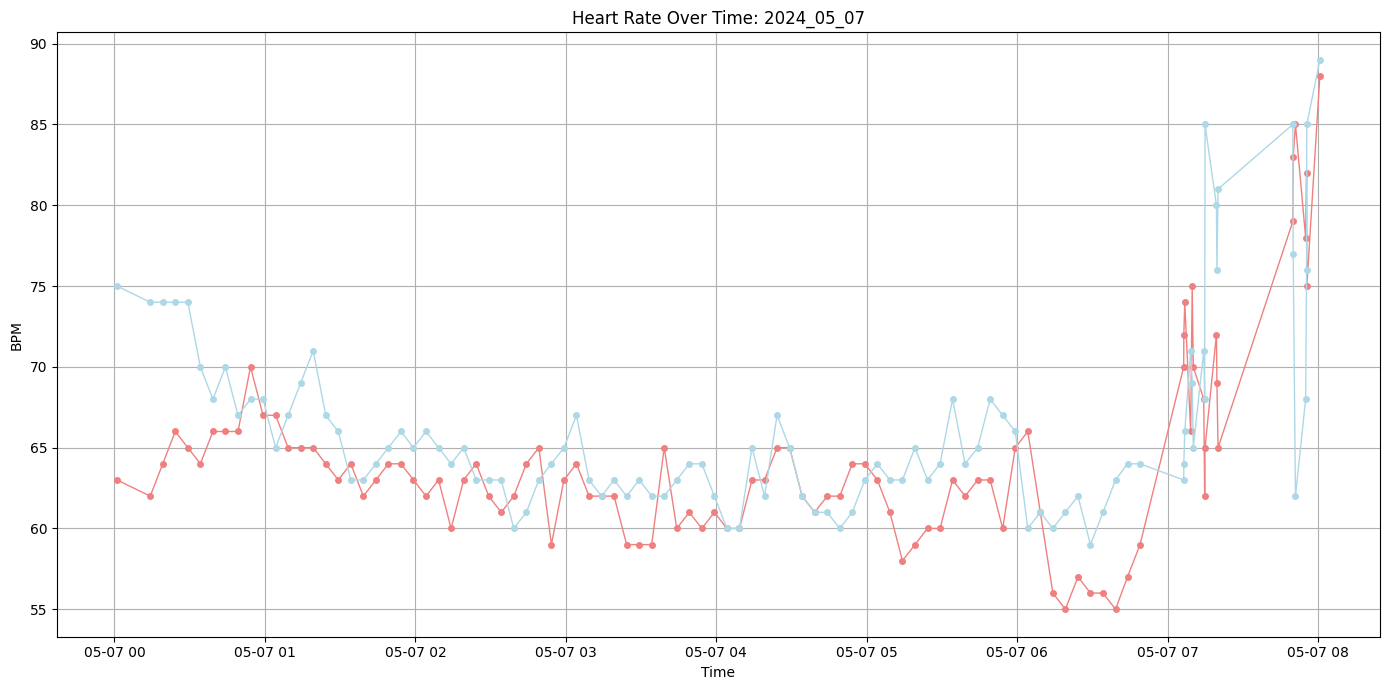

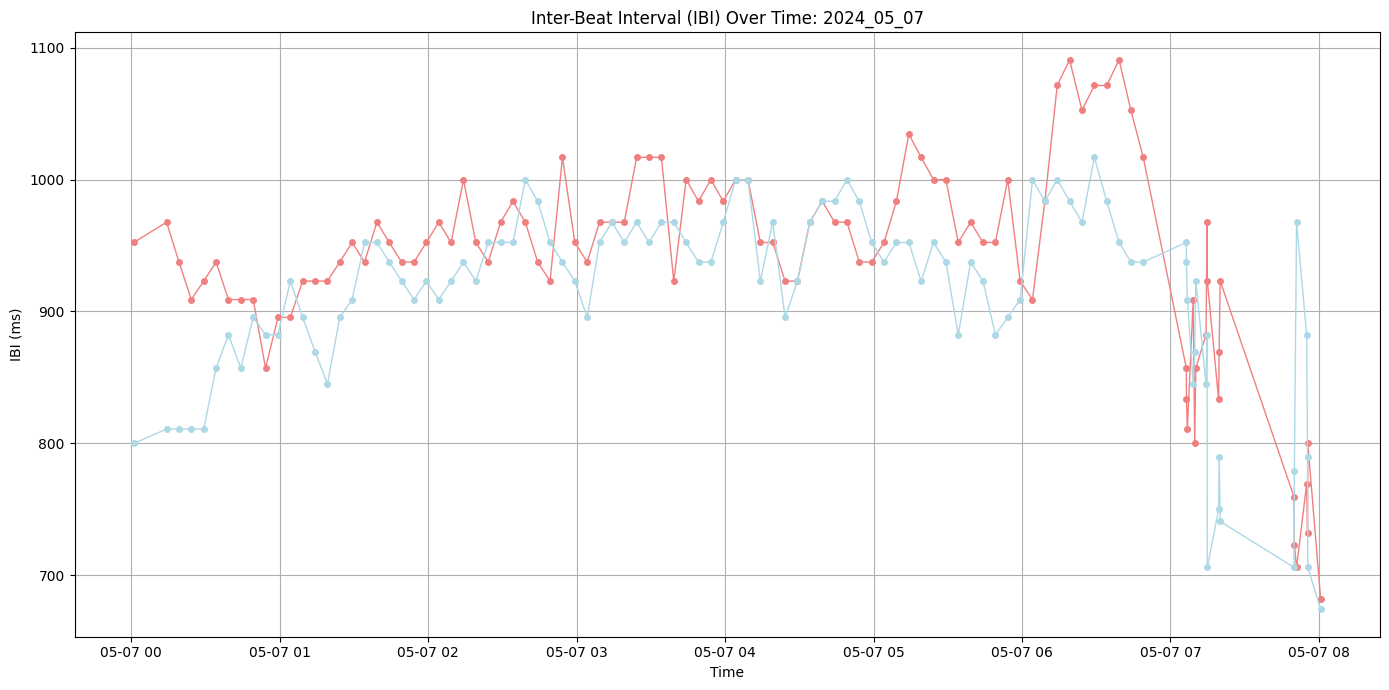

In [178]:
# Compound analysis and comparison of 2 time frames
def prepare_data(dataframe):
    dataframe = dataframe.with_columns((pl.col("timestamp").str.to_datetime().cast(pl.Datetime)).alias("datetime"))
    dataframe = dataframe.with_columns((60000/dataframe["bpm"]).alias("IBI"))
    dataframe = dataframe.with_columns((pl.col("datetime").diff().dt.total_seconds()).alias("RR"))
    dataframe.select(pl.col("RR").drop_nulls())

    return dataframe
    
def compound_analysis(time_frame1, time_frame2):
    sample1 = pl.read_csv(time_frame1)
    df1 = prepare_data(sample1)
    sample2 = pl.read_csv(time_frame2)
    df2 = prepare_data(sample2)

    
    plt.figure(figsize=(14, 7))
    plt.plot([i for i in df1["datetime"]], df1['bpm'], marker='o', linestyle='-', linewidth=1, markersize=4, color="lightcoral")
    plt.plot([i for i in df1["datetime"]], df2['bpm'], marker='o', linestyle='-', linewidth=1, markersize=4, color="lightblue")
    plt.title(f'Heart Rate Over Time: {sample}')
    plt.xlabel('Time')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.tight_layout()

    plt.figure(figsize=(14, 7))
    plt.plot([i for i in df1["datetime"]], df1['IBI'], marker='o', linestyle='-', linewidth=1, markersize=4, color="lightcoral")
    plt.plot([i for i in df1["datetime"]], df2['IBI'], marker='o', linestyle='-', linewidth=1, markersize=4, color="lightblue")
    plt.title(f'Inter-Beat Interval (IBI) Over Time: {sample}')
    plt.xlabel('Time')
    plt.ylabel('IBI (ms)')
    plt.grid(True)
    plt.tight_layout()
   
    plt.show()

sample_df = raw_df.filter((pl.datetime(2024, 5, 8) > pl.col("datetime")) & (pl.col("datetime") >= pl.datetime(2024, 5, 7)))
sample_df = sample_df[:100]
save_data_snippet(sample_df, "2024_05_07")

sample_df2 = raw_df.filter((pl.datetime(2024, 5, 10) > pl.col("datetime")) & (pl.col("datetime") >= pl.datetime(2024, 5, 9)))
sample_df2 = sample_df2[:100]
save_data_snippet(sample_df2, "2024_05_09")
compound_analysis("./data/2024_05_07.csv", "./data/2024_05_09.csv")
